In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from Data_Functions import Get_Data, Explore_Data, Get_Class_Distribution, Get_MI_Matrices, Extract_PassengerId_Info
from Visualization_Functions import Plot_Distributions, Plot_Nulls_Heatmap, Plot_Num_Distributions, Plot_Stats, Gridplot_Hists, Plot_MI_Heatmap, Plot_MI, PairGrid_kde
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif
from sklearn.preprocessing import LabelEncoder
import importlib

In [2]:
filename = 'Data/train.csv'
df = Get_Data(filename)
df.tail()

PassengerId HomePlanet CryoSleep     Cabin    Destination   Age    VIP  \
8688     9276_01     Europa     False    A/98/P    55 Cancri e  41.0   True   
8689     9278_01      Earth      True  G/1499/S  PSO J318.5-22  18.0  False   
8690     9279_01      Earth     False  G/1500/S    TRAPPIST-1e  26.0  False   
8691     9280_01     Europa     False   E/608/S    55 Cancri e  32.0  False   
8692     9280_02     Europa     False   E/608/S    TRAPPIST-1e  44.0  False   

      RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
8688          0.0     6819.0           0.0  1643.0    74.0  Gravior Noxnuther   
8689          0.0        0.0           0.0     0.0     0.0    Kurta Mondalley   
8690          0.0        0.0        1872.0     1.0     0.0       Fayey Connon   
8691          0.0     1049.0           0.0   353.0  3235.0   Celeon Hontichre   
8692        126.0     4688.0           0.0     0.0    12.0   Propsh Hontichre   

      Transported  
8688        False  
8689        False  
8690         True  
8691        False  
8692         True

In [3]:
Explore_Data(df)

shape:
 (8693, 14) 

column names:
 Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object') 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 1

In [4]:
null_rows = len(df[df.isnull().any(axis = 1)])
null_rows, null_rows*100/len(df)

(2087, 24.007822385827676)

## Initial Observations:
* Target feature is <b>Transported</b> with binary values
* All features have a comparable number of missing values (about 2% each)
* 24% of the entries have at least one missing value. That's a lot of data to lose if we are to simply delete all rows with null values
* Categorical features are: PassengerId, HomePlanet, CryoSleep, Cabin, Destination, VIP, Name
* Numerical features are: Age, RoomService, FoodCourt, ShoppingMall, Spa, VRDeck

In [5]:
target = 'Transported'
df_classes, Class_Distribution, Class_Distribution_Norm = Get_Class_Distribution(df, target)
Class_Distribution_Norm

Transported
True     0.503624
False    0.496376
Name: proportion, dtype: float64

In [6]:
df_null = df[df.isnull().any(axis = 1)].copy()
df_null_classes, df_null_Class_Distribution, df_null_Class_Distribution_Norm = Get_Class_Distribution(df_null, target)
df_null_Class_Distribution_Norm

Transported
True     0.503594
False    0.496406
Name: proportion, dtype: float64

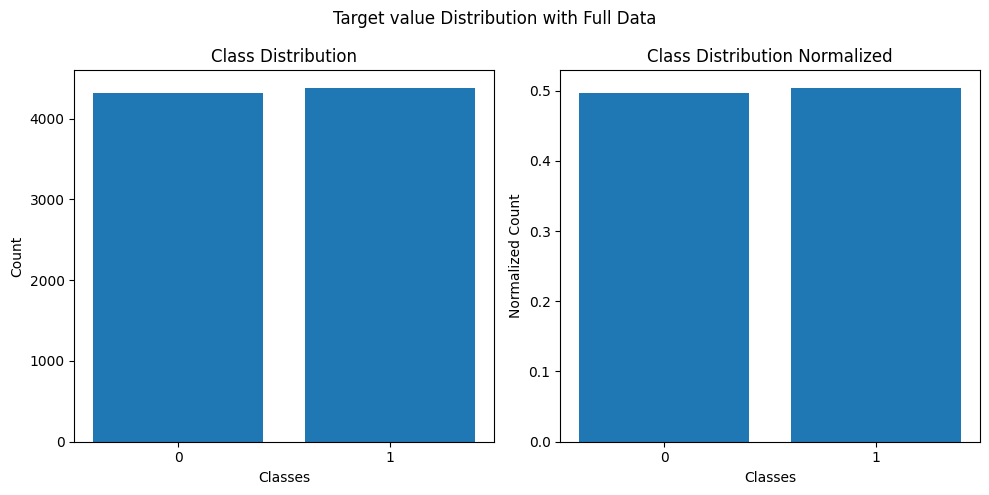

In [7]:
Plot_Distributions(Class_Distribution, Class_Distribution_Norm, 'Target value Distribution with Full Data')

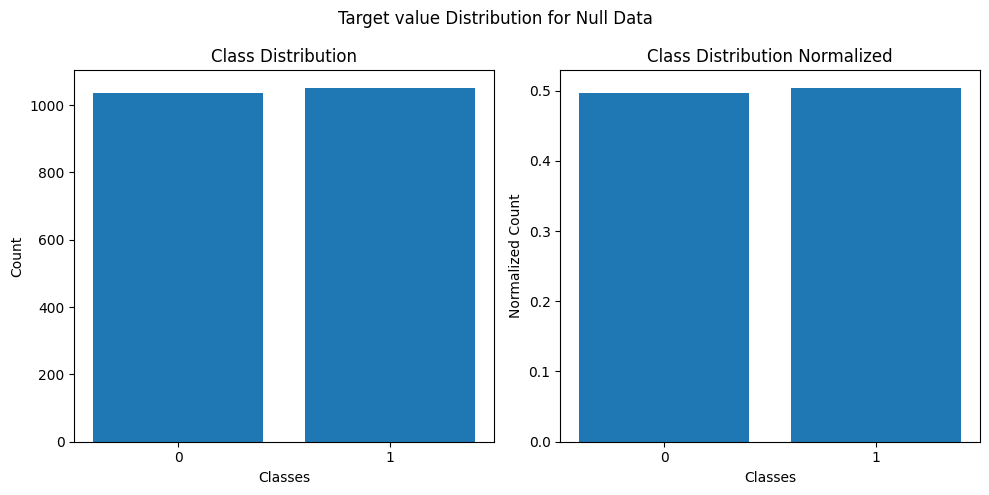

In [8]:
Plot_Distributions(df_null_Class_Distribution, df_null_Class_Distribution_Norm, 'Target value Distribution for Null Data')

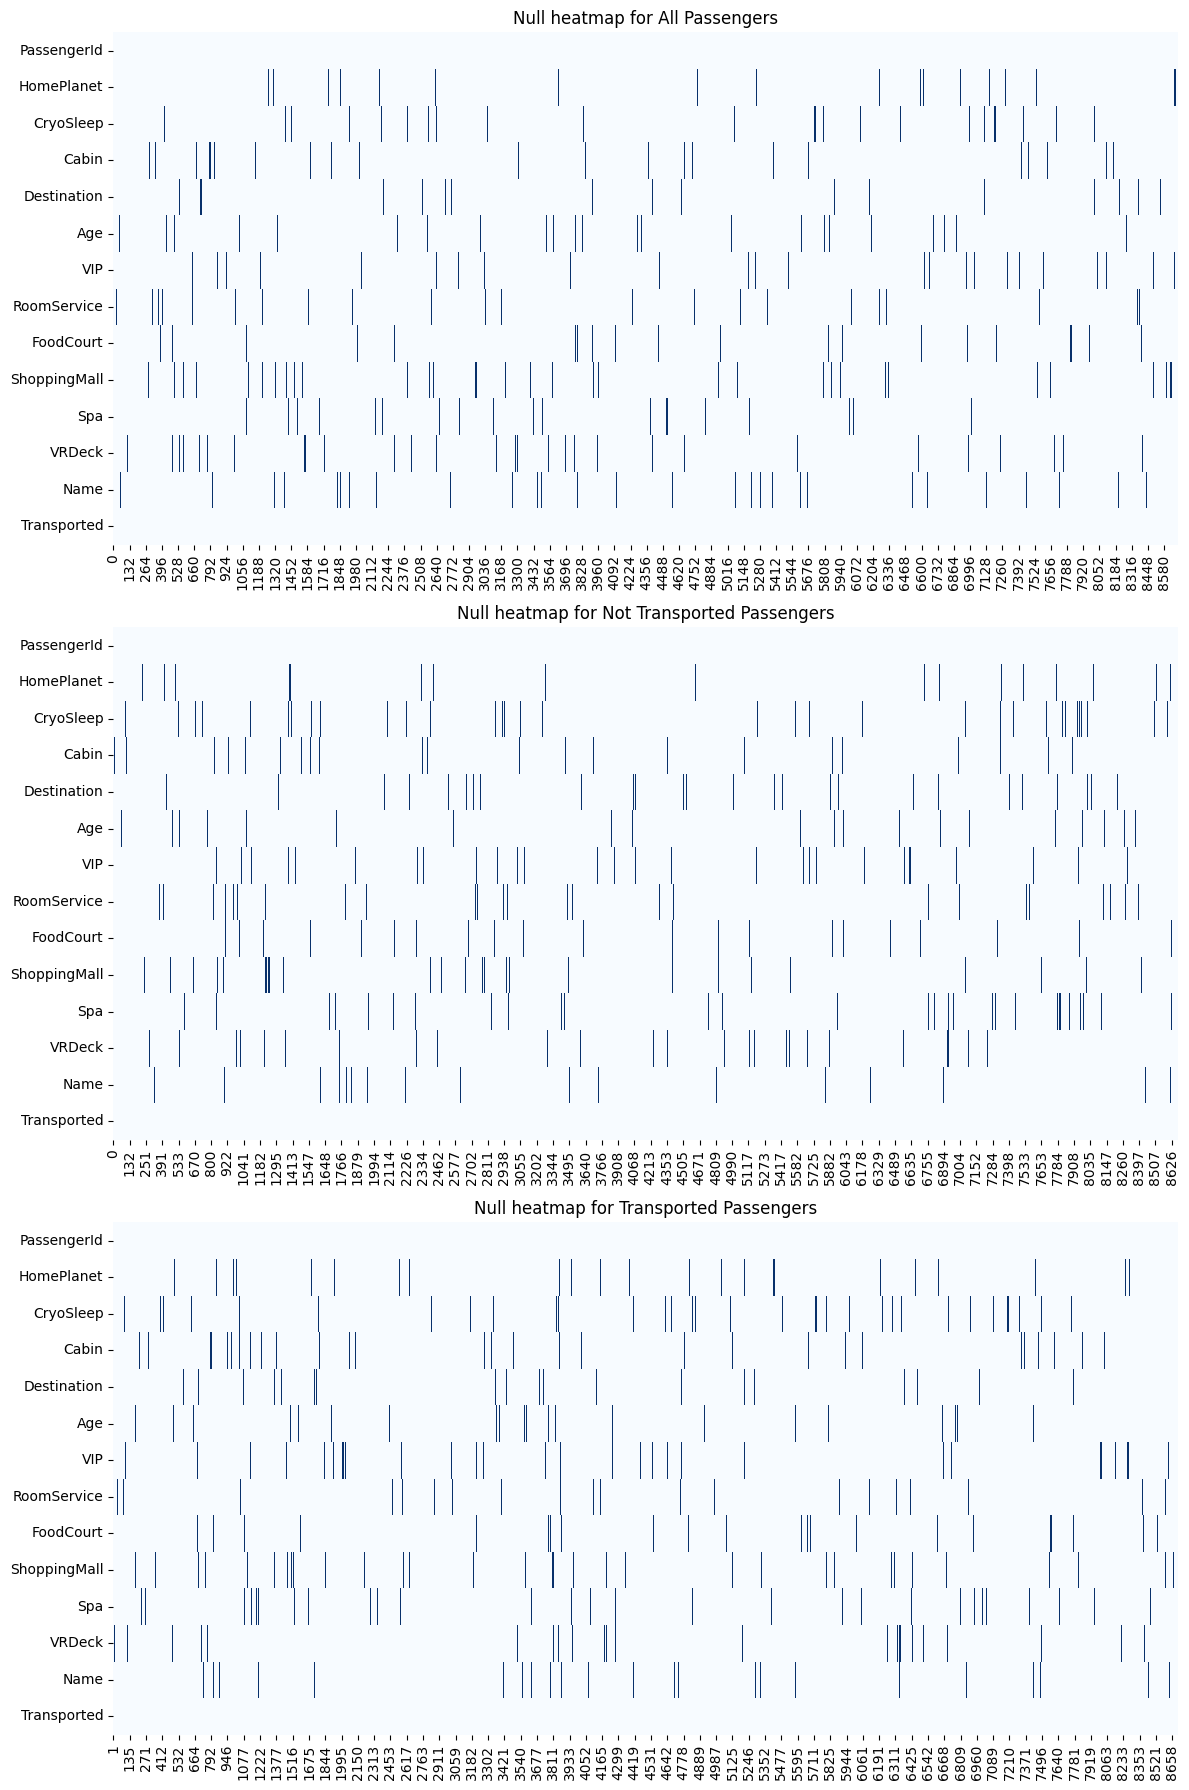

In [9]:
Plot_Nulls_Heatmap(df)

In [10]:
null_counts = df.groupby('Transported')[df.columns.drop(['PassengerId', 'Transported'])].apply(lambda f: f.isnull().sum())
null_counts

HomePlanet  CryoSleep  Cabin  Destination  Age  VIP  RoomService  \
Transported                                                                     
False                98        111     99           90   89   99           98   
True                103        106    100           92   90  104           83   

             FoodCourt  ShoppingMall  Spa  VRDeck  Name  
Transported                                              
False               84            94   92      90    99  
True                99           114   91      98   101

In [11]:
transported_nulls_ratio = null_counts.loc[True]/null_counts.sum()
transported_nulls_ratio

HomePlanet      0.512438
CryoSleep       0.488479
Cabin           0.502513
Destination     0.505495
Age             0.502793
VIP             0.512315
RoomService     0.458564
FoodCourt       0.540984
ShoppingMall    0.548077
Spa             0.497268
VRDeck          0.521277
Name            0.505000
dtype: float64

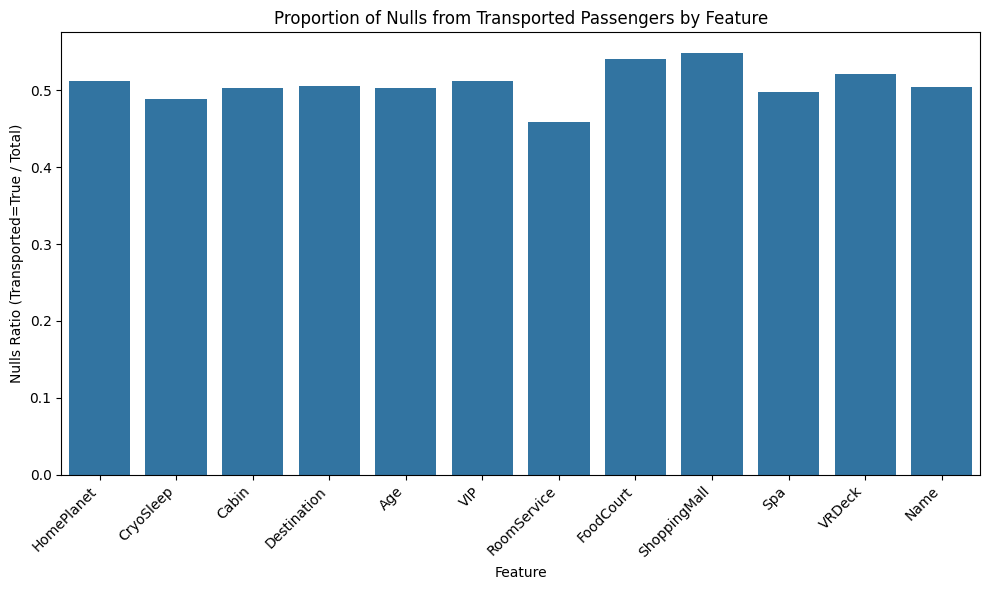

In [12]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x = transported_nulls_ratio.index, y = transported_nulls_ratio.values, ax = ax)
ax.set(xlabel = 'Feature',
       ylabel = 'Nulls Ratio (Transported=True / Total)',
       title = 'Proportion of Nulls from Transported Passengers by Feature')
plt.xticks(rotation = 45, ha = 'right')
plt.tight_layout()
plt.show()

In [13]:
nulls_per_row = df[df.isnull().any(axis = 1)].isnull().sum(axis = 1)
min(nulls_per_row), max(nulls_per_row)

(1, 3)

In [14]:
len(nulls_per_row[nulls_per_row == 1])*100/len(df), len(nulls_per_row[nulls_per_row == 2])*100/len(df), len(nulls_per_row[nulls_per_row == 3])*100/len(df)

(21.477050500402623, 2.3352122397331185, 0.19555964569193604)

## Observations:
* Target class is balanced
* Missing data seems to be random and not correlated with target value
* 21.48% of data are missing info from one feature, only 2.34% missing two features and 0.20% missing three features

# Numerical Features Distributions and Mutual Information

In [15]:
num_features = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
Luxury_Features = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
target = 'Transported'

In [16]:
df[num_features].skew().apply(np.abs)

Age              0.419097
RoomService      6.333014
FoodCourt        7.102228
ShoppingMall    12.627562
Spa              7.636020
VRDeck           7.819732
dtype: float64

### **<font color = 'DarkRed'> We can see that all the Luxury Features have a skewed distribution, so we need to apply a transformation to adjust the skewness </font>**

In [17]:
df[Luxury_Features] = df[Luxury_Features].astype(float).apply(np.log1p)
df[num_features].skew().apply(np.abs)

Age             0.419097
RoomService     1.117736
FoodCourt       1.110788
ShoppingMall    1.201576
Spa             1.090025
VRDeck          1.160167
dtype: float64

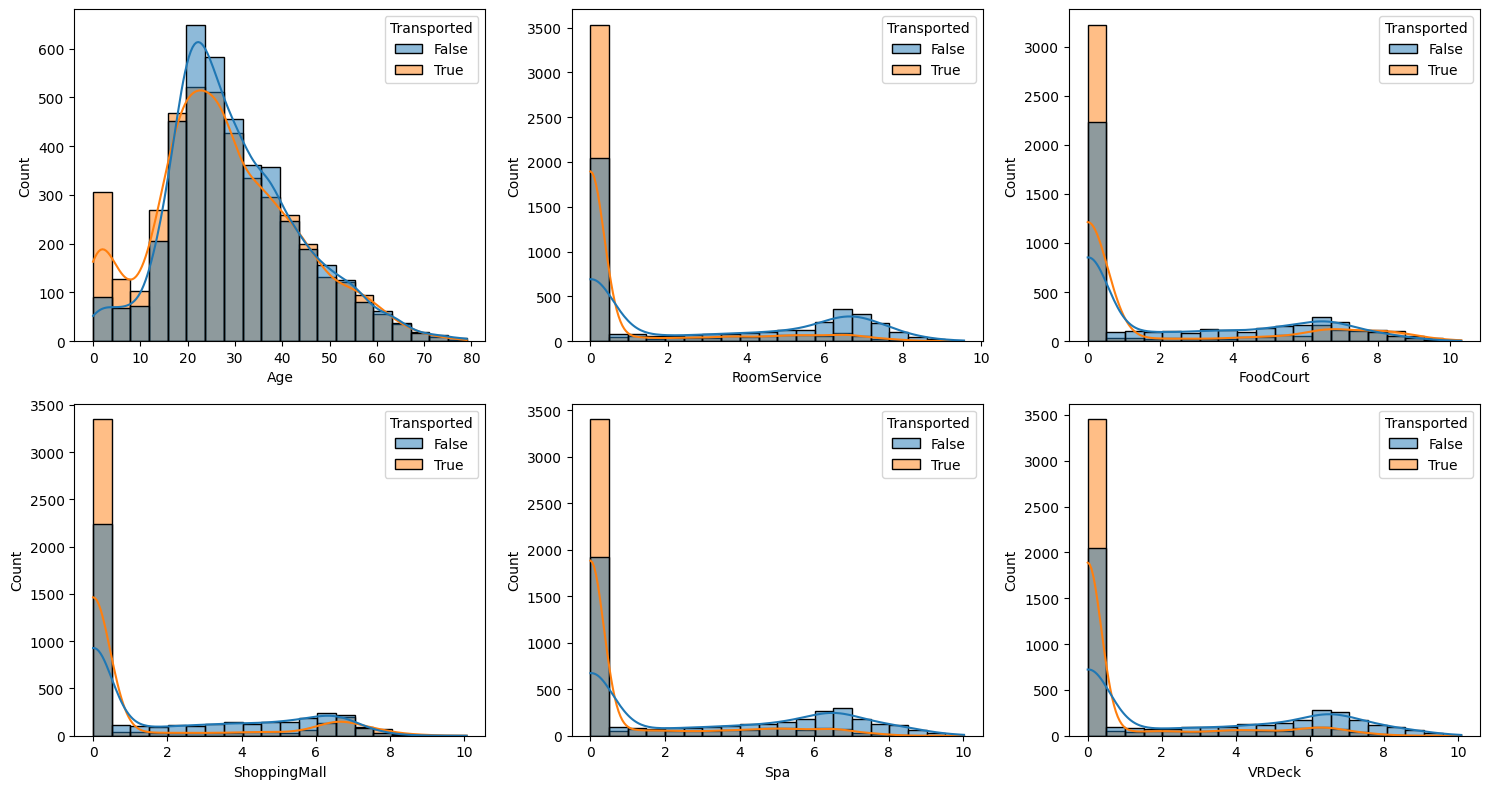

In [18]:
Plot_Num_Distributions(df, num_features, target, ncols = 3)

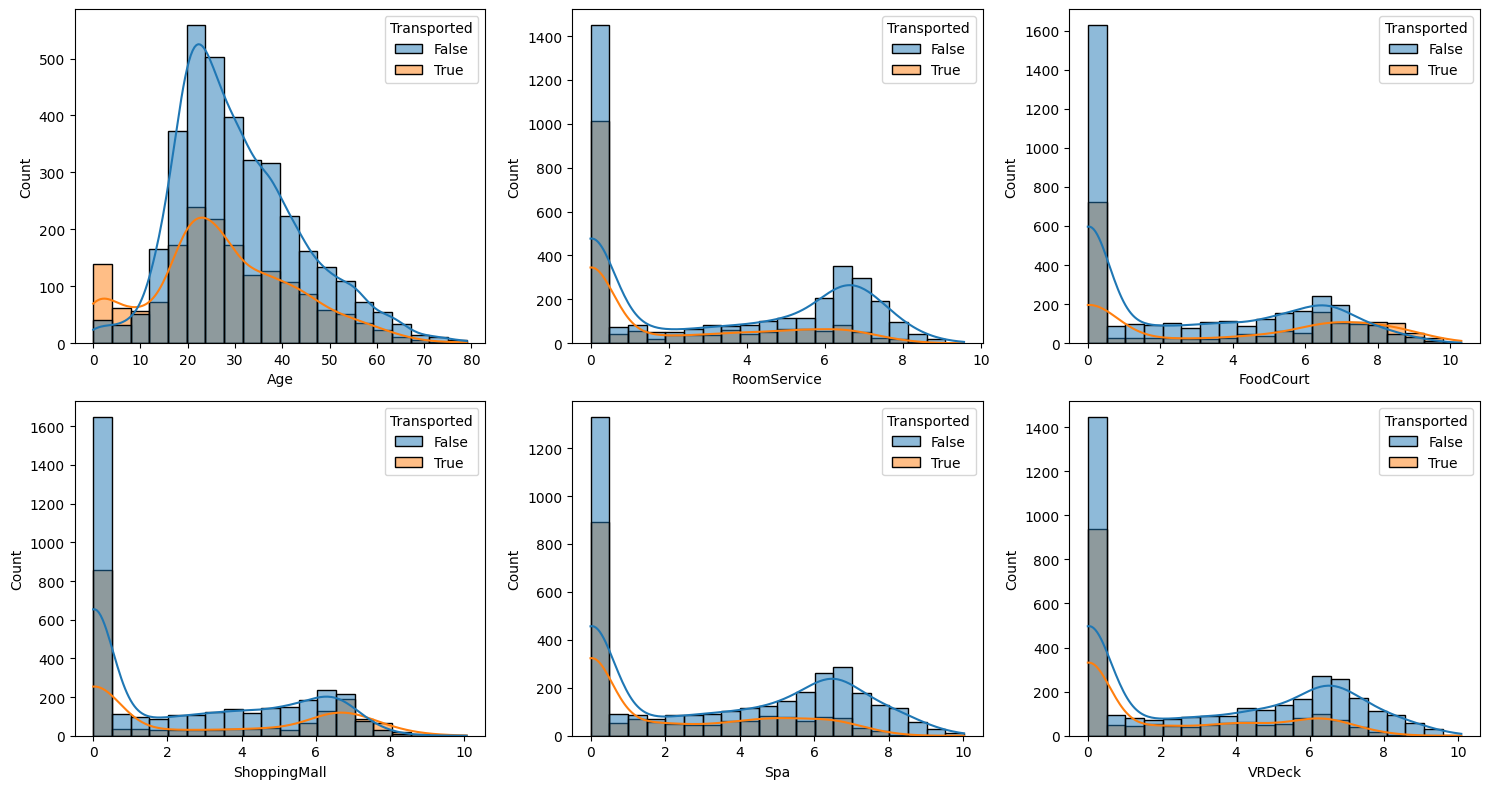

In [19]:
Plot_Num_Distributions(df[df.CryoSleep == False], num_features, target, ncols = 3)

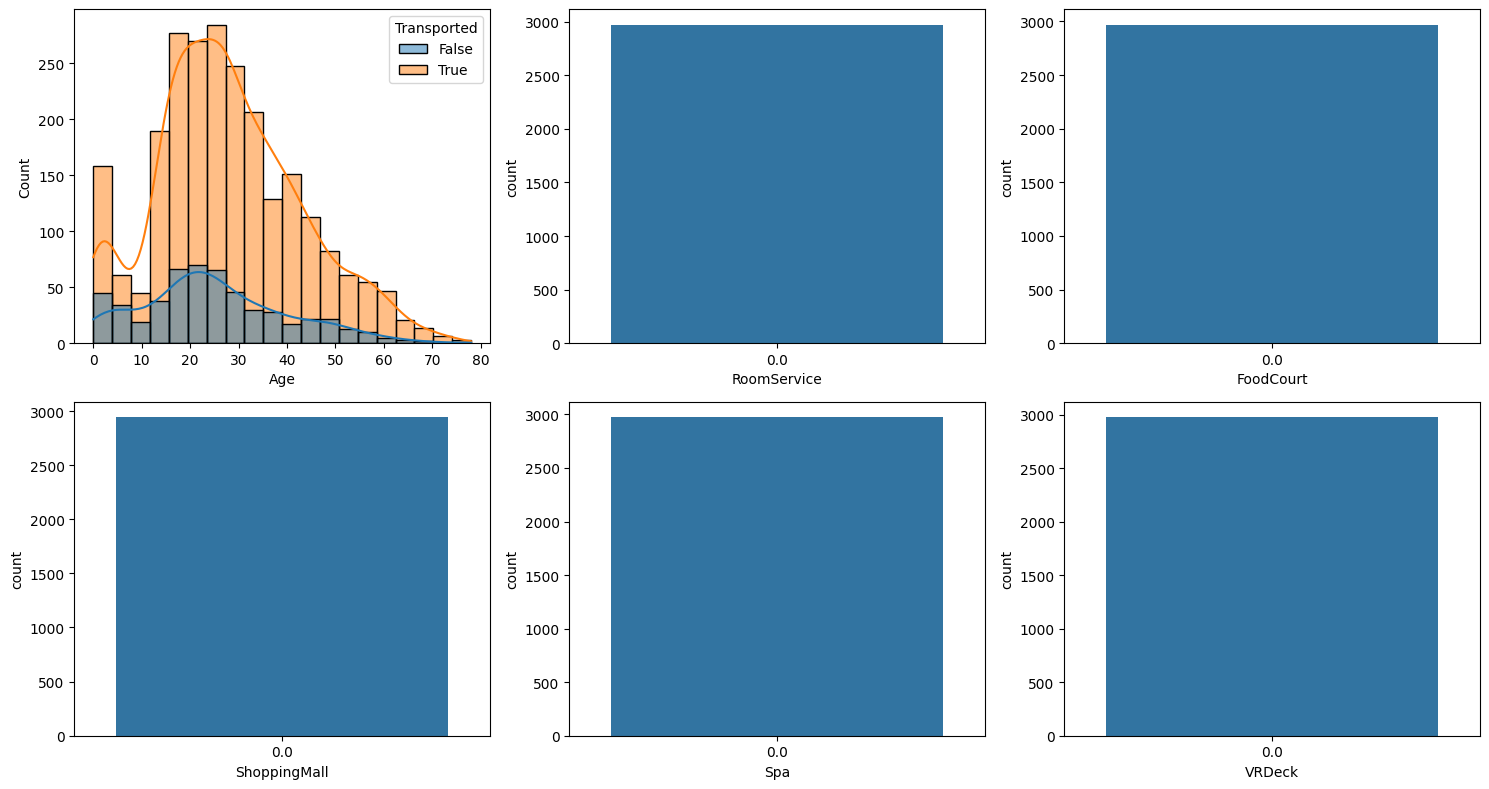

In [20]:
Plot_Num_Distributions(df[df.CryoSleep == True], num_features, target, ncols = 3)

In [21]:
bins = 11
bin_labels = range(1, bins + 1)
df['Age_Bin'], Bin_ranges = pd.qcut(df.Age, q = bins, labels = bin_labels, retbins = True)
Bin_ranges

array([ 0., 12., 18., 20., 23., 25., 28., 32., 37., 42., 50., 79.])

In [22]:
df

PassengerId HomePlanet CryoSleep     Cabin    Destination   Age    VIP  \
0        0001_01     Europa     False     B/0/P    TRAPPIST-1e  39.0  False   
1        0002_01      Earth     False     F/0/S    TRAPPIST-1e  24.0  False   
2        0003_01     Europa     False     A/0/S    TRAPPIST-1e  58.0   True   
3        0003_02     Europa     False     A/0/S    TRAPPIST-1e  33.0  False   
4        0004_01      Earth     False     F/1/S    TRAPPIST-1e  16.0  False   
...          ...        ...       ...       ...            ...   ...    ...   
8688     9276_01     Europa     False    A/98/P    55 Cancri e  41.0   True   
8689     9278_01      Earth      True  G/1499/S  PSO J318.5-22  18.0  False   
8690     9279_01      Earth     False  G/1500/S    TRAPPIST-1e  26.0  False   
8691     9280_01     Europa     False   E/608/S    55 Cancri e  32.0  False   
8692     9280_02     Europa     False   E/608/S    TRAPPIST-1e  44.0  False   

      RoomService  FoodCourt  ShoppingMall       Spa    VRDeck  \
0        0.000000   0.000000      0.000000  0.000000  0.000000   
1        4.700480   2.302585      3.258097  6.309918  3.806662   
2        3.784190   8.182280      0.000000  8.812248  3.912023   
3        0.000000   7.157735      5.918894  8.110728  5.267858   
4        5.717028   4.262680      5.023881  6.338594  1.098612   
...           ...        ...           ...       ...       ...   
8688     0.000000   8.827615      0.000000  7.404888  4.317488   
8689     0.000000   0.000000      0.000000  0.000000  0.000000   
8690     0.000000   0.000000      7.535297  0.693147  0.000000   
8691     0.000000   6.956545      0.000000  5.869297  8.082093   
8692     4.844187   8.452975      0.000000  0.000000  2.564949   

                   Name  Transported Age_Bin  
0       Maham Ofracculy        False       9  
1          Juanna Vines         True       5  
2         Altark Susent        False      11  
3          Solam Susent        False       8  
4     Willy Santantines         True       2  
...                 ...          ...     ...  
8688  Gravior Noxnuther        False       9  
8689    Kurta Mondalley        False       2  
8690       Fayey Connon         True       6  
8691   Celeon Hontichre        False       7  
8692   Propsh Hontichre         True      10  

[8693 rows x 15 columns]

Text(0.5, 1.0, 'Age_Bin Distribution for Passengers Not in CryoSleep')

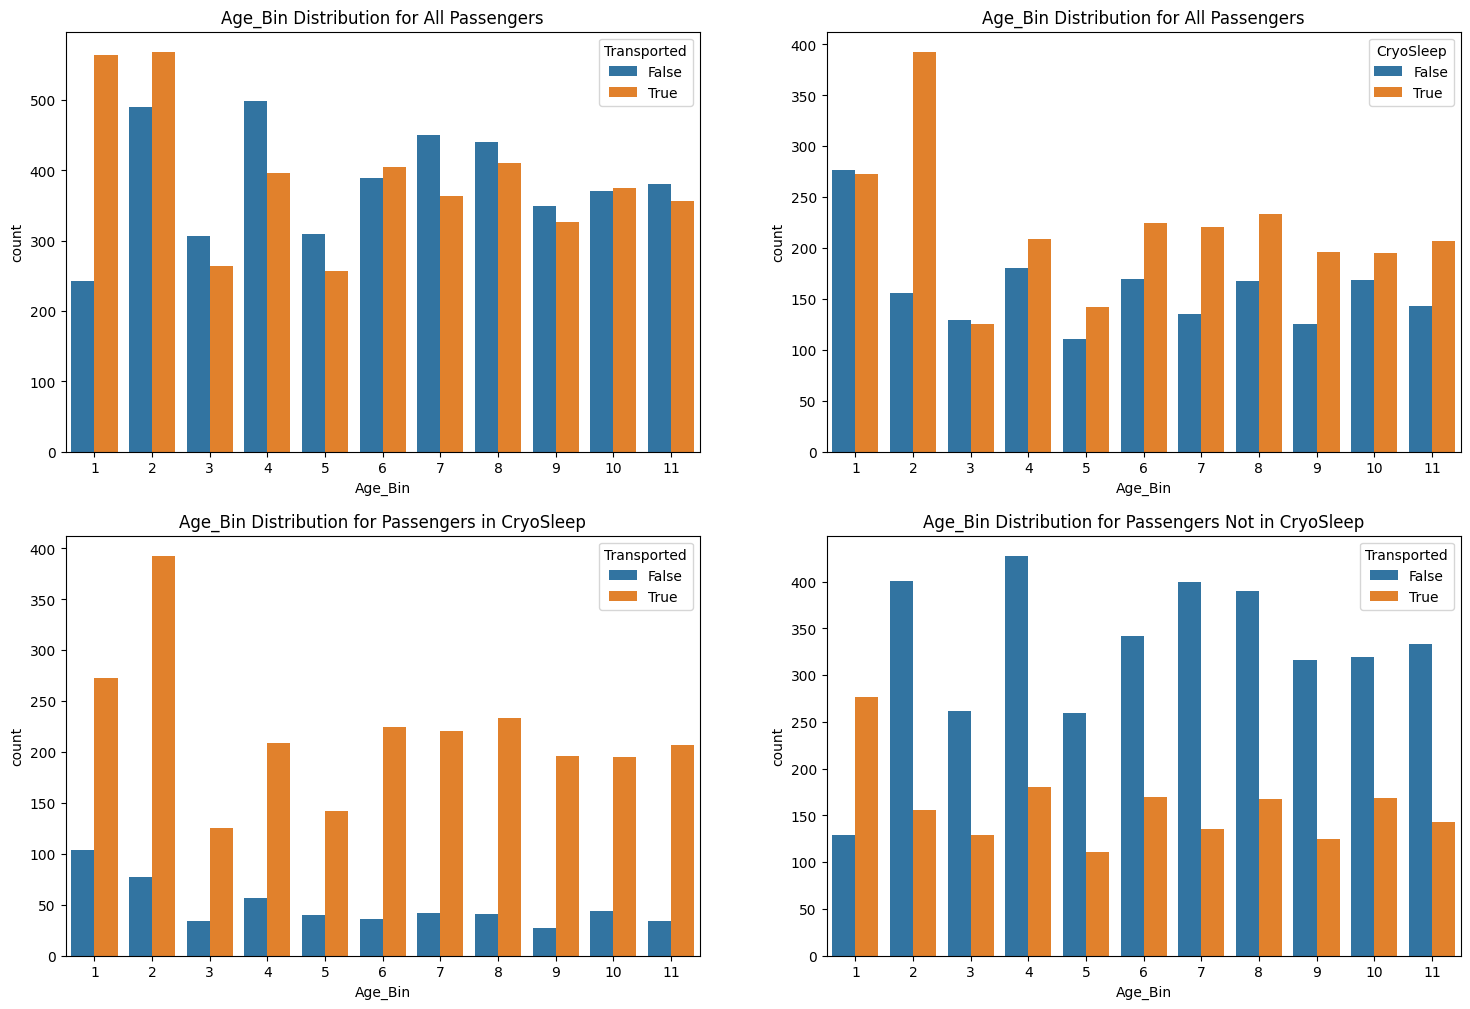

In [23]:
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (18, 12))
axs = axs.flatten()
sns.countplot(data = df, x = 'Age_Bin', hue = target, ax = axs[0])
sns.countplot(data = df[df.Transported == True], x = 'Age_Bin', hue = 'CryoSleep', ax = axs[1])
sns.countplot(data = df[df.CryoSleep == True], x = 'Age_Bin', hue = target, ax = axs[2])
sns.countplot(data = df[df.CryoSleep == False], x = 'Age_Bin', hue = target, ax = axs[3])

axs[0].set_title('Age_Bin Distribution for All Passengers')
axs[1].set_title('Age_Bin Distribution for All Passengers')
axs[2].set_title('Age_Bin Distribution for Passengers in CryoSleep')
axs[3].set_title('Age_Bin Distribution for Passengers Not in CryoSleep')

## Observations
* Passengers in Cryosleep are a lot more likely to be transported than those not in Cryosleep
* Young passengers are more likely to be transported than adults.
* Teens (13 - 18) are more likely to be in Cryosleep
* Teens not in Cryosleep are less likely to be transported
* Children (0 - 12) are the least likely to be negatively affected for not being in CryoSleep. They still have an advantage over all other age groups
* Obviously, passengers in Cryosleep spend no money on Luxury items. For passengers known to be in Cryosleep we can safely replace all nulls by zero for the Luxury features

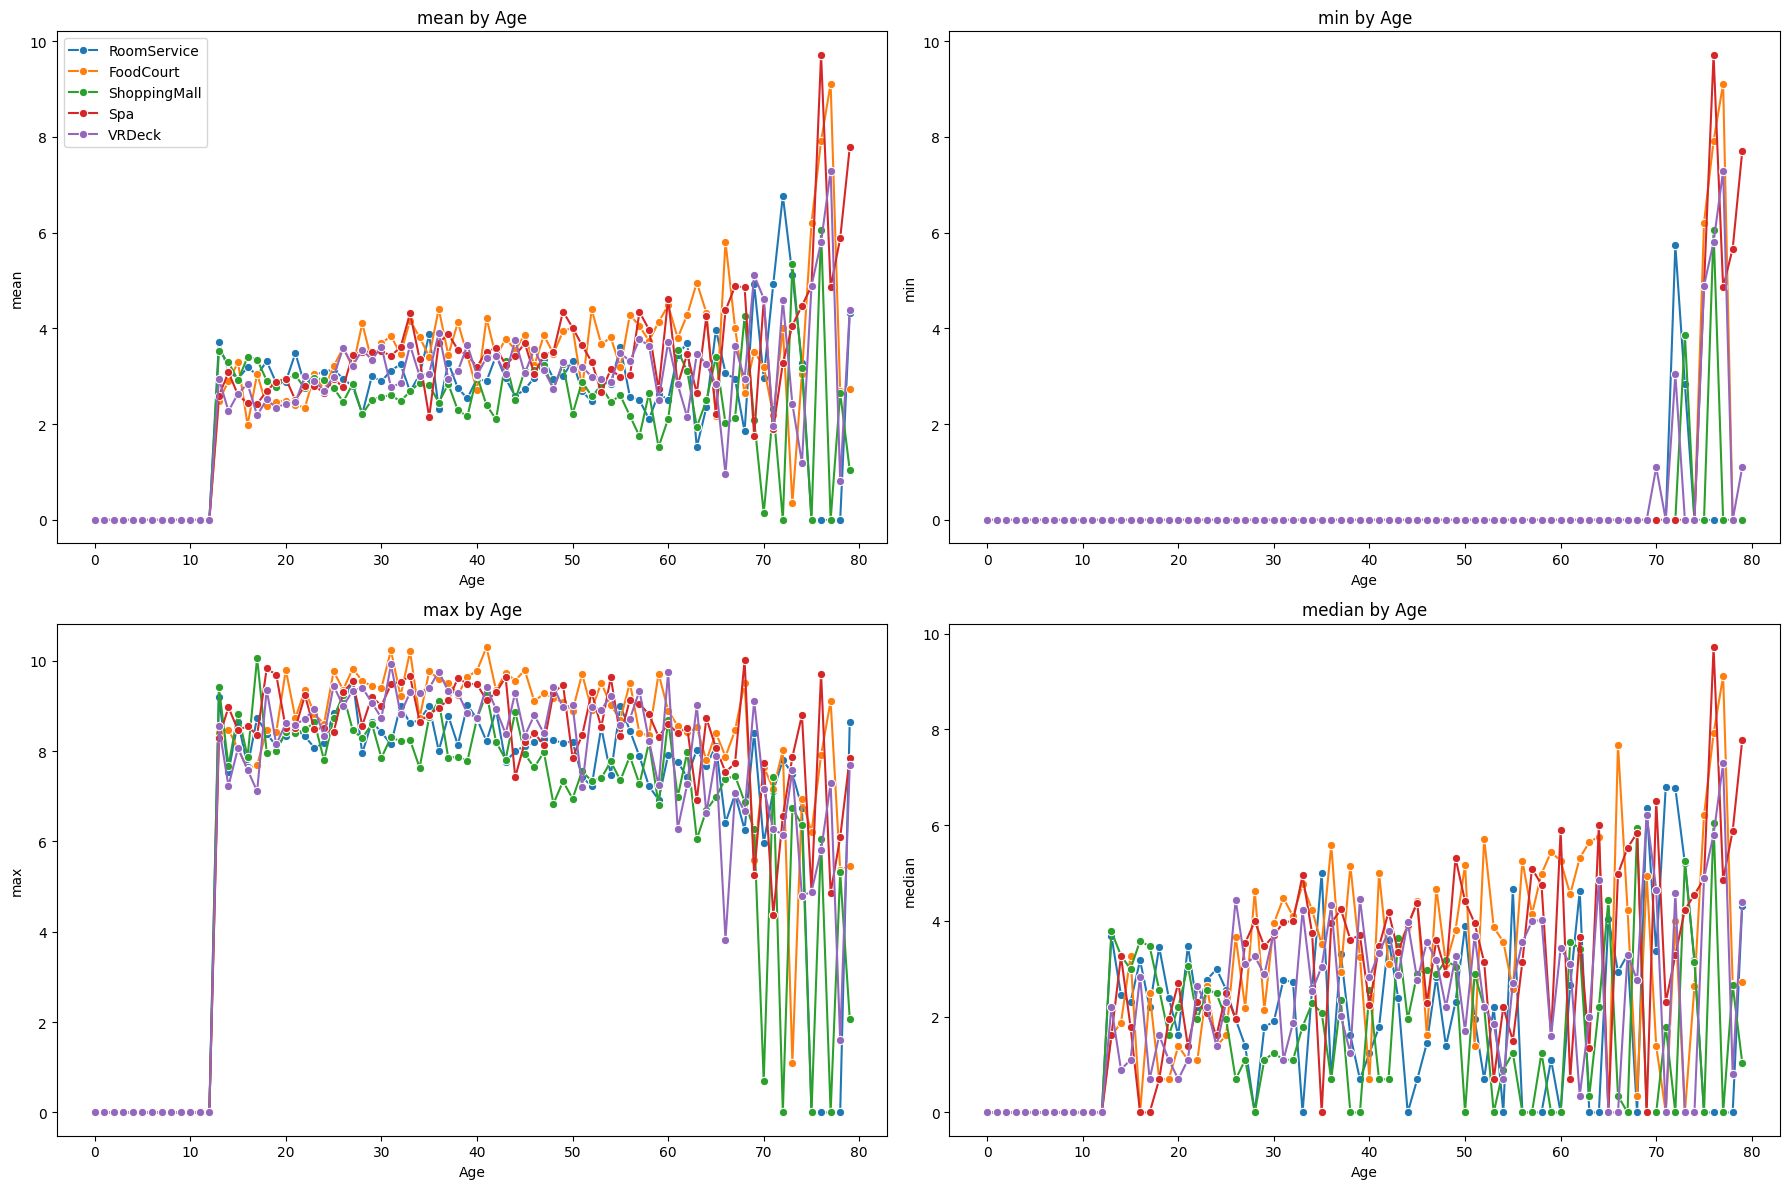

In [24]:
dfn = df[df.CryoSleep == False][num_features + ['Age_Bin', 'Transported']].dropna().copy()
# df_Luxury_byAge = df[df.CryoSleep == False].groupby('Age')[Luxury_Features].agg(['mean', 'min', 'max', 'median'])
dfn_Luxury_byAge = dfn.groupby('Age')[Luxury_Features].agg(['mean', 'min', 'max', 'median'])
stats = ['mean', 'min', 'max', 'median']

Plot_Stats(dfn_Luxury_byAge, 'Age', stats, ncols = 2)

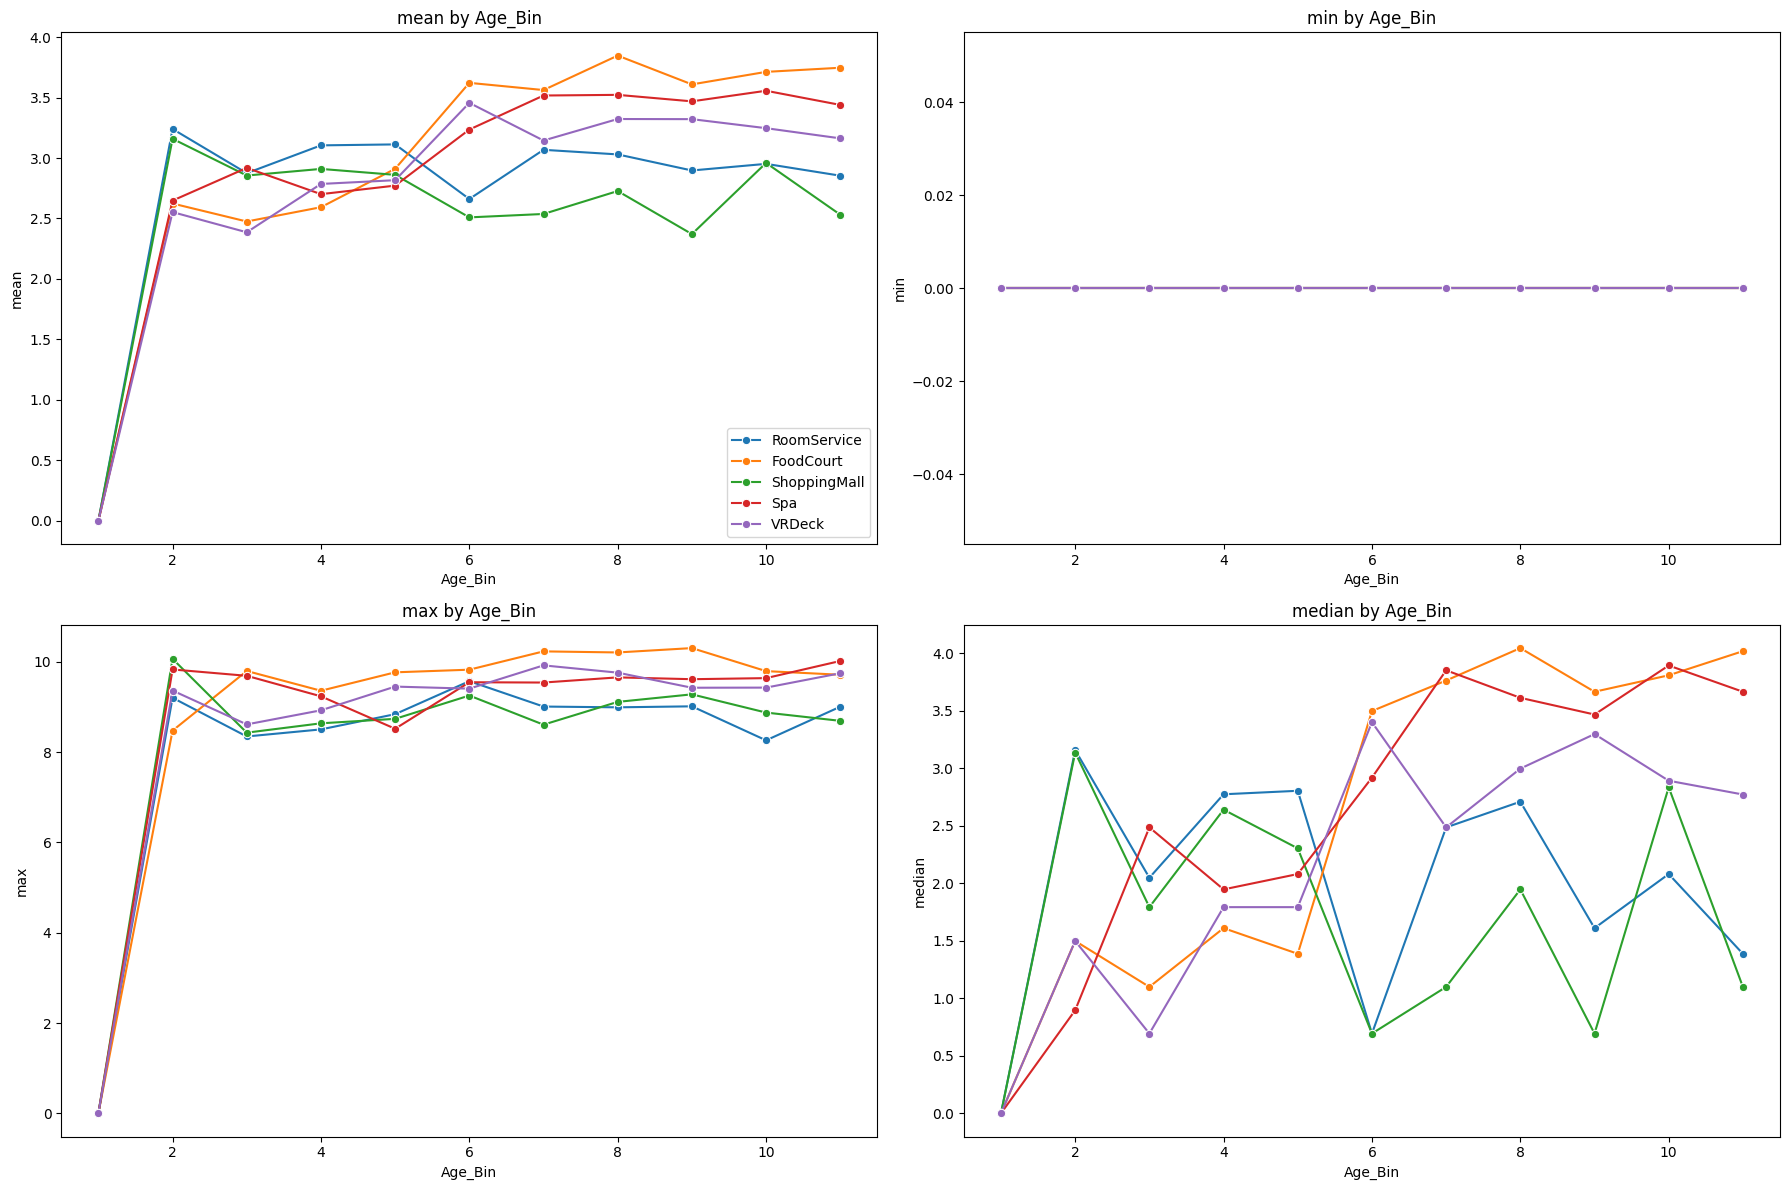

In [25]:
# import Visualization_Functions
# importlib.reload(Visualization_Functions)
# from Visualization_Functions import Plot_Stats

dfn_Luxury_byAge_Bin = dfn.groupby('Age_Bin')[Luxury_Features].agg(['mean', 'min', 'max', 'median'])
Plot_Stats(dfn_Luxury_byAge_Bin, 'Age_Bin', stats, ncols = 2)

In [26]:
df[df.Age > 75].sort_values(by = 'Age', ascending = True)

PassengerId HomePlanet CryoSleep     Cabin  Destination   Age    VIP  \
1390     1455_05     Europa     False    B/62/S  55 Cancri e  76.0  False   
8288     8852_01       Mars      True   D/278/P  TRAPPIST-1e  76.0  False   
2930     3176_01     Europa     False   E/196/P  TRAPPIST-1e  77.0  False   
3526     3784_01      Earth     False   G/618/P  TRAPPIST-1e  77.0  False   
1429     1507_03      Earth     False   G/231/S  TRAPPIST-1e  78.0  False   
2361     2545_01      Earth      True   G/410/P  55 Cancri e  78.0  False   
6146     6485_01      Earth     False  F/1238/S  55 Cancri e  78.0  False   
338      0378_03     Europa     False    B/11/S  TRAPPIST-1e  79.0  False   
615      0642_03     Europa     False    C/25/S  TRAPPIST-1e  79.0  False   
4682     4991_01      Earth     False   G/806/P  TRAPPIST-1e  79.0  False   

      RoomService  FoodCourt  ShoppingMall       Spa    VRDeck  \
1390     0.000000   7.913155      6.047372  9.716857  5.802118   
8288     0.000000   0.000000      0.000000  0.000000  0.000000   
2930     0.000000   9.108640      0.000000  4.859812  7.289611   
3526     0.000000        NaN      4.882802  8.289539  4.691348   
1429     0.000000   0.000000      0.000000  6.091310  1.609438   
2361     0.000000   0.000000      0.000000  0.000000  0.000000   
6146     0.000000   5.365976      5.313206  5.666427  0.000000   
338      8.639411   5.463832      2.079442  7.855545  7.685244   
615      0.000000   0.000000      0.000000  7.701200  1.098612   
4682     6.415097        NaN      0.000000  5.303305  1.791759   

                    Name  Transported Age_Bin  
1390      Antino Wassird        False      11  
8288          Aark Homin         True      11  
2930  Ankalik Nateansive         True      11  
3526       Ale Morrencis        False      11  
1429         Anny Jeffey        False      11  
2361  Joycey Hoppernardy        False      11  
6146   Regory Haydenzier         True      11  
338       Naslon Pirejus        False      11  
615        Chabik Kiling        False      11  
4682       Rickie Pentss        False      11

In [27]:
dfn_Luxury_byAge.loc[dfn_Luxury_byAge.index < 14]

RoomService                          FoodCourt                           \
            mean  min       max    median      mean  min       max    median   
Age                                                                            
0.0      0.00000  0.0  0.000000  0.000000  0.000000  0.0  0.000000  0.000000   
1.0      0.00000  0.0  0.000000  0.000000  0.000000  0.0  0.000000  0.000000   
2.0      0.00000  0.0  0.000000  0.000000  0.000000  0.0  0.000000  0.000000   
3.0      0.00000  0.0  0.000000  0.000000  0.000000  0.0  0.000000  0.000000   
4.0      0.00000  0.0  0.000000  0.000000  0.000000  0.0  0.000000  0.000000   
5.0      0.00000  0.0  0.000000  0.000000  0.000000  0.0  0.000000  0.000000   
6.0      0.00000  0.0  0.000000  0.000000  0.000000  0.0  0.000000  0.000000   
7.0      0.00000  0.0  0.000000  0.000000  0.000000  0.0  0.000000  0.000000   
8.0      0.00000  0.0  0.000000  0.000000  0.000000  0.0  0.000000  0.000000   
9.0      0.00000  0.0  0.000000  0.000000  0.000000  0.0  0.000000  0.000000   
10.0     0.00000  0.0  0.000000  0.000000  0.000000  0.0  0.000000  0.000000   
11.0     0.00000  0.0  0.000000  0.000000  0.000000  0.0  0.000000  0.000000   
12.0     0.00000  0.0  0.000000  0.000000  0.000000  0.0  0.000000  0.000000   
13.0     3.70847  0.0  9.202409  3.688879  2.494101  0.0  8.408717  1.609438   

     ShoppingMall                               Spa                           \
             mean  min       max   median      mean  min       max    median   
Age                                                                            
0.0      0.000000  0.0  0.000000  0.00000  0.000000  0.0  0.000000  0.000000   
1.0      0.000000  0.0  0.000000  0.00000  0.000000  0.0  0.000000  0.000000   
2.0      0.000000  0.0  0.000000  0.00000  0.000000  0.0  0.000000  0.000000   
3.0      0.000000  0.0  0.000000  0.00000  0.000000  0.0  0.000000  0.000000   
4.0      0.000000  0.0  0.000000  0.00000  0.000000  0.0  0.000000  0.000000   
5.0      0.000000  0.0  0.000000  0.00000  0.000000  0.0  0.000000  0.000000   
6.0      0.000000  0.0  0.000000  0.00000  0.000000  0.0  0.000000  0.000000   
7.0      0.000000  0.0  0.000000  0.00000  0.000000  0.0  0.000000  0.000000   
8.0      0.000000  0.0  0.000000  0.00000  0.000000  0.0  0.000000  0.000000   
9.0      0.000000  0.0  0.000000  0.00000  0.000000  0.0  0.000000  0.000000   
10.0     0.000000  0.0  0.000000  0.00000  0.000000  0.0  0.000000  0.000000   
11.0     0.000000  0.0  0.000000  0.00000  0.000000  0.0  0.000000  0.000000   
12.0     0.000000  0.0  0.000000  0.00000  0.000000  0.0  0.000000  0.000000   
13.0     3.521613  0.0  9.413608  3.78419  2.591584  0.0  8.298291  1.609438   

        VRDeck                           
          mean  min       max    median  
Age                                      
0.0   0.000000  0.0  0.000000  0.000000  
1.0   0.000000  0.0  0.000000  0.000000  
2.0   0.000000  0.0  0.000000  0.000000  
3.0   0.000000  0.0  0.000000  0.000000  
4.0   0.000000  0.0  0.000000  0.000000  
5.0   0.000000  0.0  0.000000  0.000000  
6.0   0.000000  0.0  0.000000  0.000000  
7.0   0.000000  0.0  0.000000  0.000000  
8.0   0.000000  0.0  0.000000  0.000000  
9.0   0.000000  0.0  0.000000  0.000000  
10.0  0.000000  0.0  0.000000  0.000000  
11.0  0.000000  0.0  0.000000  0.000000  
12.0  0.000000  0.0  0.000000  0.000000  
13.0  2.943788  0.0  8.546364  2.197225

In [28]:
# mask = dfn_Luxury_byAge.columns.get_level_values(1) == 'median'
# pd.set_option('display.max_rows', 100)
# display(dfn_Luxury_byAge.loc[:, mask])
# pd.reset_option('display.max_rows')
dfn.Age_Bin = dfn.Age_Bin.astype(int)
dfn.dtypes

Age             float64
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Age_Bin           int64
Transported        bool
dtype: object

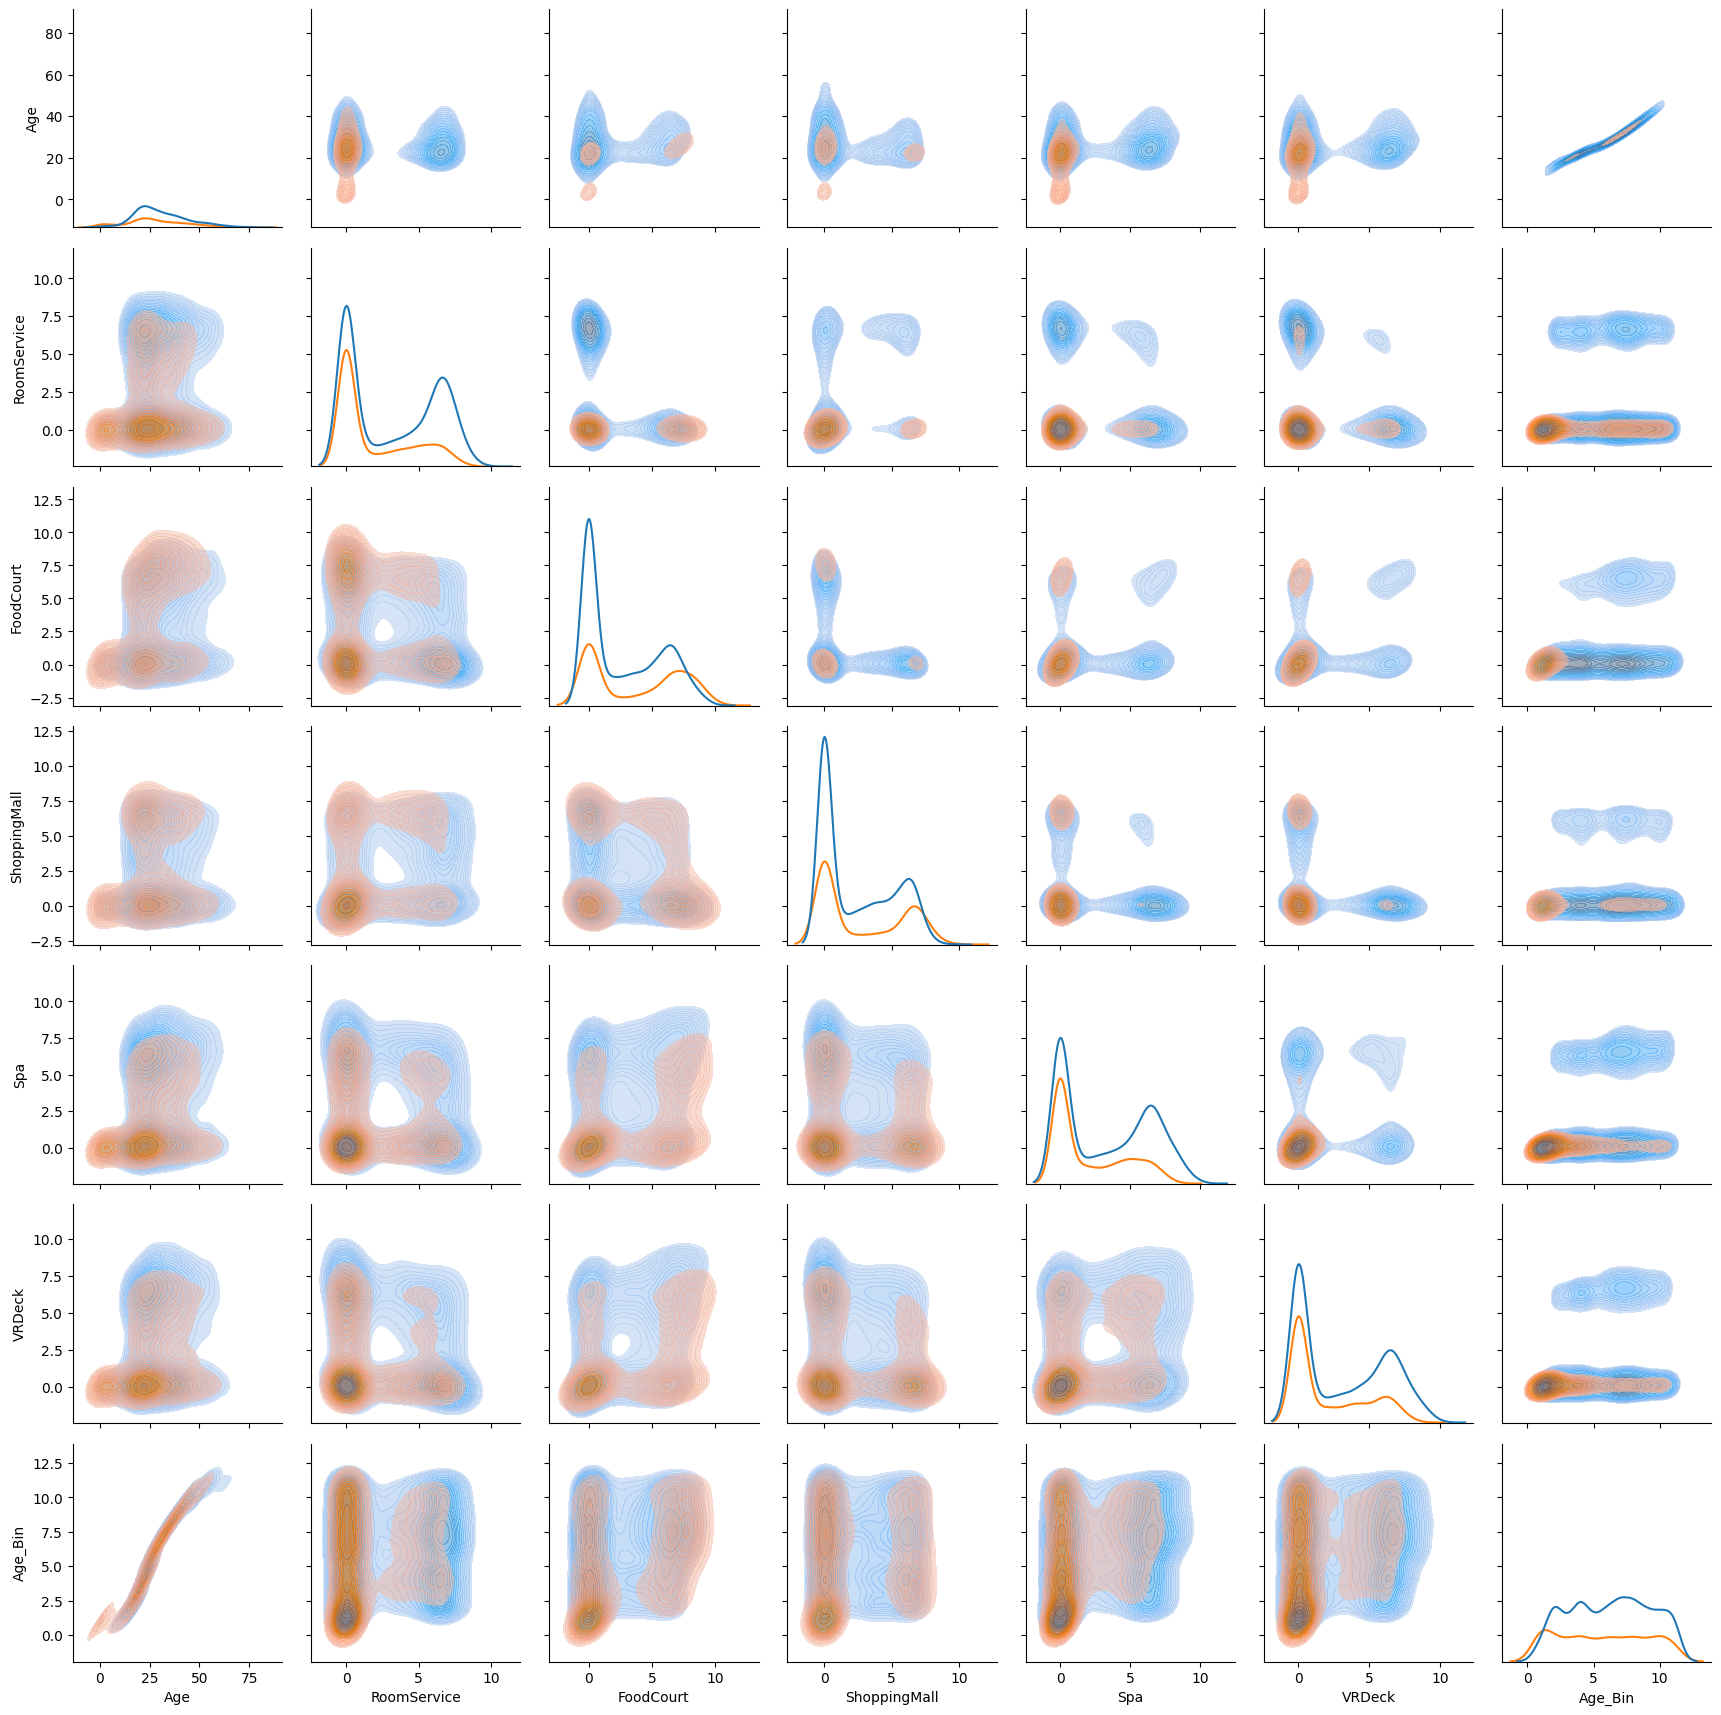

In [29]:
PairGrid_kde(dfn, num_features + ['Age_Bin'], hue = 'Transported')

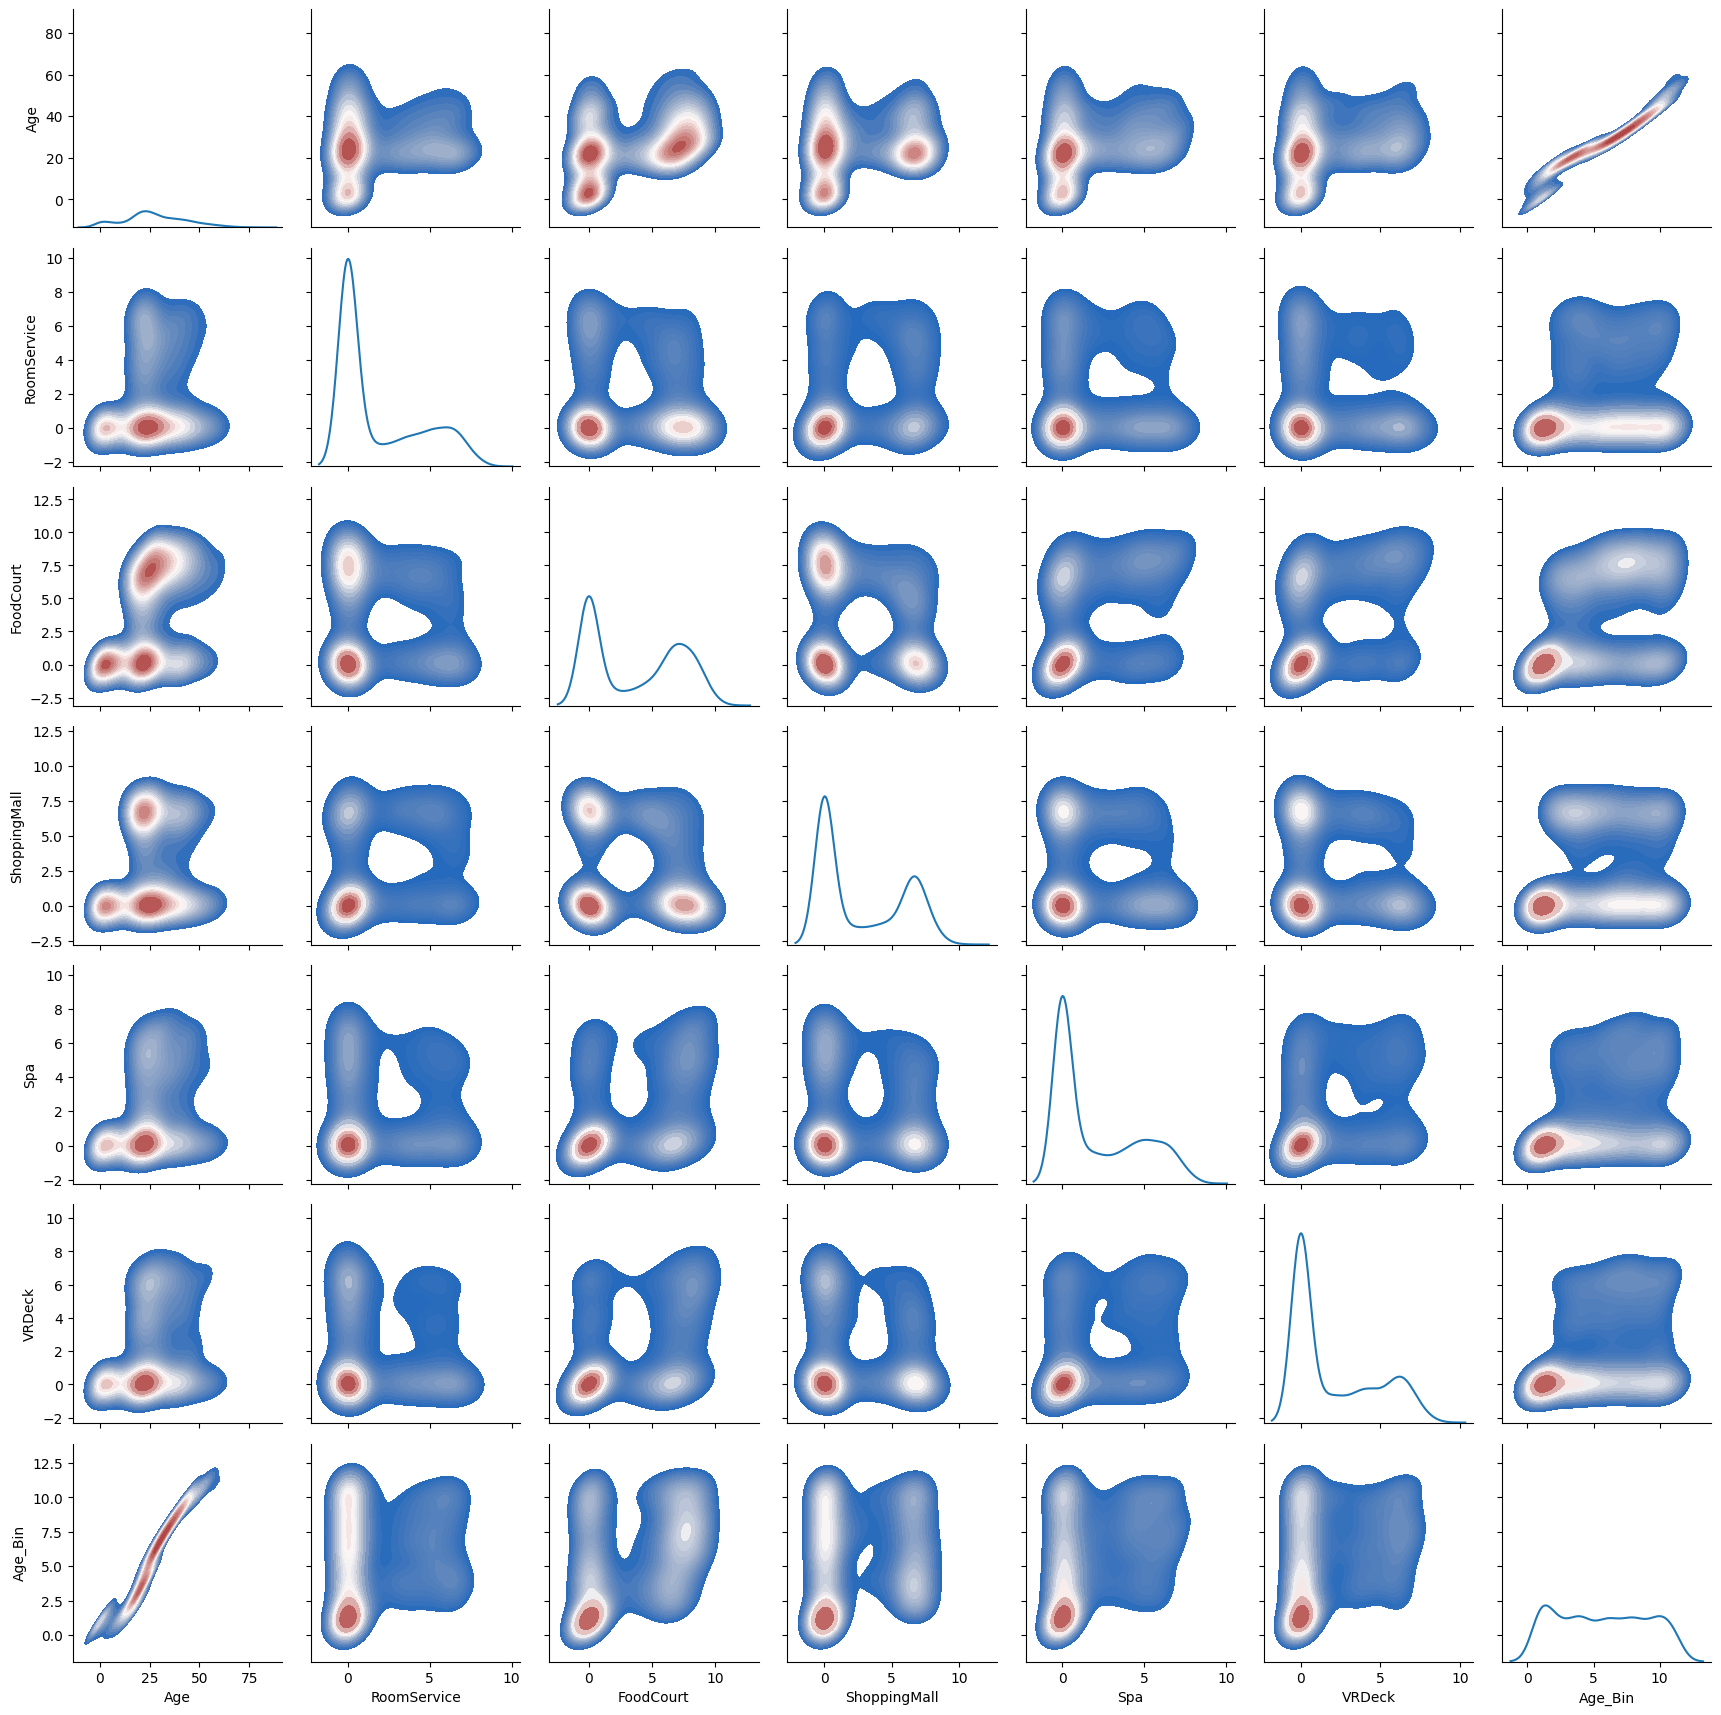

In [30]:
PairGrid_kde(dfn[dfn.Transported == True], num_features + ['Age_Bin'])

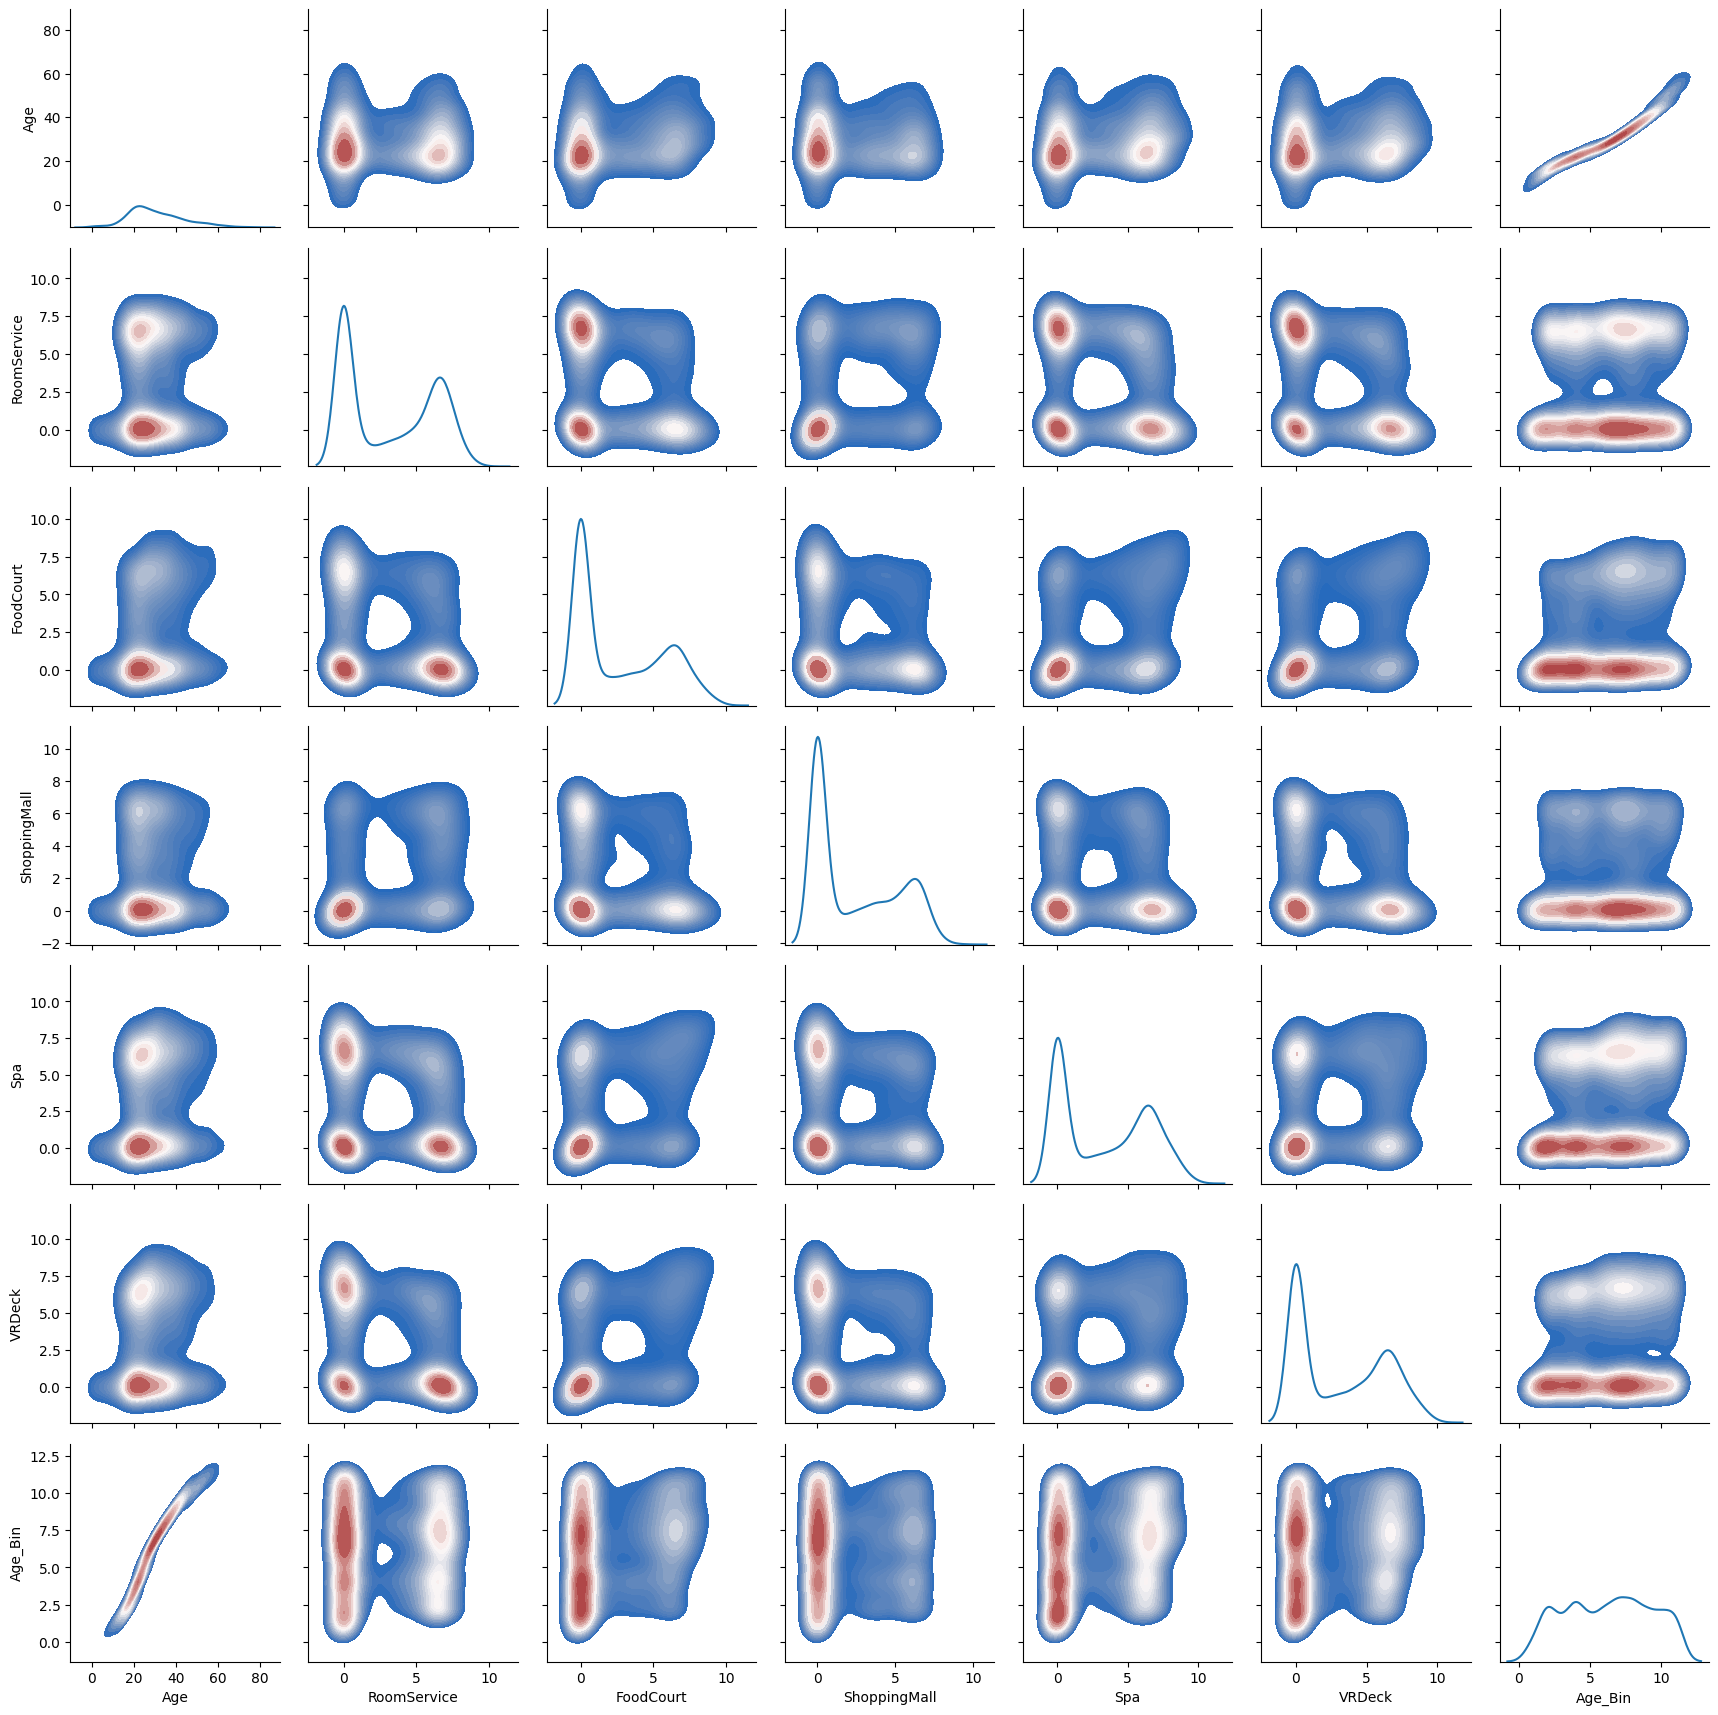

In [31]:
PairGrid_kde(dfn[dfn.Transported == False], num_features + ['Age_Bin'])

In [32]:
MI_matrix, MI_matrix_T, MI_matrix_NT, MI_min, MI_max = Get_MI_Matrices(dfn, num_features, 'Transported', classif = False)

Age  RoomService  FoodCourt  ShoppingMall       Spa  \
Age           0.000000     0.060615   0.072485      0.054224  0.084890   
RoomService   0.076682     0.000000   0.044785      0.051317  0.033678   
FoodCourt     0.085113     0.051903   0.000000      0.027779  0.069231   
ShoppingMall  0.064836     0.052606   0.026444      0.000000  0.030734   
Spa           0.089534     0.044098   0.064425      0.029525  0.000000   
VRDeck        0.079907     0.032131   0.101922      0.029936  0.048485   

                VRDeck  
Age           0.071414  
RoomService   0.032990  
FoodCourt     0.082154  
ShoppingMall  0.025704  
Spa           0.054286  
VRDeck        0.000000

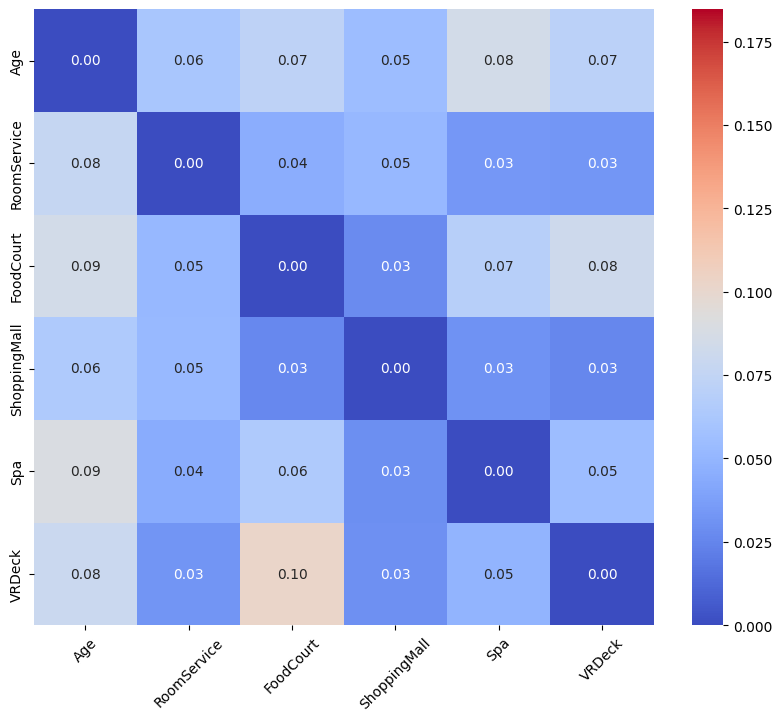

In [33]:
display(MI_matrix)
Plot_MI_Heatmap(MI_matrix, MI_min, MI_max)

Age  RoomService  FoodCourt  ShoppingMall       Spa  \
Age           0.000000     0.103165   0.166236      0.124959  0.136102   
RoomService   0.100074     0.000000   0.050110      0.071154  0.037802   
FoodCourt     0.184699     0.042599   0.000000      0.096010  0.103834   
ShoppingMall  0.117717     0.059441   0.084787      0.000000  0.049205   
Spa           0.149947     0.005862   0.107703      0.046520  0.000000   
VRDeck        0.112217     0.004992   0.130908      0.021414  0.058799   

                VRDeck  
Age           0.085257  
RoomService   0.015113  
FoodCourt     0.126171  
ShoppingMall  0.036173  
Spa           0.071207  
VRDeck        0.000000

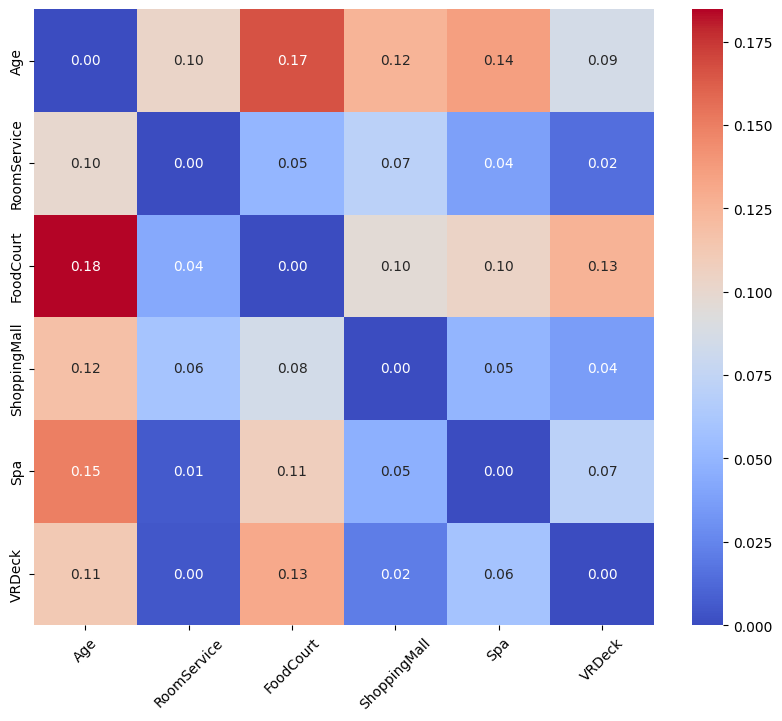

In [34]:
display(MI_matrix_T)
Plot_MI_Heatmap(MI_matrix_T, MI_min, MI_max)

Age  RoomService  FoodCourt  ShoppingMall       Spa  \
Age           0.000000     0.023815   0.041457      0.010725  0.043731   
RoomService   0.022143     0.000000   0.021256      0.061462  0.069871   
FoodCourt     0.028542     0.031335   0.000000      0.007309  0.083511   
ShoppingMall  0.018356     0.065212   0.019910      0.000000  0.035225   
Spa           0.043569     0.072461   0.077509      0.036761  0.000000   
VRDeck        0.040544     0.055386   0.111427      0.008326  0.062870   

                VRDeck  
Age           0.041957  
RoomService   0.081133  
FoodCourt     0.105978  
ShoppingMall  0.025237  
Spa           0.063604  
VRDeck        0.000000

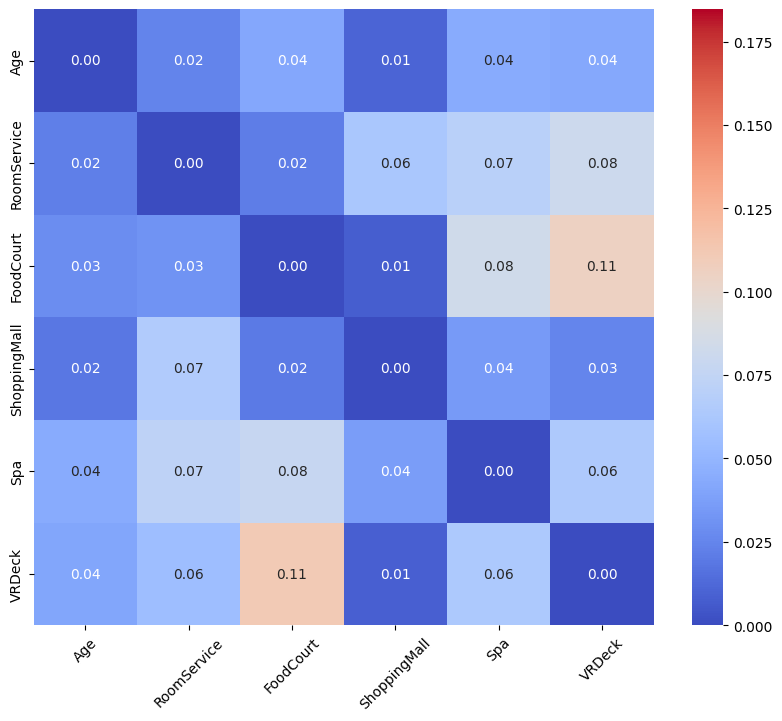

In [35]:
display(MI_matrix_NT)
Plot_MI_Heatmap(MI_matrix_NT, MI_min, MI_max)

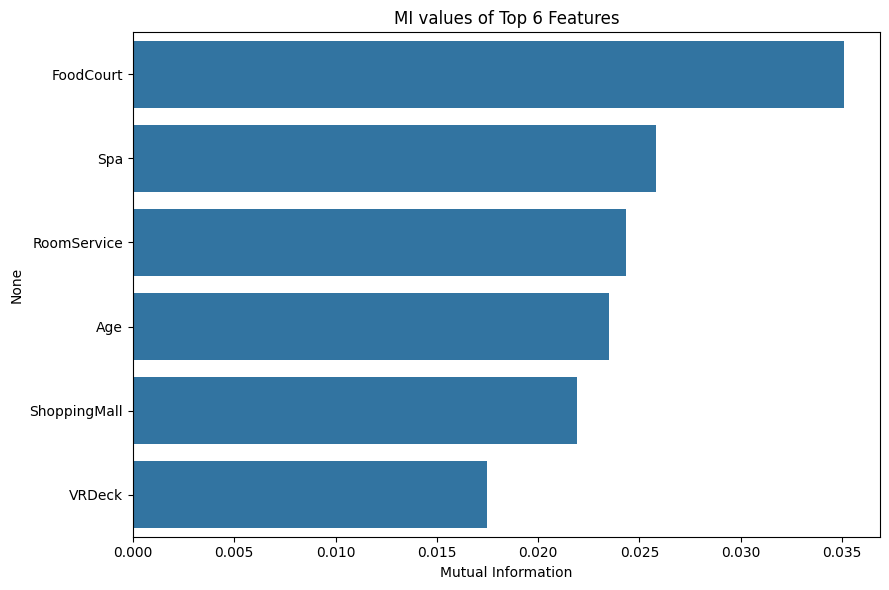

In [36]:
X = dfn.drop(columns = ['Transported', 'Age_Bin'])
y = dfn['Transported']
MI = pd.Series(mutual_info_classif(X, y), index = X.columns.tolist()).sort_values(ascending = False)
Plot_MI(MI, topk = len(MI), bottom = False)

## Observations
* Passengers under Age of 13 do not spend on Luxury items
* Luxury items have a bimodal distribution. Most passengers either spend very little or a lot on Luxury items.
* Spending on VRDeck, Spa, or RoomService decreases the chance of a passenger being transported
* There is higher mutual information between Age and Luxury features among Transported Passengers (who are not in CryoSleep) than among those not transported, particularly mutual information between Age and FoodCourt

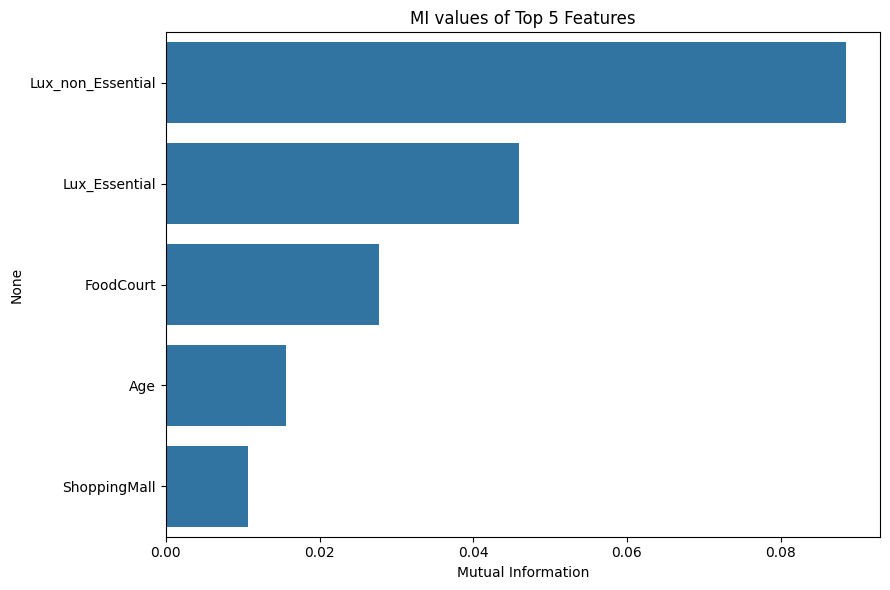

In [37]:
dfn2 = dfn.dropna().copy()
Non_Essential_Lux_Features = ['RoomService', 'Spa', 'VRDeck']
Essential_Lux_Features = ['FoodCourt', 'ShoppingMall']
dfn2['Lux_non_Essential'] = dfn2[Non_Essential_Lux_Features].mean(axis = 1)
dfn2['Lux_Essential'] = dfn2[Essential_Lux_Features].mean(axis = 1)
dfn2.drop(columns = Non_Essential_Lux_Features, inplace = True)

X = dfn2.drop(columns = ['Transported', 'Age_Bin'])
y = dfn2['Transported']
MI = pd.Series(mutual_info_classif(X, y), index = X.columns.tolist()).sort_values(ascending = False)
Plot_MI(MI, topk = len(MI), bottom = False)

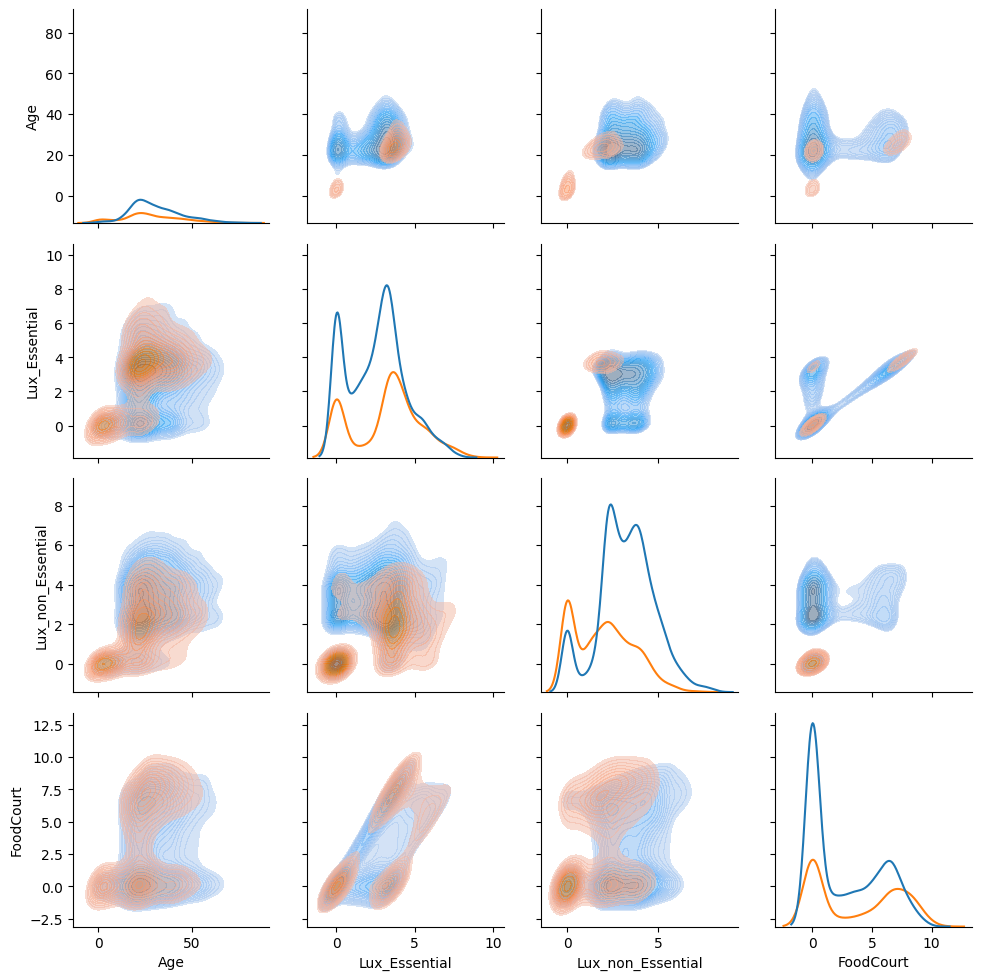

In [38]:
PairGrid_kde(dfn2, ['Age', 'Lux_Essential', 'Lux_non_Essential', 'FoodCourt'], hue = 'Transported')

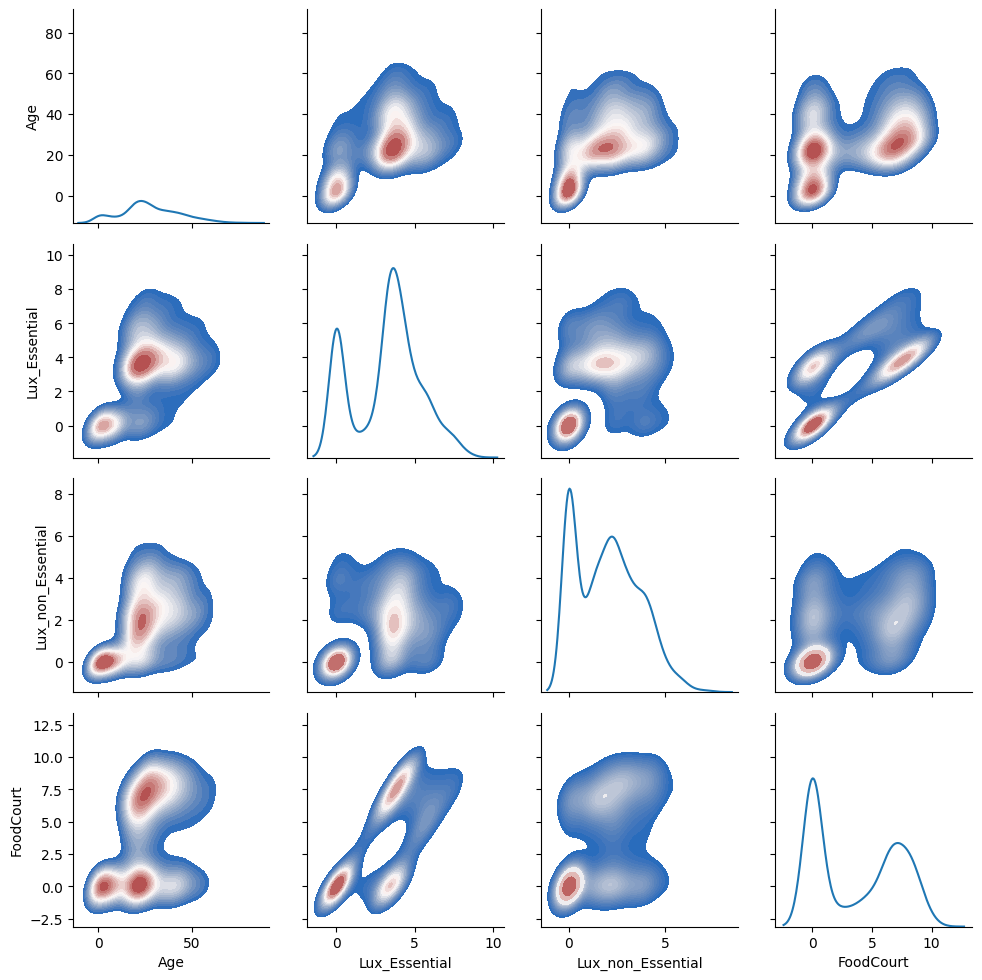

In [39]:
PairGrid_kde(dfn2[dfn.Transported == True], ['Age', 'Lux_Essential', 'Lux_non_Essential', 'FoodCourt'])

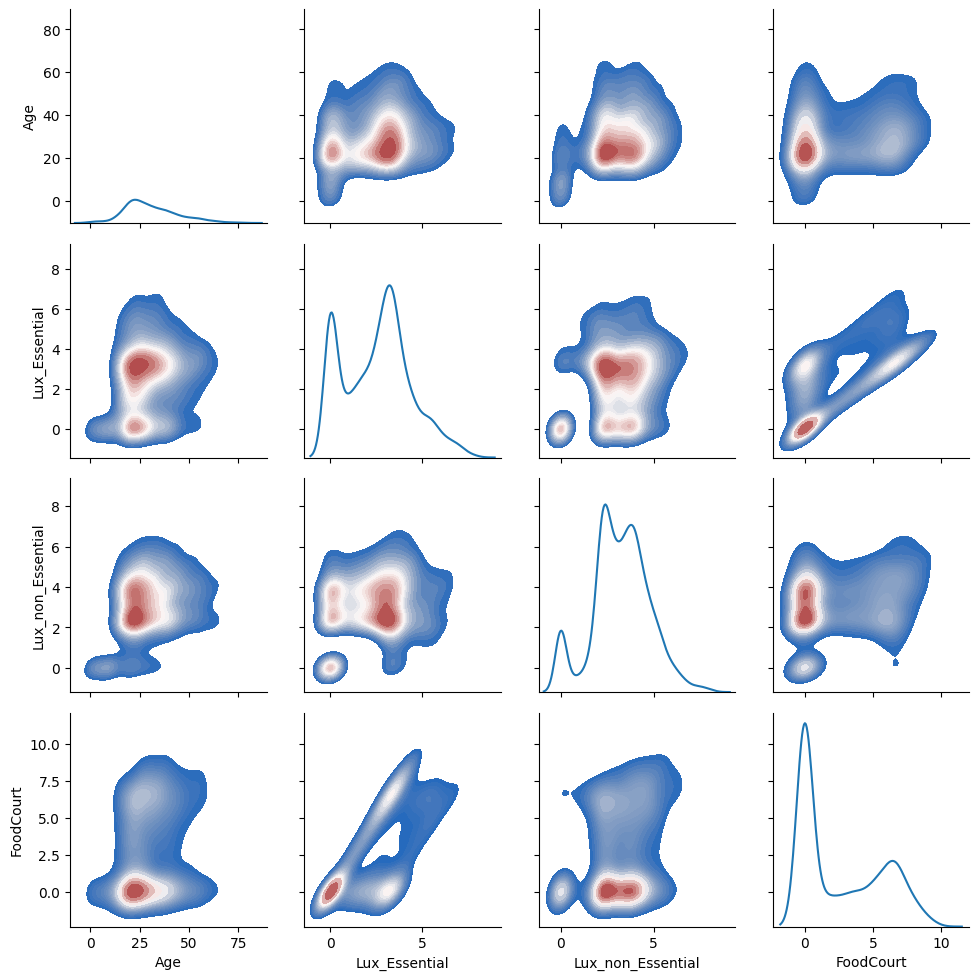

In [40]:
PairGrid_kde(dfn2[dfn.Transported == False], ['Age', 'Lux_Essential', 'Lux_non_Essential', 'FoodCourt'])

# Categorical Features

In [41]:
Cat_Features = ['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP', 'Name']

In [42]:
for col in Cat_Features:
    print(col, len(df[col].dropna()), df[col].dropna().nunique())

PassengerId 8693 8693
HomePlanet 8492 3
CryoSleep 8476 2
Cabin 8494 6560
Destination 8511 3
VIP 8490 2
Name 8493 8473


In [43]:
name_count = df.Name.value_counts()
dupl_values = name_count[name_count > 1].index.to_list()
df[df.Name.isin(dupl_values)].sort_values(by = 'Name')

PassengerId HomePlanet CryoSleep     Cabin    Destination   Age    VIP  \
7270     7775_01     Europa     False   C/253/P    55 Cancri e  28.0  False   
6296     6665_01     Europa      True   B/222/P    55 Cancri e  17.0  False   
476      0512_02     Europa      True    D/18/S    TRAPPIST-1e  55.0  False   
2930     3176_01     Europa     False   E/196/P    TRAPPIST-1e  77.0  False   
8488     9071_01      Earth     False  F/1855/P    55 Cancri e  22.0  False   
2991     3236_03      Earth     False   E/200/P    TRAPPIST-1e  18.0  False   
2559     2746_01       Mars     False   F/569/P    TRAPPIST-1e  52.0  False   
4108     4387_01       Mars     False   F/902/P  PSO J318.5-22  32.0  False   
7871     8398_01     Europa      True   B/329/S    TRAPPIST-1e  15.0  False   
6086     6432_01     Europa     False   D/202/P    55 Cancri e  55.0  False   
7862     8384_01      Earth     False  F/1722/P    TRAPPIST-1e  20.0  False   
5463     5824_01      Earth      True   G/940/P    55 Cancri e  20.0  False   
6987     7429_01       Mars     False       NaN    TRAPPIST-1e  38.0  False   
6171     6513_01       Mars     False  F/1244/S    TRAPPIST-1e  20.0  False   
1795     1911_01      Earth     False   G/300/S    TRAPPIST-1e  46.0  False   
4392     4663_02      Earth      True   G/765/S    TRAPPIST-1e   1.0  False   
156      0179_01      Earth     False    G/26/P    TRAPPIST-1e  19.0  False   
956      1018_01      Earth      True   G/150/P    TRAPPIST-1e  18.0  False   
6702     7073_01      Earth      True  G/1161/S    TRAPPIST-1e  40.0  False   
8002     8560_01      Earth      True  G/1391/P    55 Cancri e  18.0  False   
3411     3677_01      Earth     False   F/694/S  PSO J318.5-22  24.0  False   
2241     2402_01      Earth      True   G/389/P    TRAPPIST-1e  13.0  False   
2852     3081_01     Europa     False   C/118/S    55 Cancri e  50.0  False   
827      0881_01     Europa     False    D/32/S    TRAPPIST-1e  41.0  False   
3291     3535_02       Mars      True   F/668/S    TRAPPIST-1e  25.0  False   
838      0901_01       Mars     False   F/167/S    TRAPPIST-1e  32.0  False   
1292     1375_02      Earth     False   F/267/S    TRAPPIST-1e  19.0  False   
3309     3555_01      Earth     False   F/735/P    TRAPPIST-1e  28.0  False   
3534     3789_01      Earth      True   G/620/S    TRAPPIST-1e  15.0  False   
7495     8018_01      Earth     False  F/1532/S    TRAPPIST-1e  54.0  False   
5432     5808_01      Earth     False   G/934/P    TRAPPIST-1e   2.0  False   
220      0234_01      Earth     False    F/50/P    TRAPPIST-1e  43.0  False   
7650     8164_01      Earth     False  G/1314/S    TRAPPIST-1e  31.0  False   
4730     5050_01      Earth     False  F/1028/P    TRAPPIST-1e  31.0  False   
1812     1935_01      Earth      True   G/307/S    55 Cancri e  18.0  False   
2700     2892_03      Earth      True   G/469/P    55 Cancri e   0.0  False   
2883     3118_01      Earth      True   G/510/P    TRAPPIST-1e  28.0  False   
4217     4493_01      Earth     False   F/845/S    TRAPPIST-1e  26.0  False   
1737     1850_01      Earth     False   F/356/S  PSO J318.5-22  54.0  False   
3381     3640_02      Earth      True   G/589/S    TRAPPIST-1e  41.0  False   

      RoomService  FoodCourt  ShoppingMall       Spa    VRDeck  \
7270     2.079442   6.194405      0.000000  1.609438  8.704171   
6296     0.000000   0.000000      0.000000  0.000000  0.000000   
476      0.000000   0.000000      0.000000  0.000000  0.000000   
2930     0.000000   9.108640      0.000000  4.859812  7.289611   
8488     0.000000   0.000000      6.978214  3.850148  1.386294   
2991     0.000000   3.433987      0.000000  6.629363  1.791759   
2559     6.632002   0.000000      5.877736  1.791759  0.000000   
4108     5.262690   0.000000      6.091310  2.944439  0.000000   
7871     0.000000   0.000000      0.000000  0.000000  0.000000   
6086     4.744932   5.407172      0.000000  7.853993  7.979339   
7862     0.000000   0.000000      0.000

In [44]:
df2 = df.copy()
df_split = df2.Cabin.str.split("/", expand = True).rename({0: 'deck', 1: 'Cabin Number', 2: 'side'}, axis = 1)
df2 = pd.concat([df2, df_split], axis = 1)
df_split = df2.Name.str.split(" ", expand = True).rename({0: 'First Name', 1: 'Last Name'}, axis = 1)
df2 = pd.concat([df2, df_split], axis = 1)
df2 = df2.drop(columns = ['Cabin', 'Name'])
df2

PassengerId HomePlanet CryoSleep    Destination   Age    VIP  \
0        0001_01     Europa     False    TRAPPIST-1e  39.0  False   
1        0002_01      Earth     False    TRAPPIST-1e  24.0  False   
2        0003_01     Europa     False    TRAPPIST-1e  58.0   True   
3        0003_02     Europa     False    TRAPPIST-1e  33.0  False   
4        0004_01      Earth     False    TRAPPIST-1e  16.0  False   
...          ...        ...       ...            ...   ...    ...   
8688     9276_01     Europa     False    55 Cancri e  41.0   True   
8689     9278_01      Earth      True  PSO J318.5-22  18.0  False   
8690     9279_01      Earth     False    TRAPPIST-1e  26.0  False   
8691     9280_01     Europa     False    55 Cancri e  32.0  False   
8692     9280_02     Europa     False    TRAPPIST-1e  44.0  False   

      RoomService  FoodCourt  ShoppingMall       Spa    VRDeck  Transported  \
0        0.000000   0.000000      0.000000  0.000000  0.000000        False   
1        4.700480   2.302585      3.258097  6.309918  3.806662         True   
2        3.784190   8.182280      0.000000  8.812248  3.912023        False   
3        0.000000   7.157735      5.918894  8.110728  5.267858        False   
4        5.717028   4.262680      5.023881  6.338594  1.098612         True   
...           ...        ...           ...       ...       ...          ...   
8688     0.000000   8.827615      0.000000  7.404888  4.317488        False   
8689     0.000000   0.000000      0.000000  0.000000  0.000000        False   
8690     0.000000   0.000000      7.535297  0.693147  0.000000         True   
8691     0.000000   6.956545      0.000000  5.869297  8.082093        False   
8692     4.844187   8.452975      0.000000  0.000000  2.564949         True   

     Age_Bin deck Cabin Number side First Name    Last Name  
0          9    B            0    P      Maham    Ofracculy  
1          5    F            0    S     Juanna        Vines  
2         11    A            0    S     Altark       Susent  
3          8    A            0    S      Solam       Susent  
4          2    F            1    S      Willy  Santantines  
...      ...  ...          ...  ...        ...          ...  
8688       9    A           98    P    Gravior    Noxnuther  
8689       2    G         1499    S      Kurta    Mondalley  
8690       6    G         1500    S      Fayey       Connon  
8691       7    E          608    S     Celeon    Hontichre  
8692      10    E          608    S     Propsh    Hontichre  

[8693 rows x 18 columns]

In [45]:
for col in ['deck', 'Cabin Number', 'side', 'First Name', 'Last Name']:
    print(col, len(df2[col].dropna()), df2[col].dropna().nunique())

deck 8494 8
Cabin Number 8494 1817
side 8494 2
First Name 8493 2706
Last Name 8493 2217


#### For now, we can ignore Name, PassengerId, and Cabin Number since they have high cardinality

In [46]:
Categorical_Features = ['HomePlanet', 'Destination', 'VIP', 'CryoSleep', 'deck', 'side', 'Age_Bin']

In [47]:
# import Visualization_Functions
# importlib.reload(Visualization_Functions)
# from Visualization_Functions import Gridplot_Hists

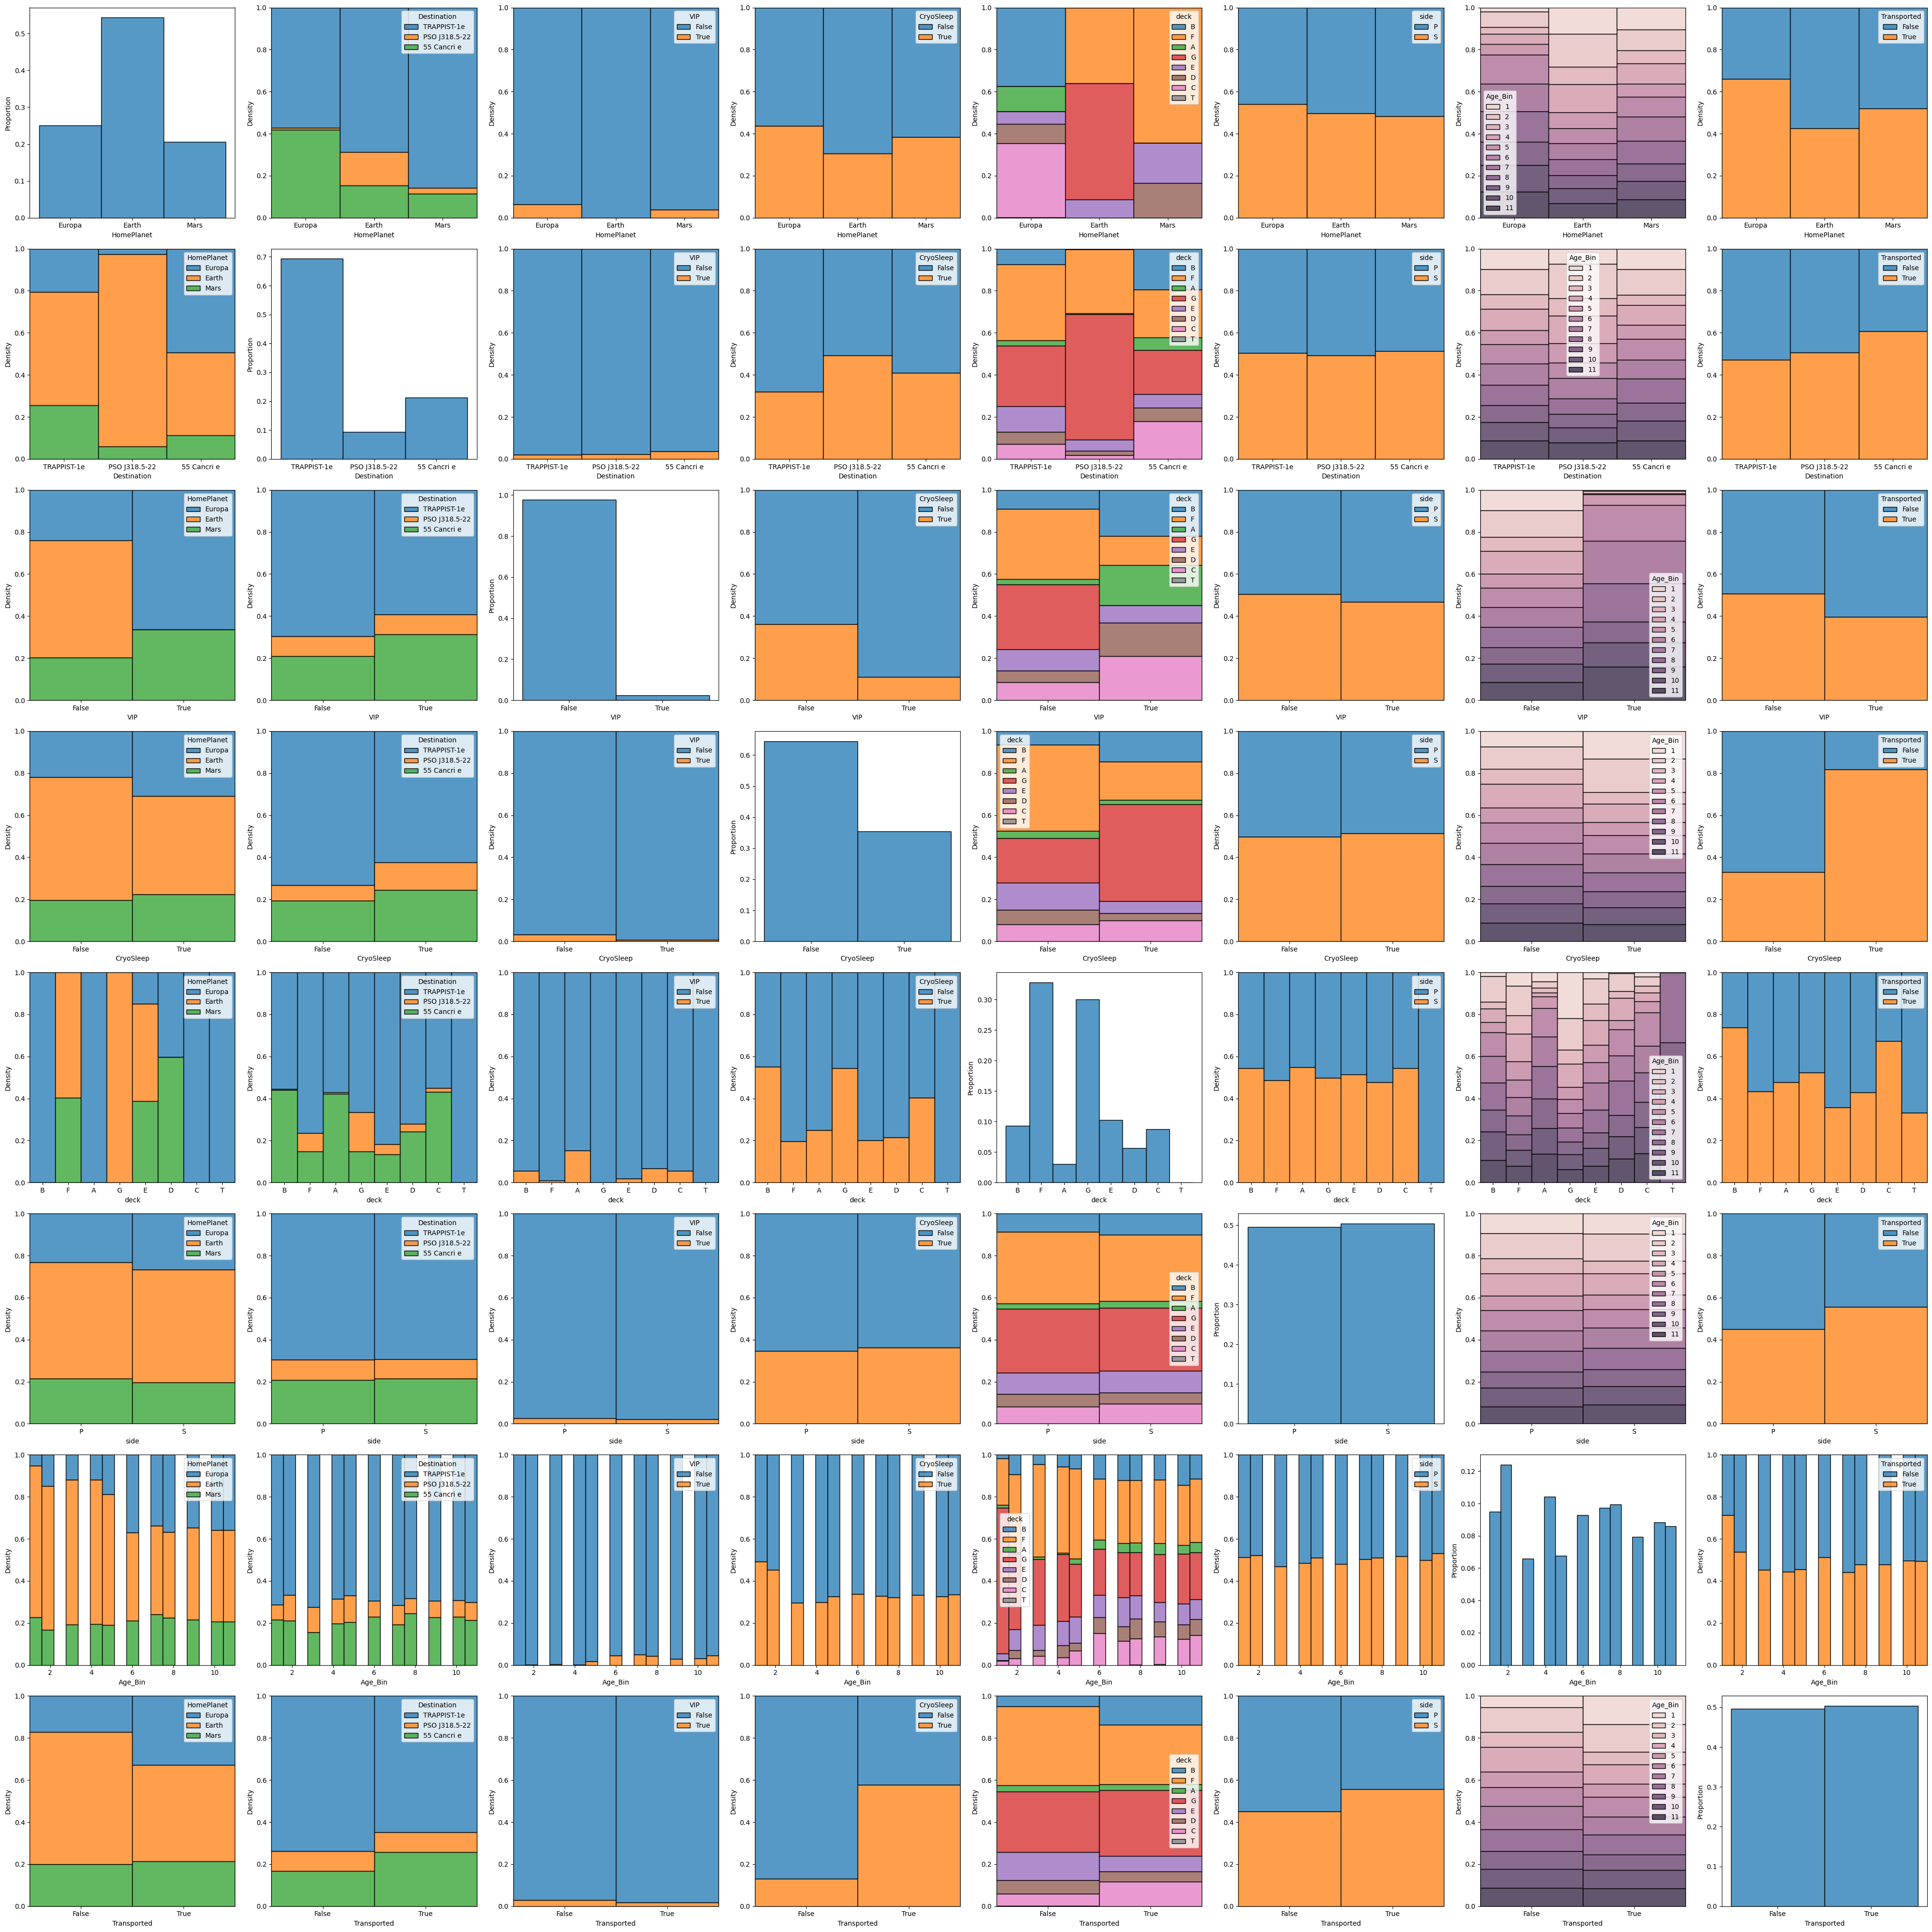

In [48]:
Gridplot_Hists(df2, Categorical_Features + ['Transported'])

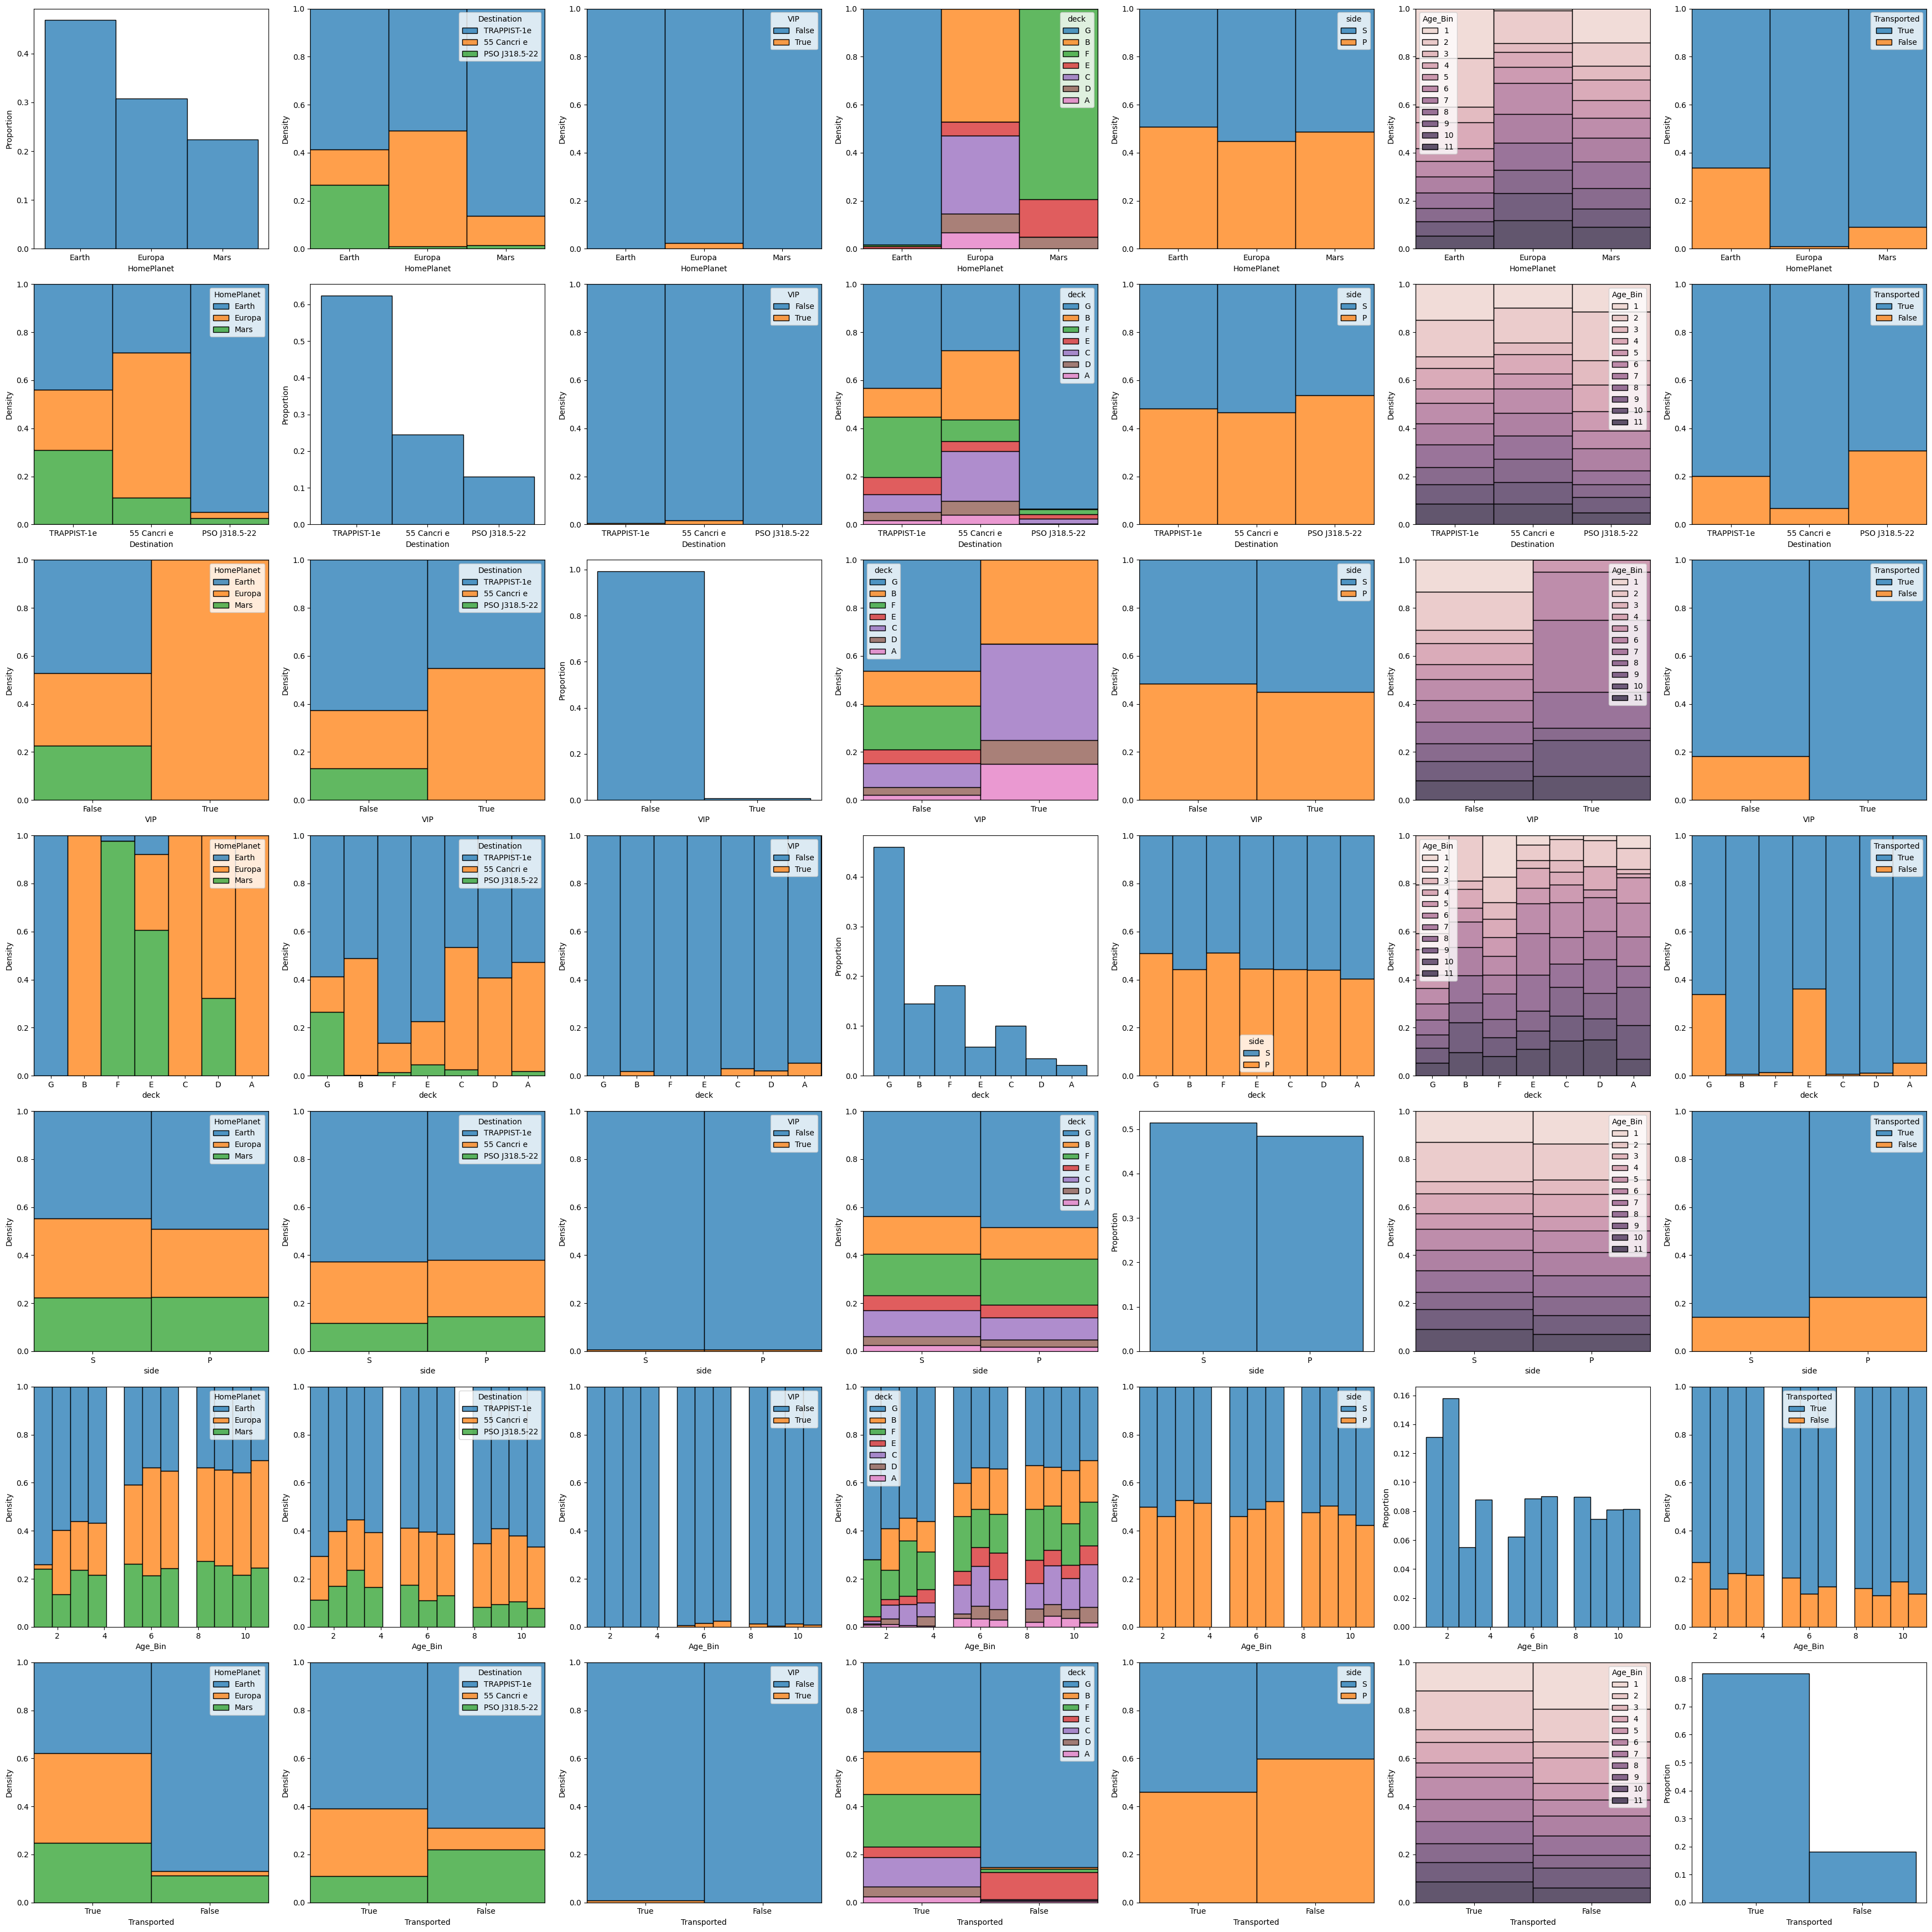

In [49]:
Gridplot_Hists(df2[df2.CryoSleep == True], [c for c in Categorical_Features if c != 'CryoSleep'] + ['Transported'])

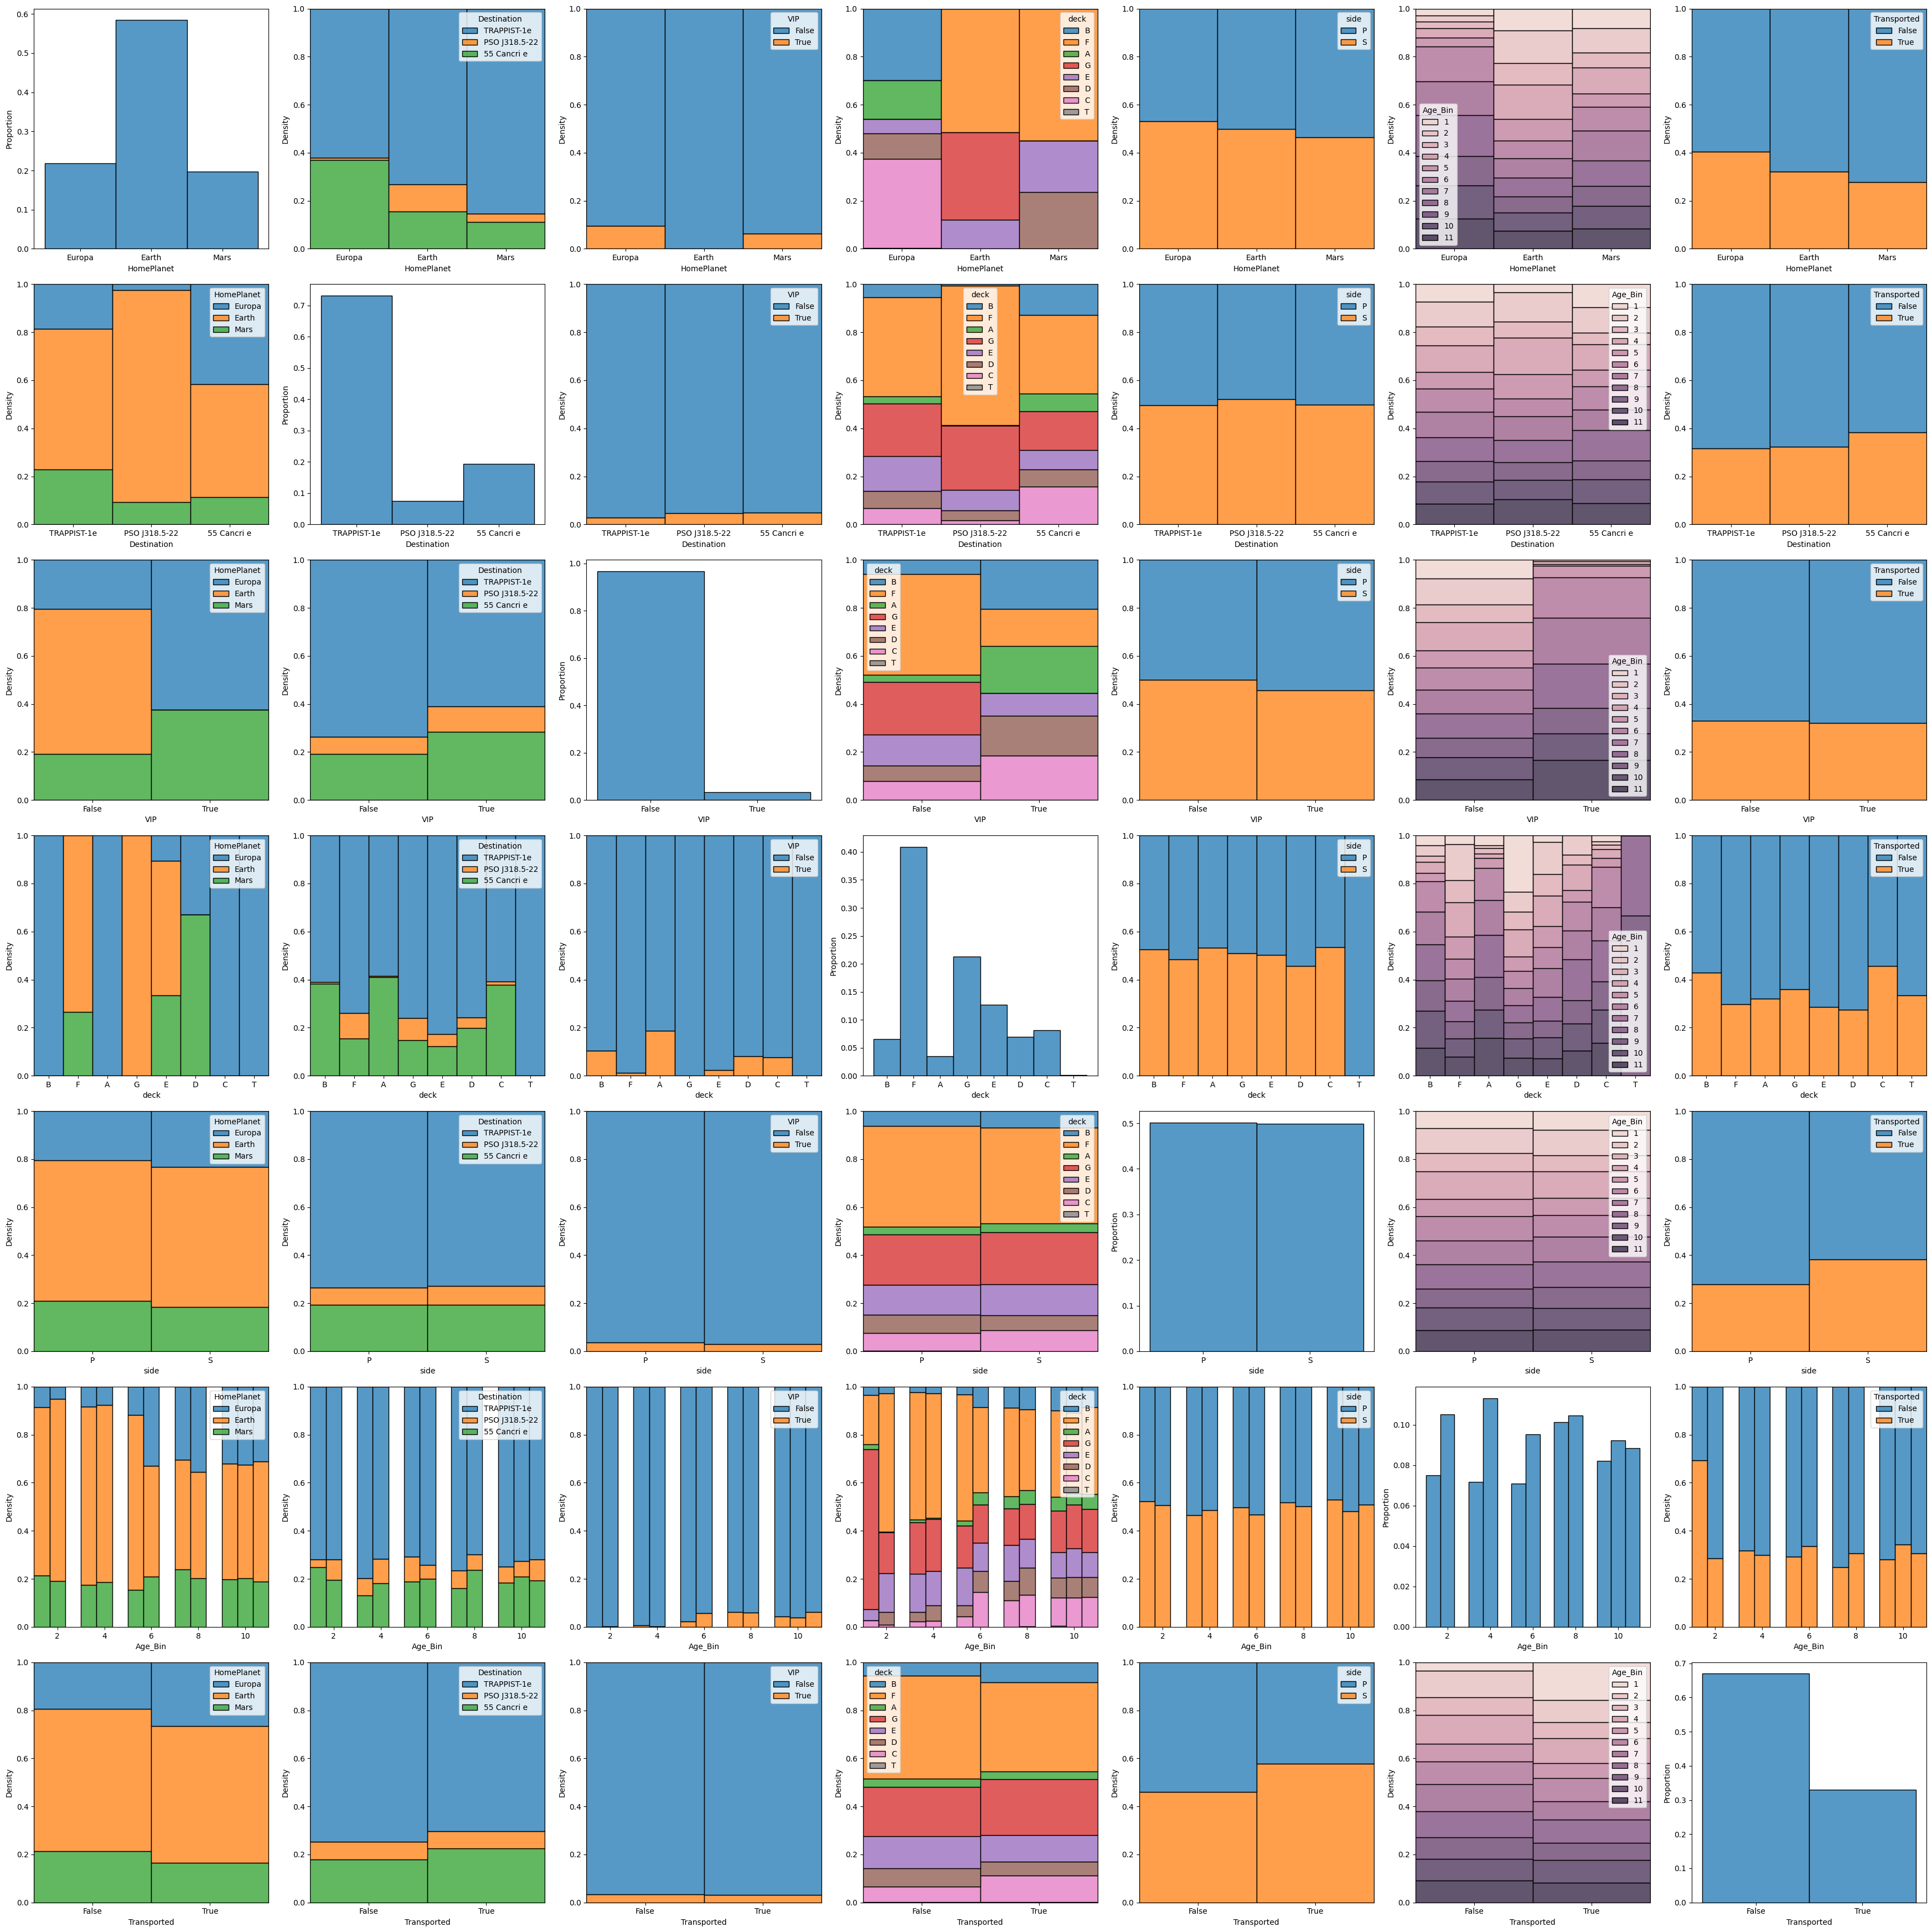

In [50]:
Gridplot_Hists(df2[df2.CryoSleep == False], [c for c in Categorical_Features if c != 'CryoSleep'] + ['Transported'])

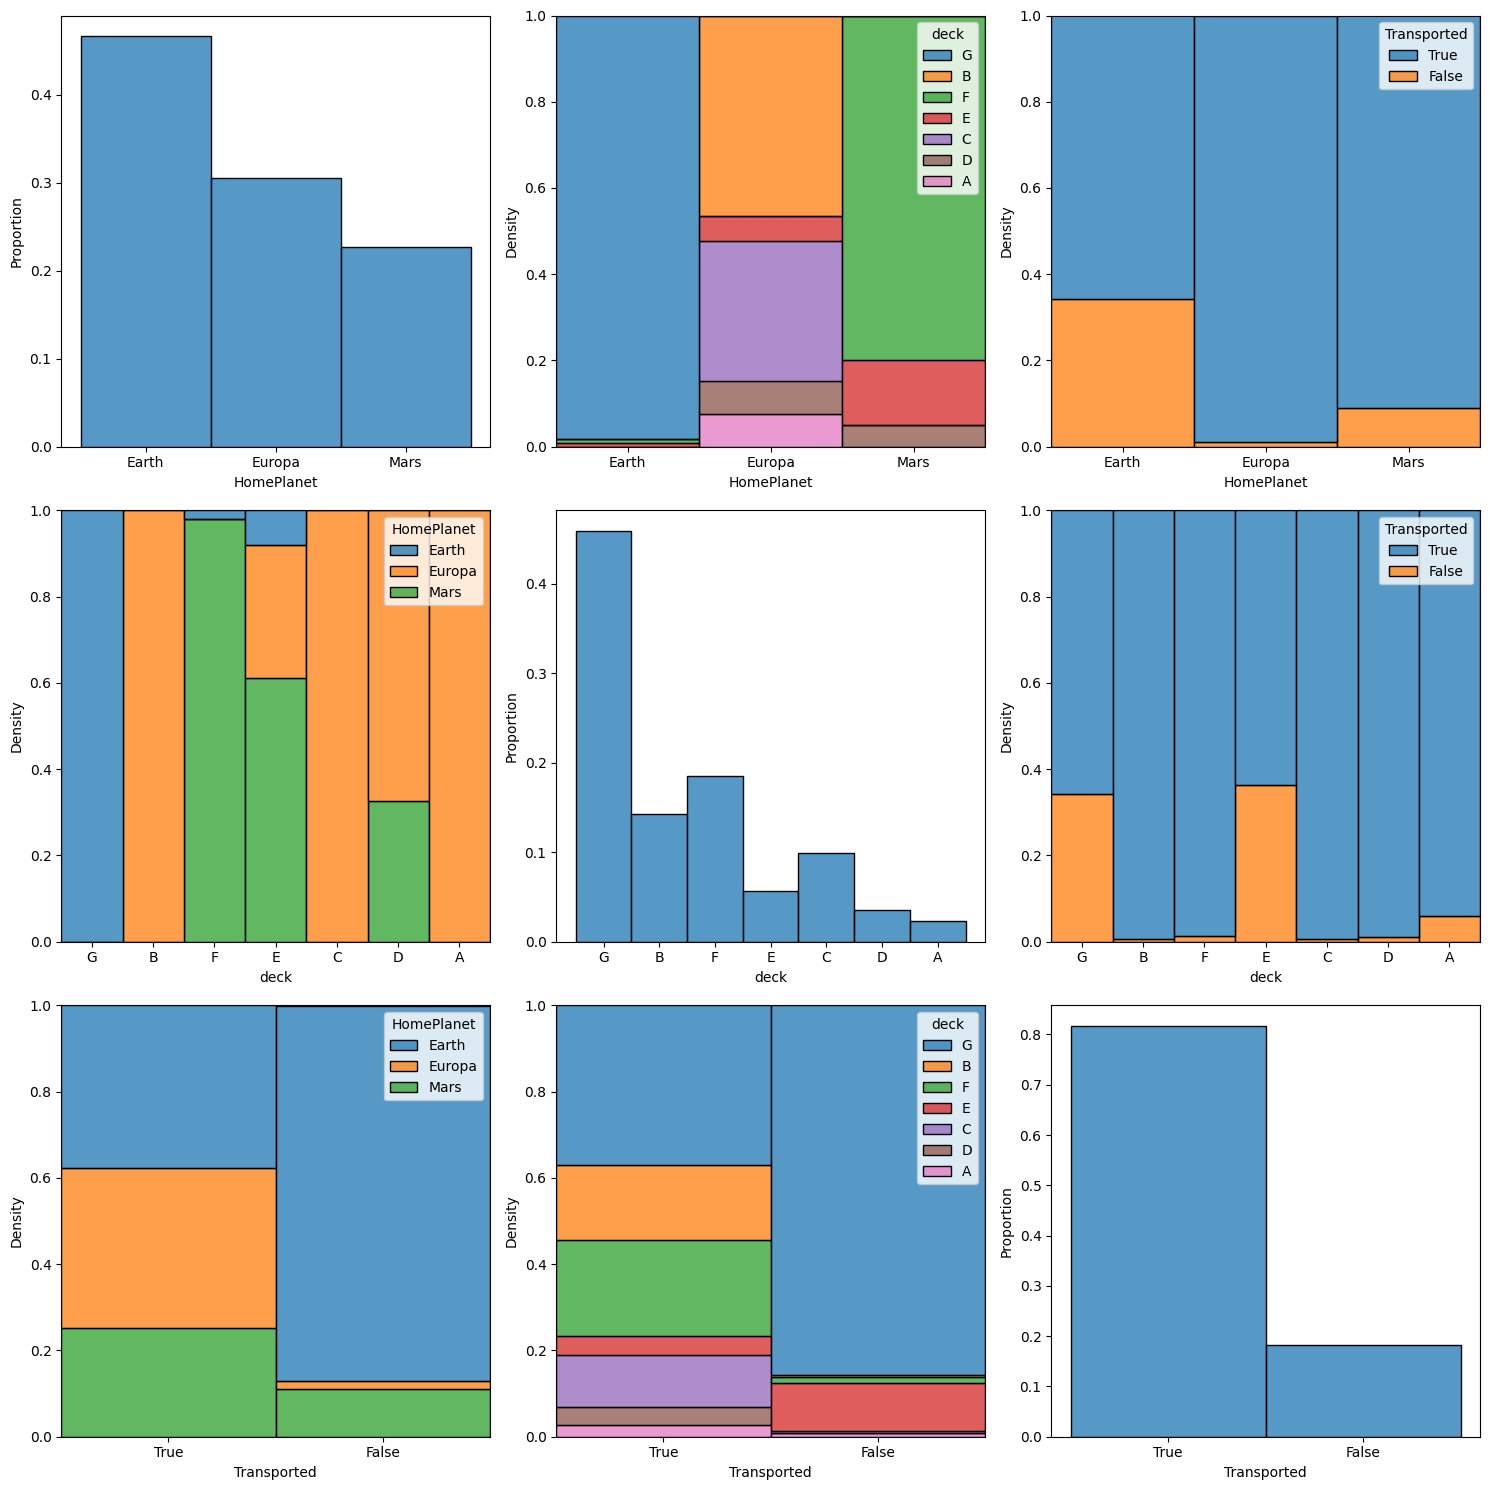

In [51]:
Gridplot_Hists(df2[df2.CryoSleep == True], ['HomePlanet', 'deck', 'Transported'])

In [52]:
df3 = df2[['HomePlanet', 'Age', 'Age_Bin', 'CryoSleep', 'deck']].dropna().copy()
for Planet in ['Earth', 'Mars', 'Europa']:
    print(Planet, len(df3[(df3.HomePlanet == Planet) & (df3.Age < 25)])/len(df3[df3.HomePlanet == Planet]), len(df3[(df3.Age < 25) & (df3.CryoSleep == True) & (df3.HomePlanet == Planet)])/len(df3[(df3.Age < 25) & (df3.HomePlanet == Planet)]))

Earth 0.5524118738404453 0.33711167086481947
Mars 0.39133089133089133 0.40717628705148207
Europa 0.18689690198070086 0.6114130434782609


In [53]:
df4 = df3[df3.CryoSleep == True]
for Planet in ['Earth', 'Mars', 'Europa']:
    print(Planet, len(df4[(df4.HomePlanet == Planet) & (df4.Age < 25)])/len(df4[df4.HomePlanet == Planet]))

Earth 0.613914373088685
Mars 0.41037735849056606
Europa 0.2619324796274738


In [54]:
len(df3[(df3.HomePlanet == 'Europa') & (df3.Age_Bin > 5)])/len(df3[df3.HomePlanet == 'Europa'])

0.7760284408329101

In [55]:
Planet = 'Earth'
for deck in ['E', 'F', 'G']:
    print(deck, len(df3[(df3.HomePlanet == Planet) & (df3.deck == deck)])/len(df3[df3.HomePlanet == Planet]), 
          len(df3[(df3.HomePlanet == Planet) & (df3.deck == deck) & (df3.CryoSleep == True)])/len(df3[(df3.HomePlanet == Planet) & (df3.CryoSleep == True)]))

E 0.08789424860853433 0.009174311926605505
F 0.3608534322820037 0.008409785932721712
G 0.5512523191094619 0.9824159021406728


In [56]:
Planet = 'Mars'
for deck in ['D', 'E', 'F']:
    print(deck, len(df3[(df3.HomePlanet == Planet) & (df3.deck == deck)])/len(df3[df3.HomePlanet == Planet]), 
          len(df3[(df3.HomePlanet == Planet) & (df3.deck == deck) & (df3.CryoSleep == True)])/len(df3[(df3.HomePlanet == Planet) & (df3.CryoSleep == True)]))

D 0.16544566544566544 0.04874213836477988
E 0.19108669108669107 0.15251572327044025
F 0.6434676434676435 0.7987421383647799


In [57]:
Planet = 'Europa'
for deck in ['A', 'B', 'C', 'D', 'E', 'T']:
    print(deck, len(df3[(df3.HomePlanet == Planet) & (df3.deck == deck)])/len(df3[df3.HomePlanet == Planet]), 
          len(df3[(df3.HomePlanet == Planet) & (df3.deck == deck) & (df3.CryoSleep == True)])/len(df3[(df3.HomePlanet == Planet) & (df3.CryoSleep == True)]))

A 0.12087353986795328 0.07217694994179279
B 0.3727780599288979 0.470314318975553
C 0.3534789233113255 0.3259604190919674
D 0.0898933468765871 0.07334109429569266
E 0.061452513966480445 0.05820721769499418
T 0.0015236160487557136 0.0


## Obeservations
* More than half of passengers are from Homeplanet Earth
* Passengers on deck G are all from Earth
* Passengers from Earth are on decks G (55%), F (36%), & E (9%)
* The overwhelming majority of passengers from Earth that are in CryoSleep are on deck G (~98%)
* Passengers from Mars are on decks F (64%), E (19%), & D (17%)
* The majority of passengers from Mars that are in Cryosleep are on deck F (80%) with most of the remaining on deck E (15%), and only 5% on deck D
* Passengers on decks A, B, C, T are all from Europa
* Other than decks A (12%), B (37%), C (35%), T (0.15%), passengers from Europa can also be on decks D (9%) or E (6%)
* All passengers on deck T are from Europa, Destination TRAPPIST-1e, VIP = False. There are very few passengers on deck T though.
* Passengers from Earth are less likely to be in Cryosleep than passengers from Europa and Mars, and more likely to be young (~54% og passengers from Earth are under the age of 25 while only 19% of passengers from Europa and 38% of passengers from Mars are under the age of 25. Note, however, that the Homeplanet age distribution differ by Cryosleep status. For example, among passengers in cryosleep, 64% of passengers from Earth are under the age of 25.
* Europa passengers tend to be older

In [58]:
dfc = df2[Categorical_Features + ['Transported']].dropna().copy()

binary_features = ['VIP', 'CryoSleep']
cat_features = ['HomePlanet', 'Destination', 'deck', 'side', 'Age_Bin']

dfc[binary_features] = dfc[binary_features].astype(int)

encoders = {}
for col in cat_features:
    le = LabelEncoder()
    dfc[col] = le.fit_transform(dfc[col].astype(str))
    encoders[col] = le

# encoders['HomePlanet'].inverse_transform(dfc['HomePlanet'])

In [59]:
MI_matrix, MI_matrix_T, MI_matrix_NT, MI_min, MI_max = Get_MI_Matrices(dfc, Categorical_Features, 'Transported')

HomePlanet  Destination       VIP  CryoSleep      deck      side  \
HomePlanet     0.000000     0.065129  0.024499   0.010923  0.642334  0.005853   
Destination    0.066386     0.000000  0.002346   0.010140  0.057135  0.000000   
VIP            0.026618     0.000000  0.000000   0.003141  0.018900  0.000000   
CryoSleep      0.007519     0.012246  0.000759   0.000000  0.055588  0.000000   
deck           0.649196     0.063225  0.020040   0.059589  0.000000  0.000000   
side           0.000000     0.000768  0.008517   0.000000  0.008011  0.000000   
Age_Bin        0.057712     0.004498  0.011004   0.002440  0.062349  0.007101   

              Age_Bin  
HomePlanet   0.057079  
Destination  0.000000  
VIP          0.012647  
CryoSleep    0.000754  
deck         0.077311  
side         0.000000  
Age_Bin      0.000000

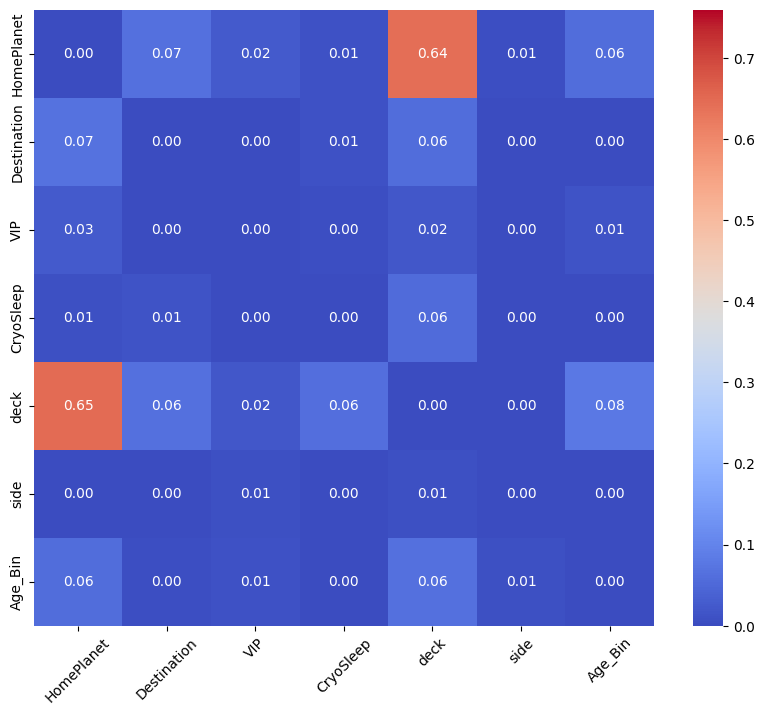

In [60]:
display(MI_matrix)
Plot_MI_Heatmap(MI_matrix, MI_min, MI_max)

HomePlanet  Destination       VIP  CryoSleep      deck      side  \
HomePlanet     0.000000     0.081998  0.023250   0.013331  0.748590  0.009898   
Destination    0.092641     0.000000  0.011816   0.019074  0.076729  0.000000   
VIP            0.016812     0.001420  0.000000   0.006898  0.016905  0.000000   
CryoSleep      0.007752     0.000000  0.000000   0.000000  0.045543  0.000000   
deck           0.759644     0.083117  0.001308   0.045581  0.000000  0.000000   
side           0.005190     0.008083  0.000000   0.000021  0.000000  0.000000   
Age_Bin        0.063720     0.000000  0.012116   0.000000  0.068301  0.013693   

              Age_Bin  
HomePlanet   0.053197  
Destination  0.005173  
VIP          0.008373  
CryoSleep    0.010092  
deck         0.094935  
side         0.000460  
Age_Bin      0.000000

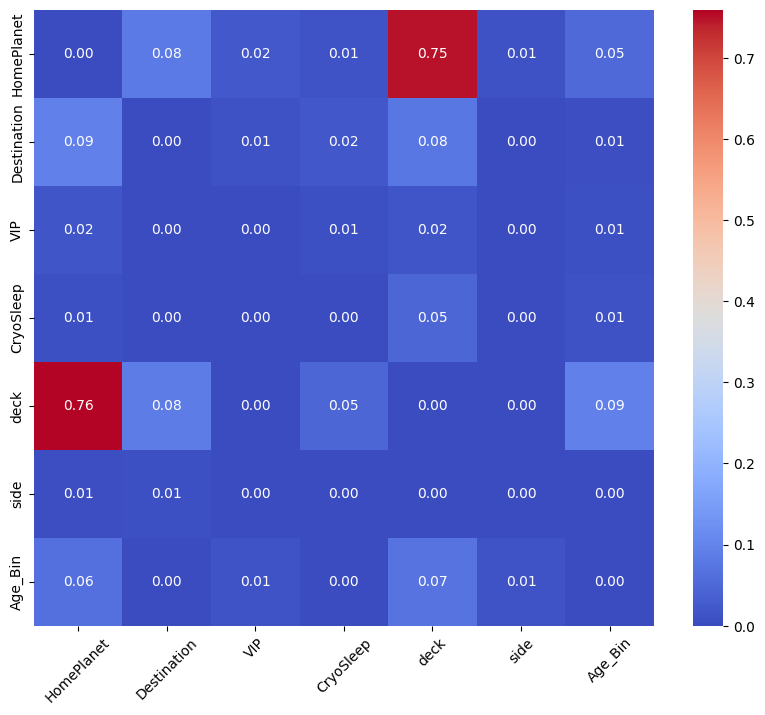

In [61]:
display(MI_matrix_T)
Plot_MI_Heatmap(MI_matrix_T, MI_min, MI_max)

HomePlanet  Destination       VIP  CryoSleep      deck      side  \
HomePlanet     0.000000     0.059281  0.014114   0.022376  0.528624  0.000000   
Destination    0.056592     0.000000  0.011590   0.011020  0.045976  0.012059   
VIP            0.030811     0.000005  0.000000   0.006030  0.024449  0.000000   
CryoSleep      0.015192     0.011092  0.008174   0.000000  0.125011  0.000000   
deck           0.545013     0.057358  0.023607   0.130682  0.000000  0.005665   
side           0.000000     0.000000  0.013975   0.000000  0.000000  0.000000   
Age_Bin        0.062956     0.006337  0.011584   0.016197  0.080803  0.011406   

              Age_Bin  
HomePlanet   0.071615  
Destination  0.000000  
VIP          0.011385  
CryoSleep    0.011617  
deck         0.087149  
side         0.000000  
Age_Bin      0.000000

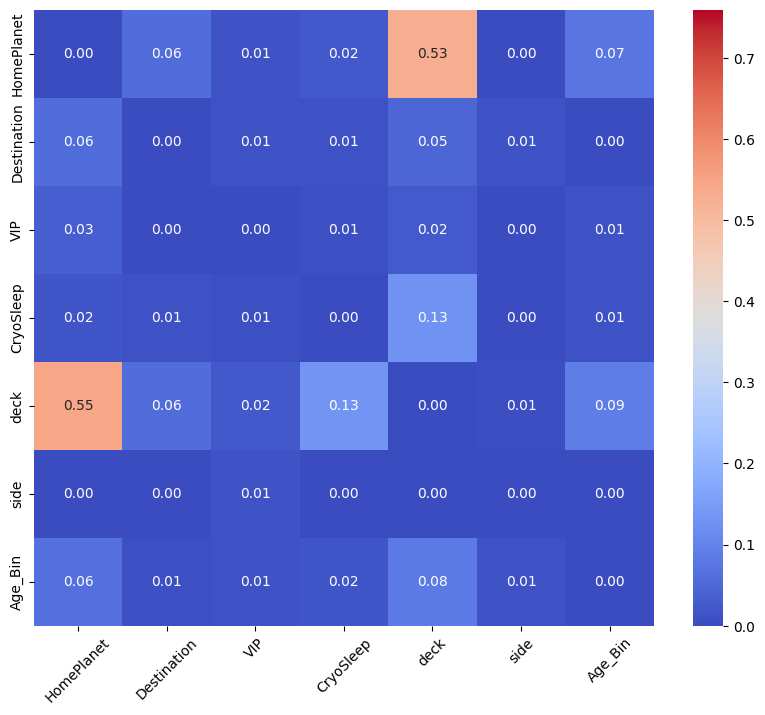

In [62]:
display(MI_matrix_NT)
Plot_MI_Heatmap(MI_matrix_NT, MI_min, MI_max)

#### Mutual Information between Categorical Variables and Target

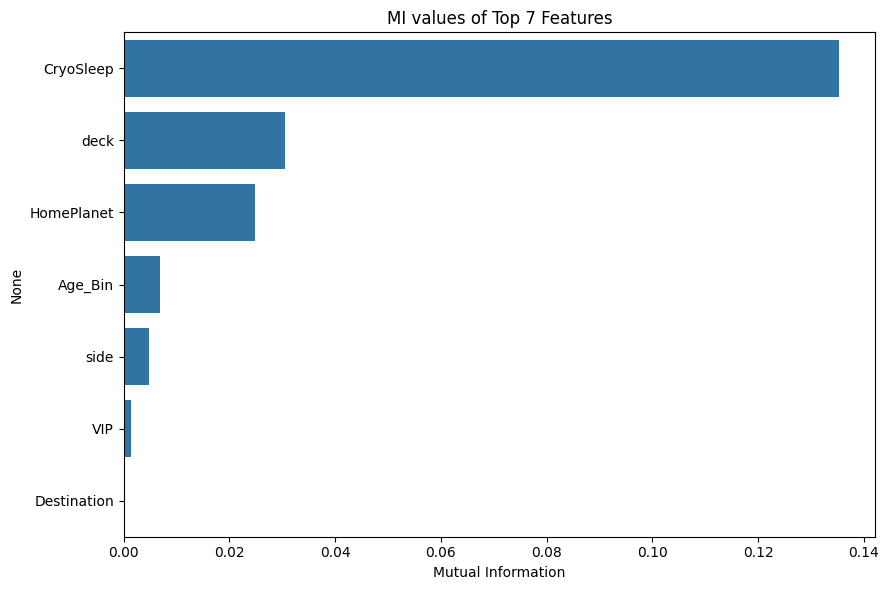

In [63]:
X = dfc.drop(columns = ['Transported'])
y = dfc['Transported']
MI = pd.Series(mutual_info_classif(X, y), index = X.columns.tolist()).sort_values(ascending = False)
Plot_MI(MI, topk = len(MI), bottom = False)

#### Since HomePlanet and deck have high mutual information, we can collate these two features into one.

In [64]:
df3 = df2[Categorical_Features + ['Transported']].dropna().copy()
df3['HomePlanet_deck'] = df3['HomePlanet'] + df3['deck']

display(df3.HomePlanet_deck.unique())

binary_features = ['VIP', 'CryoSleep']
cat_features = ['HomePlanet', 'Destination', 'deck', 'side', 'Age_Bin', 'HomePlanet_deck']

df3[binary_features] = df3[binary_features].astype(int)

for col in cat_features:
    le = LabelEncoder()
    df3[col] = le.fit_transform(df3[col].astype(str))

df3

array(['EuropaB', 'EarthF', 'EuropaA', 'EarthG', 'MarsF', 'EarthE',
       'MarsD', 'EuropaC', 'EuropaD', 'MarsE', 'EuropaE', 'EuropaT'],
      dtype=object)

HomePlanet  Destination  VIP  CryoSleep  deck  side  Age_Bin  \
0              1            2    0          0     1     0       10   
1              0            2    0          0     5     1        6   
2              1            2    1          0     0     1        2   
3              1            2    0          0     0     1        9   
4              0            2    0          0     5     1        3   
...          ...          ...  ...        ...   ...   ...      ...   
8688           1            0    1          0     0     0       10   
8689           0            1    0          1     6     1        3   
8690           0            2    0          0     6     1        7   
8691           1            0    0          0     4     1        8   
8692           1            2    0          0     4     1        1   

      Transported  HomePlanet_deck  
0           False                4  
1            True                1  
2           False                3  
3           False                3  
4            True                1  
...           ...              ...  
8688        False                3  
8689        False                2  
8690         True                2  
8691        False                7  
8692         True                7  

[7572 rows x 9 columns]

In [65]:
Categorical_Features2 = ['Destination', 'VIP', 'CryoSleep', 'side', 'Age_Bin', 'HomePlanet_deck']
MI_matrix, MI_matrix_T, MI_matrix_NT, MI_min, MI_max = Get_MI_Matrices(df3, Categorical_Features2, 'Transported')

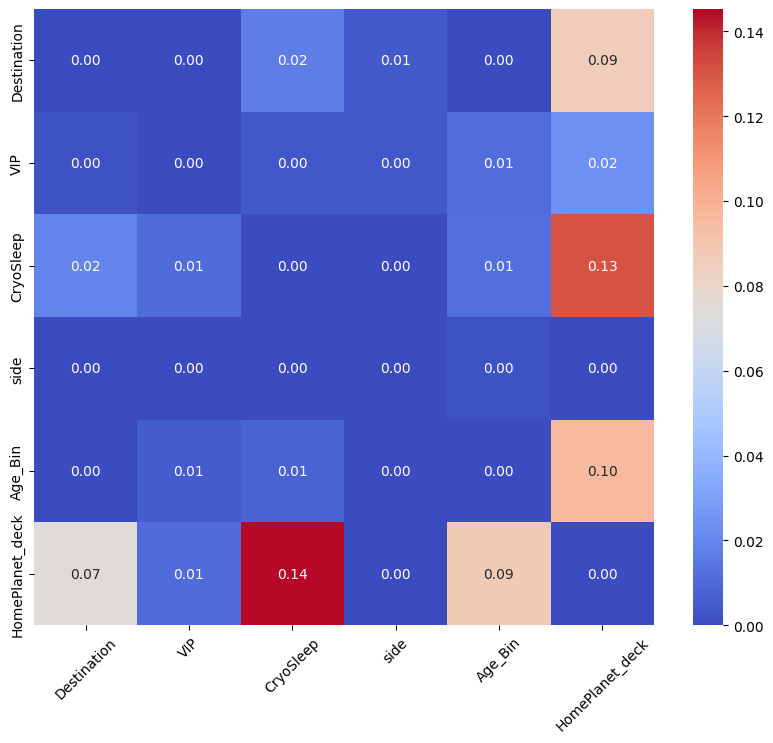

In [66]:
Plot_MI_Heatmap(MI_matrix, MI_min, MI_max)

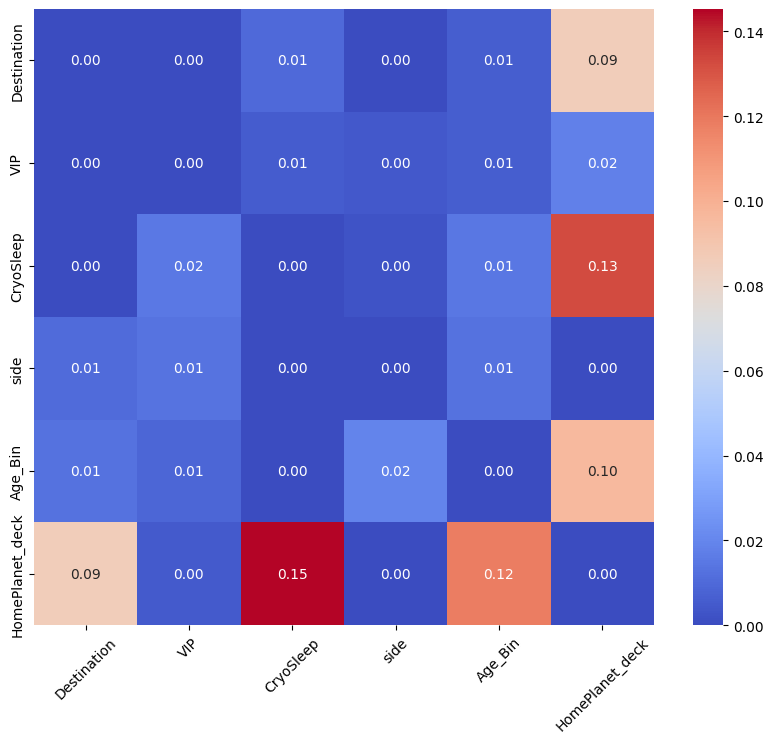

In [67]:
Plot_MI_Heatmap(MI_matrix_T, MI_min, MI_max)

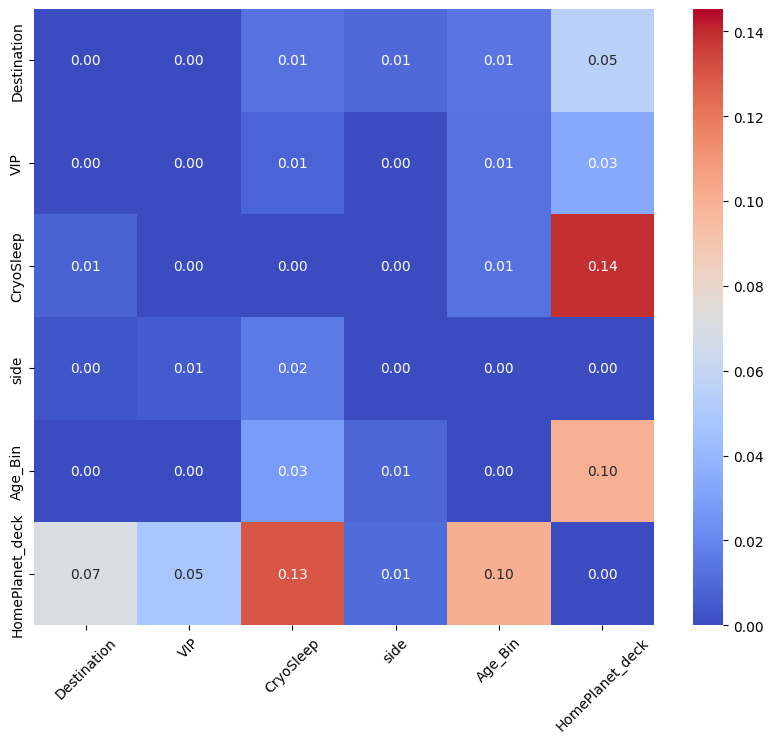

In [68]:
Plot_MI_Heatmap(MI_matrix_NT, MI_min, MI_max)

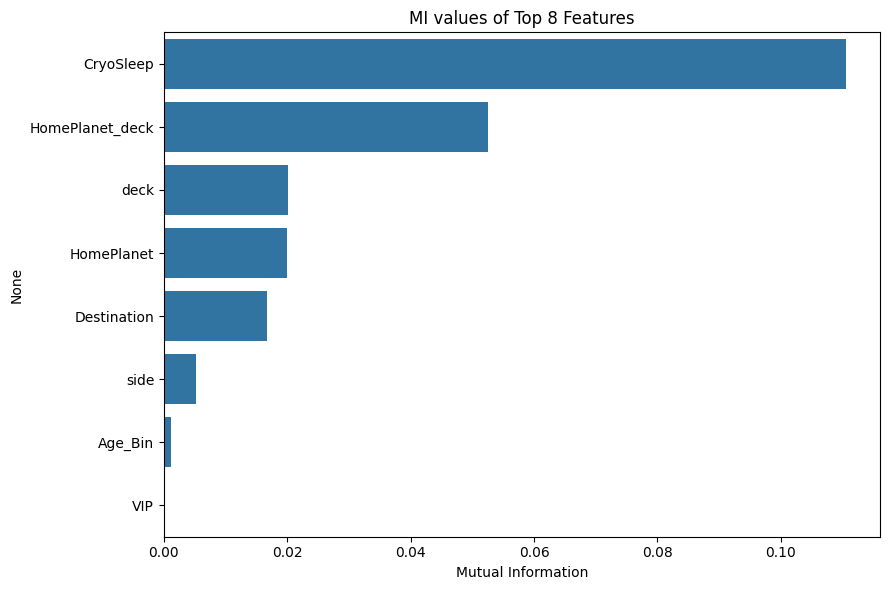

In [69]:
X = df3.drop(columns = ['Transported'])
y = df3['Transported']
MI = pd.Series(mutual_info_classif(X, y), index = X.columns.tolist()).sort_values(ascending = False)
Plot_MI(MI, topk = len(MI), bottom = False)

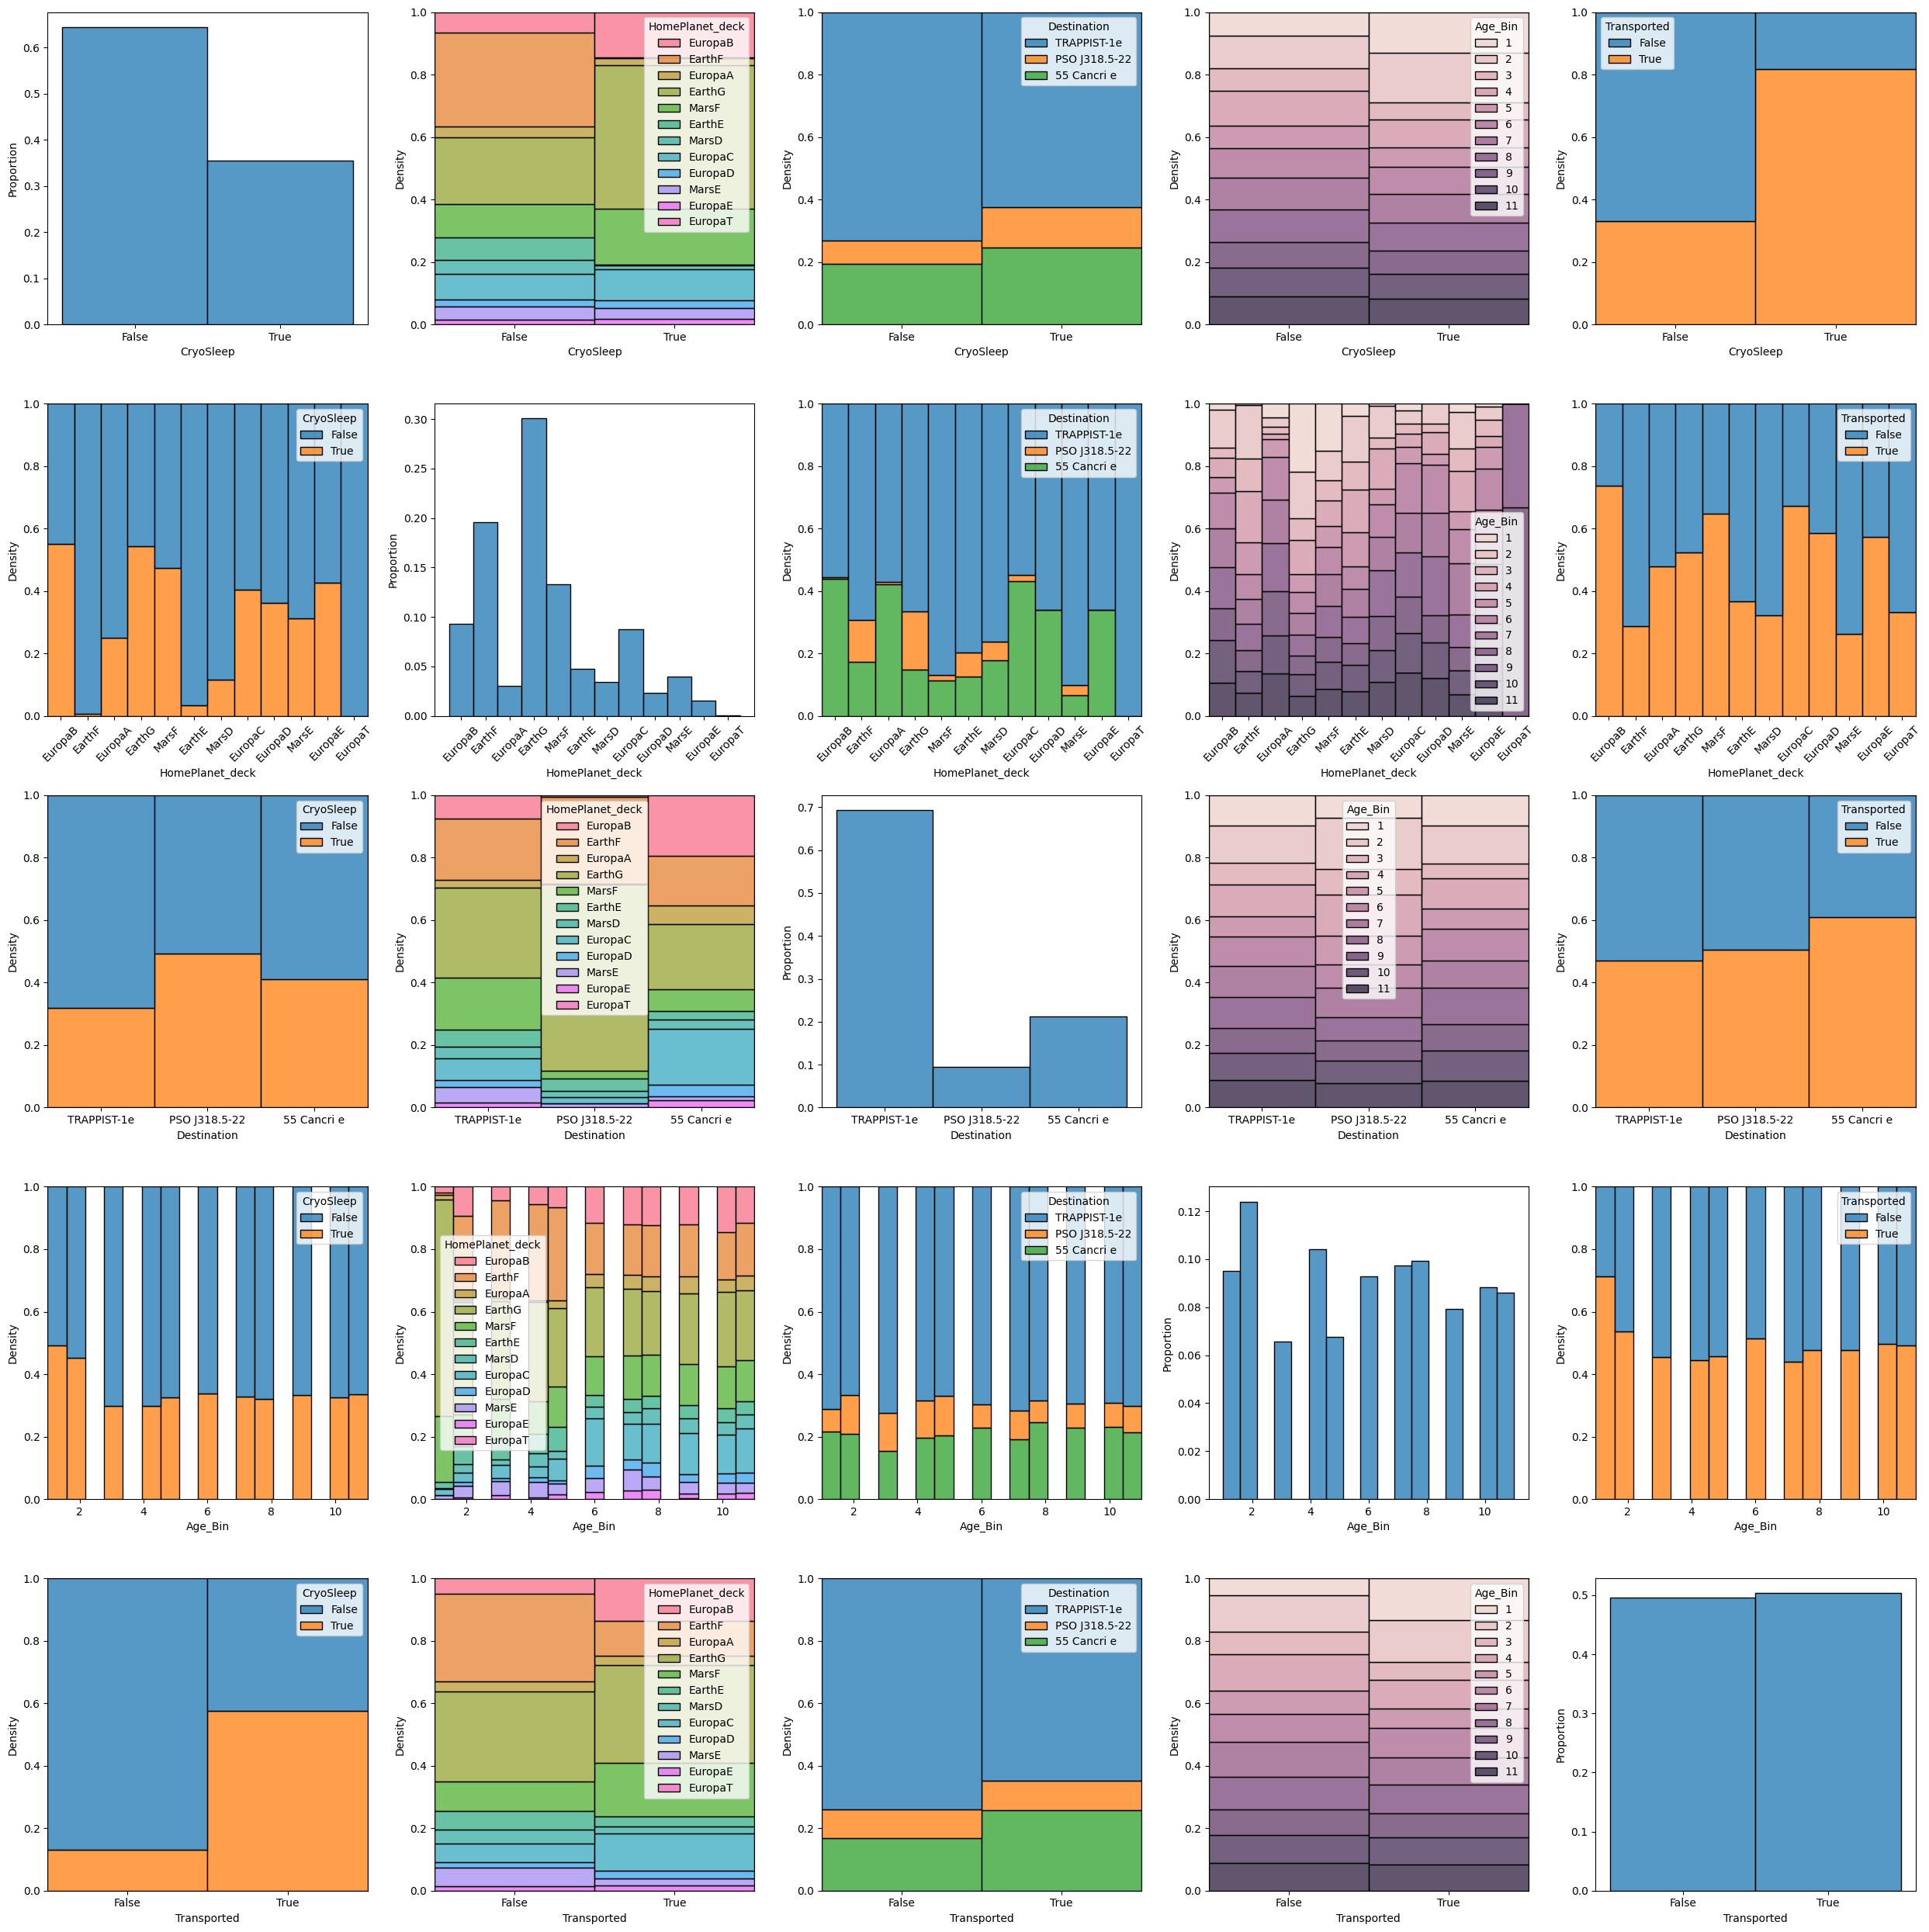

In [70]:
df4 = df2[Categorical_Features + ['Transported']].dropna().copy()
df4['HomePlanet_deck'] = df4['HomePlanet'] + df4['deck']
Gridplot_Hists(df4, ['CryoSleep', 'HomePlanet_deck', 'Destination', 'Age_Bin', 'Transported'])

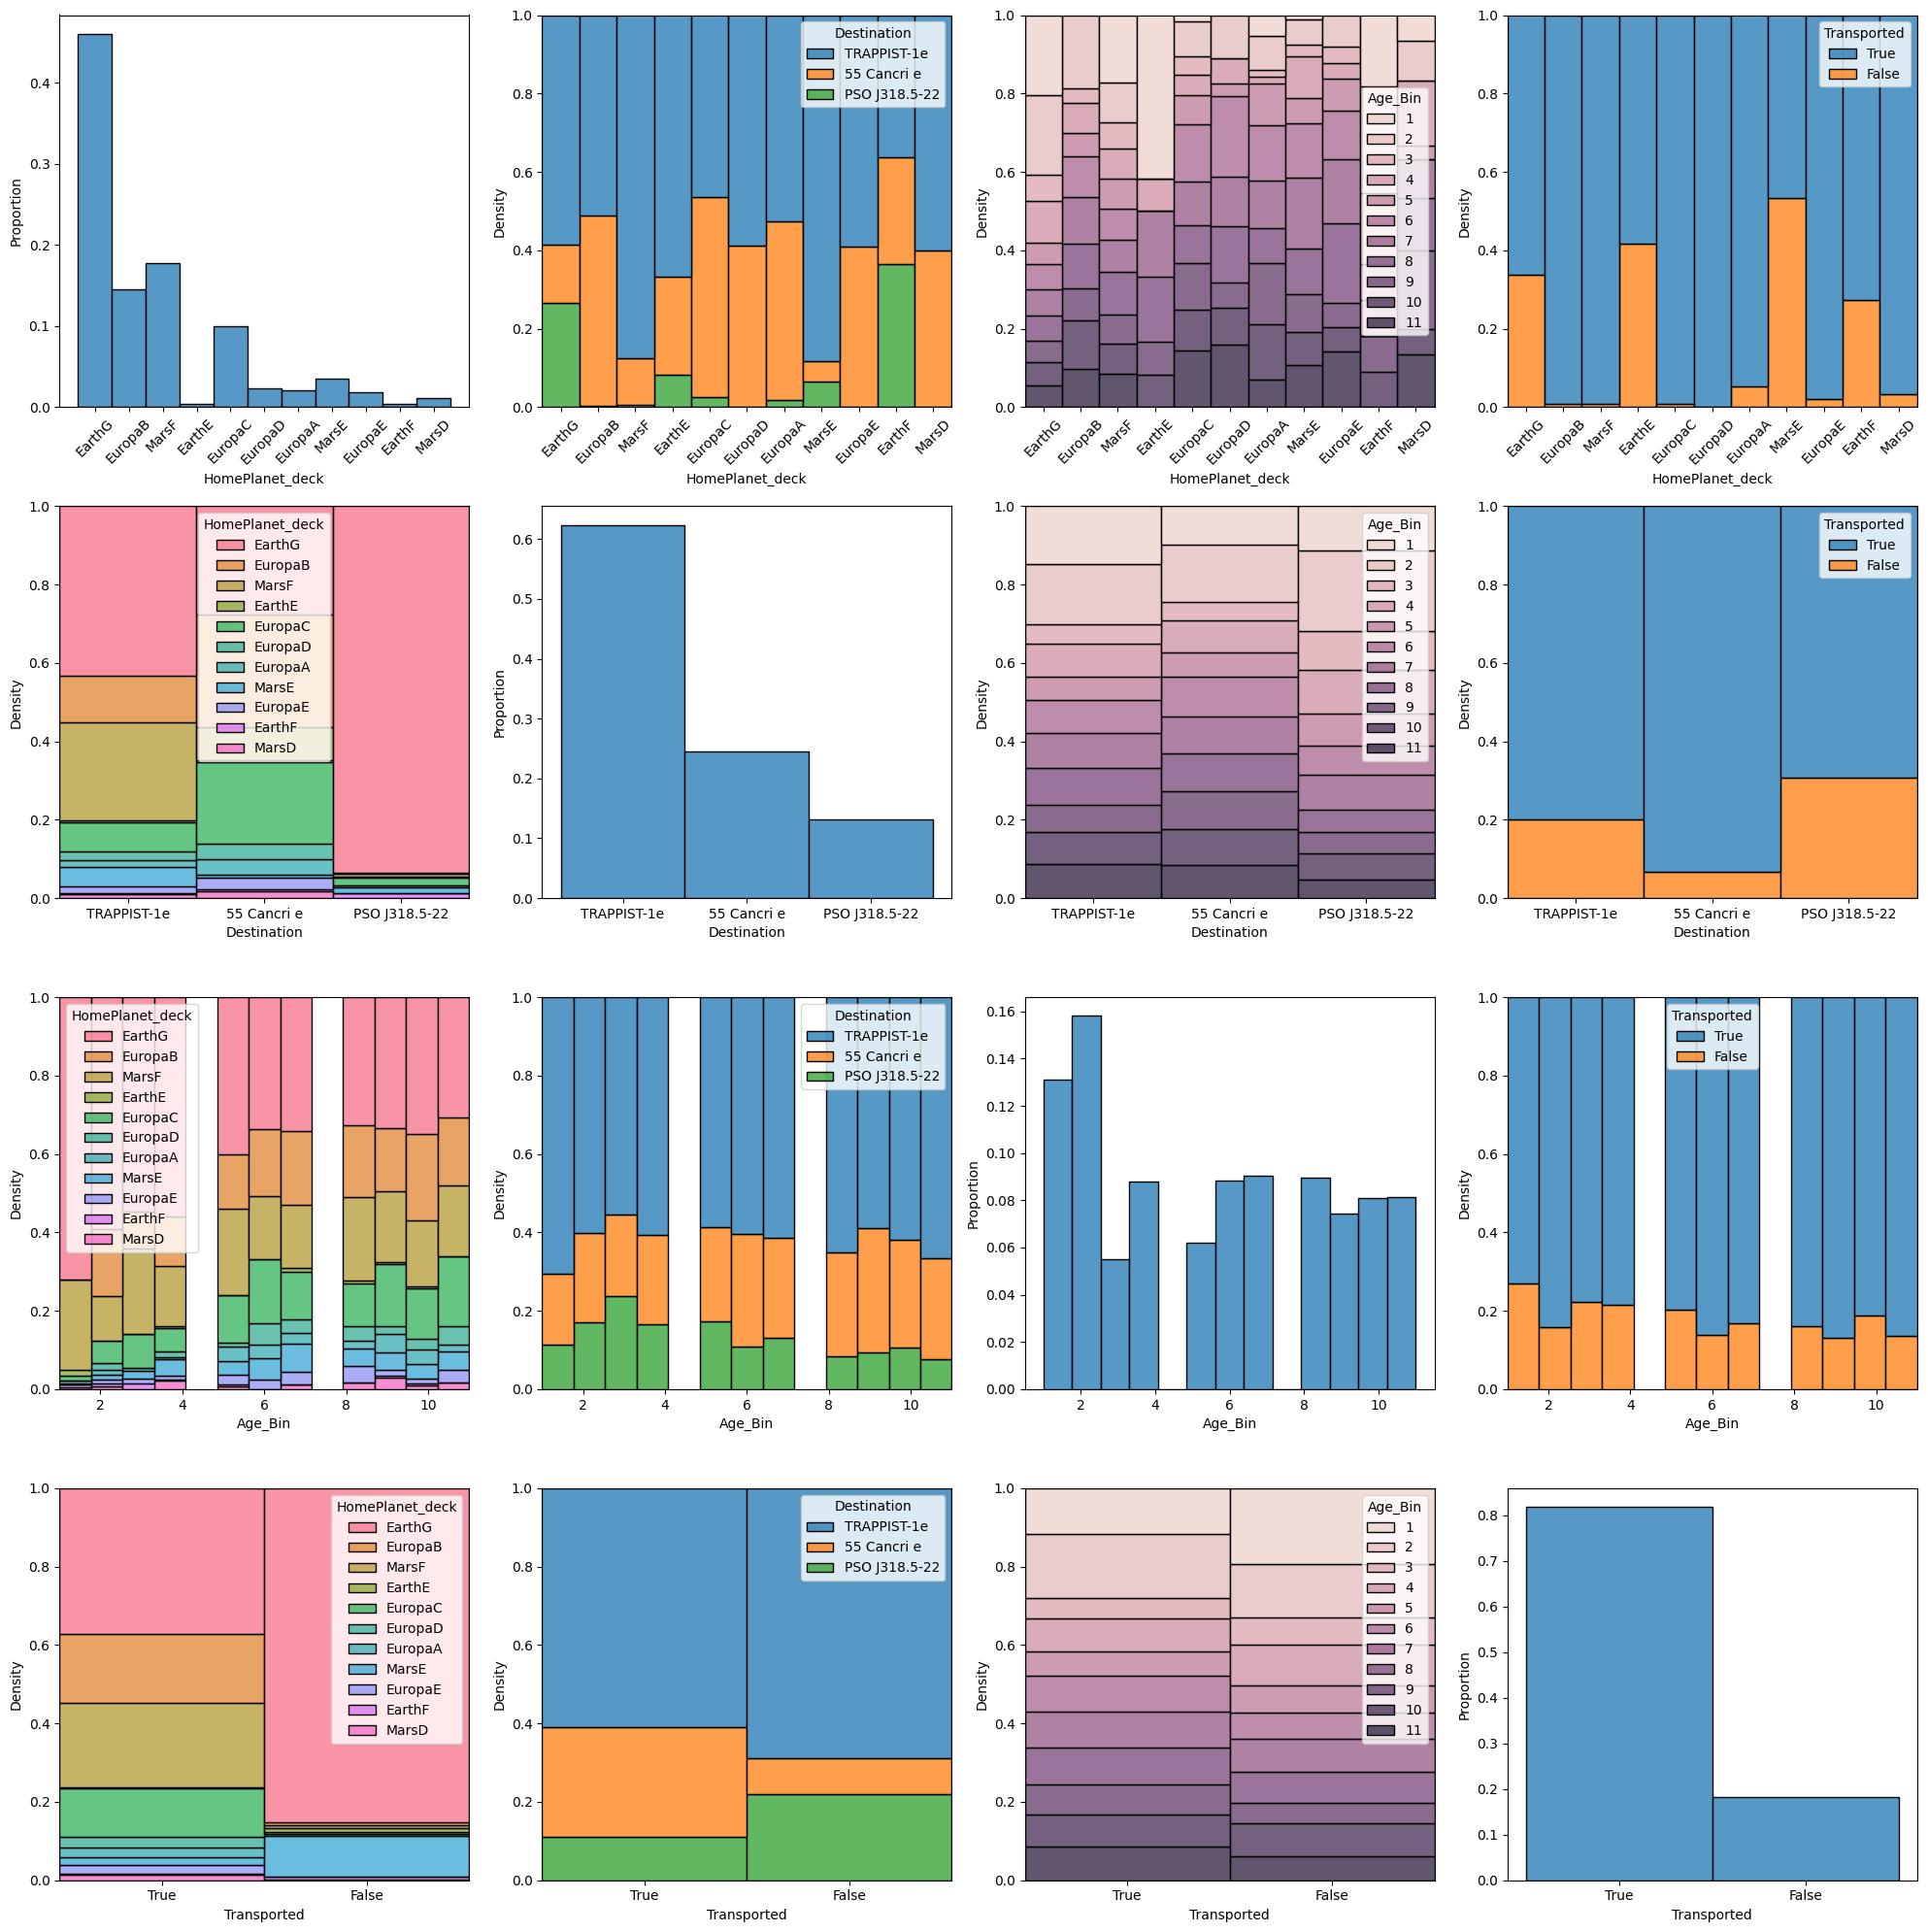

In [71]:
Gridplot_Hists(df4[df4.CryoSleep == True], ['HomePlanet_deck', 'Destination', 'Age_Bin', 'Transported'])

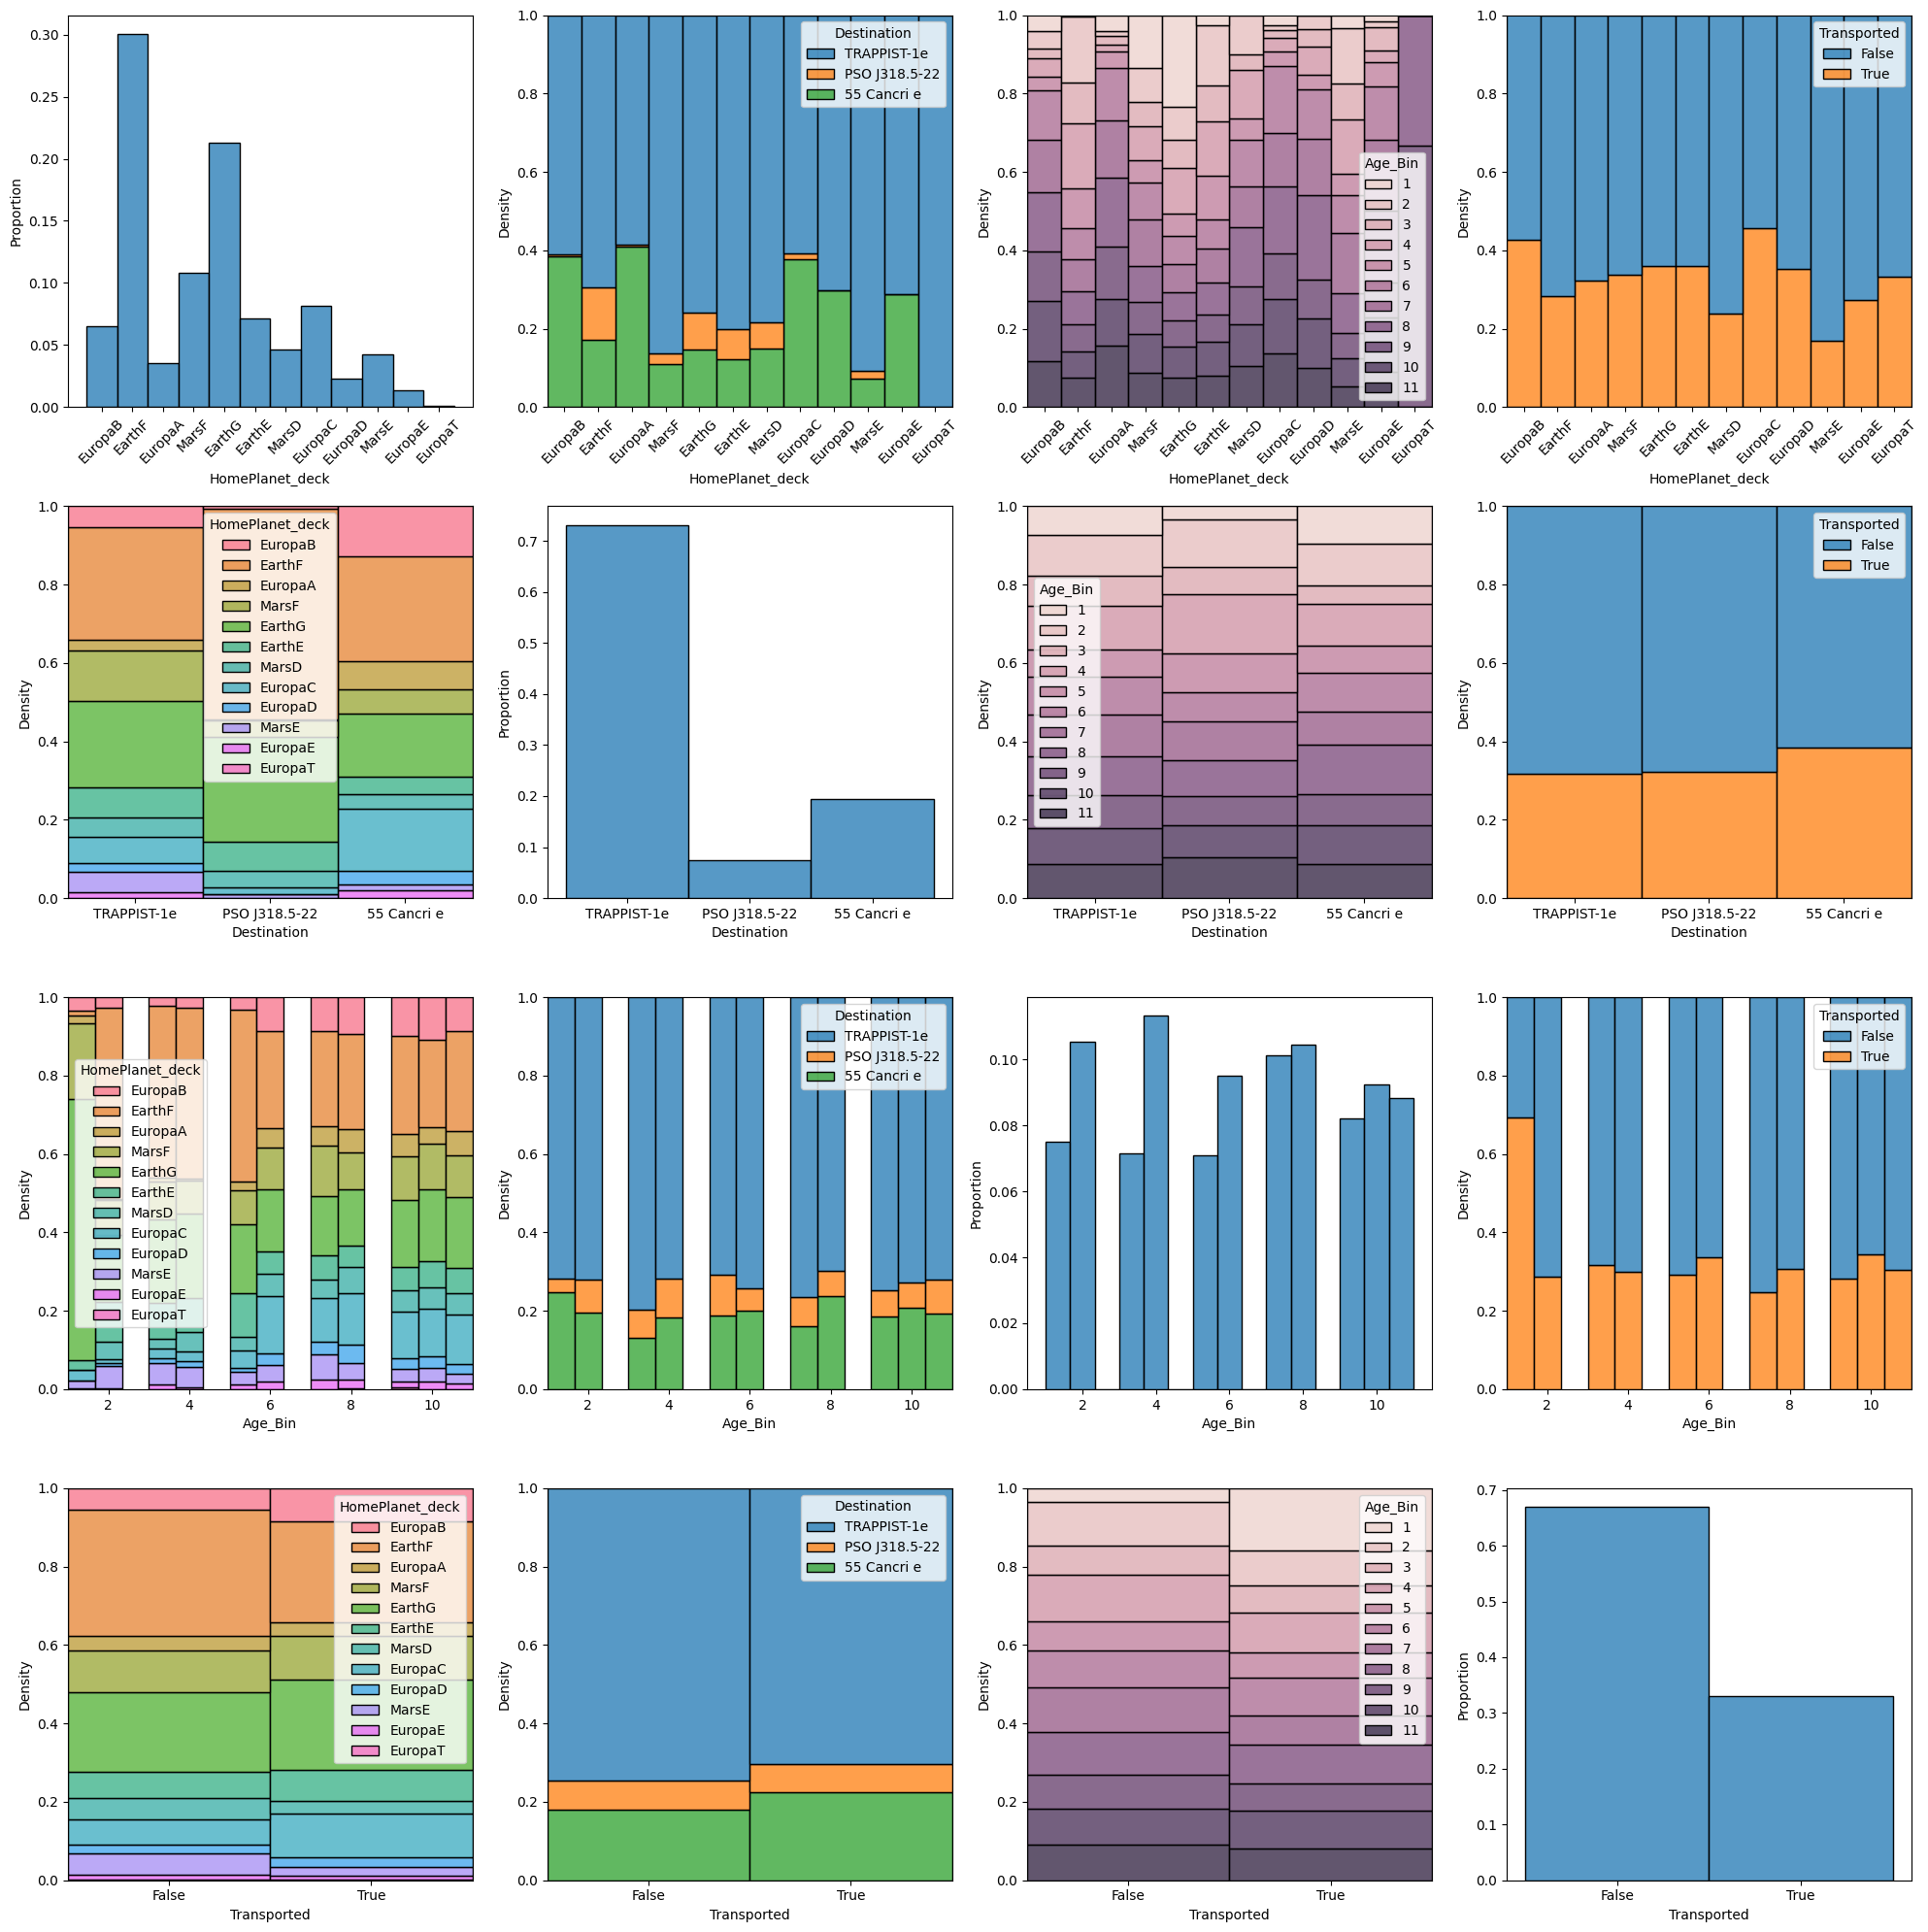

In [72]:
Gridplot_Hists(df4[df4.CryoSleep == False], ['HomePlanet_deck', 'Destination', 'Age_Bin', 'Transported'])

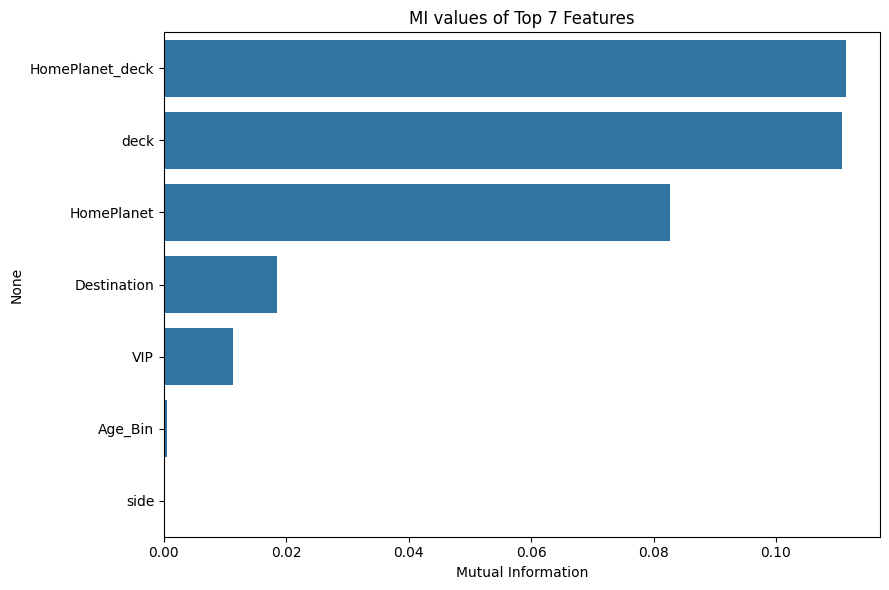

In [73]:
X = df3[df3.CryoSleep == True].drop(columns = ['Transported', 'CryoSleep'])
y = df3[df3.CryoSleep == True]['Transported']
MI = pd.Series(mutual_info_classif(X, y), index = X.columns.tolist()).sort_values(ascending = False)
Plot_MI(MI, topk = len(MI), bottom = False)

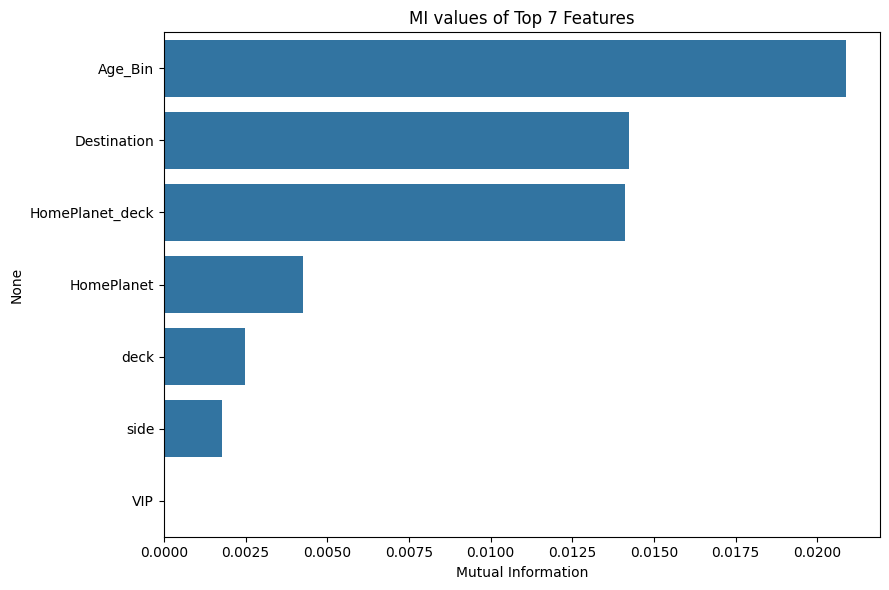

In [74]:
X = df3[df3.CryoSleep == False].drop(columns = ['Transported', 'CryoSleep'])
y = df3[df3.CryoSleep == False]['Transported']
MI = pd.Series(mutual_info_classif(X, y), index = X.columns.tolist()).sort_values(ascending = False)
Plot_MI(MI, topk = len(MI), bottom = False)

## Observations
* No passenger from Europa on decks E or D have destination PSO J318.5-22
* Passengers from Earth on deck F are extremely unlikely to be in Cryosleep
* Passengers on deck D and destination PSO J318.5-22 are all from Mars and all NOT in CryoSleep.

In [75]:
df5 = df2[['PassengerId', 'HomePlanet', 'Destination', 'CryoSleep', 'VIP', 'Age_Bin', 'deck', 'First Name', 'Last Name', 'Transported']].dropna().copy()
df5['HomePlanet_deck'] = df4['HomePlanet'] + df4['deck']
df5['FamilySize'] = df5.groupby('Last Name')['Last Name'].transform(len)
df5['FirstNameLength'] = df5['First Name'].fillna('').astype(str).apply(len)
df5['LastNameLength'] = df5['Last Name'].fillna('').astype(str).apply(len)
df5

PassengerId HomePlanet    Destination CryoSleep    VIP Age_Bin deck  \
0        0001_01     Europa    TRAPPIST-1e     False  False       9    B   
1        0002_01      Earth    TRAPPIST-1e     False  False       5    F   
2        0003_01     Europa    TRAPPIST-1e     False   True      11    A   
3        0003_02     Europa    TRAPPIST-1e     False  False       8    A   
4        0004_01      Earth    TRAPPIST-1e     False  False       2    F   
...          ...        ...            ...       ...    ...     ...  ...   
8688     9276_01     Europa    55 Cancri e     False   True       9    A   
8689     9278_01      Earth  PSO J318.5-22      True  False       2    G   
8690     9279_01      Earth    TRAPPIST-1e     False  False       6    G   
8691     9280_01     Europa    55 Cancri e     False  False       7    E   
8692     9280_02     Europa    TRAPPIST-1e     False  False      10    E   

     First Name    Last Name  Transported HomePlanet_deck  FamilySize  \
0         Maham    Ofracculy        False         EuropaB           1   
1        Juanna        Vines         True          EarthF           3   
2        Altark       Susent        False         EuropaA           6   
3         Solam       Susent        False         EuropaA           6   
4         Willy  Santantines         True          EarthF           6   
...         ...          ...          ...             ...         ...   
8688    Gravior    Noxnuther        False         EuropaA           2   
8689      Kurta    Mondalley        False          EarthG           2   
8690      Fayey       Connon         True          EarthG           5   
8691     Celeon    Hontichre        False         EuropaE           4   
8692     Propsh    Hontichre         True         EuropaE           4   

      FirstNameLength  LastNameLength  
0                   5               9  
1                   6               5  
2                   6               6  
3                   5               6  
4                   5              11  
...               ...             ...  
8688                7               9  
8689                5               9  
8690                5               6  
8691                6               9  
8692                6               9  

[7398 rows x 14 columns]

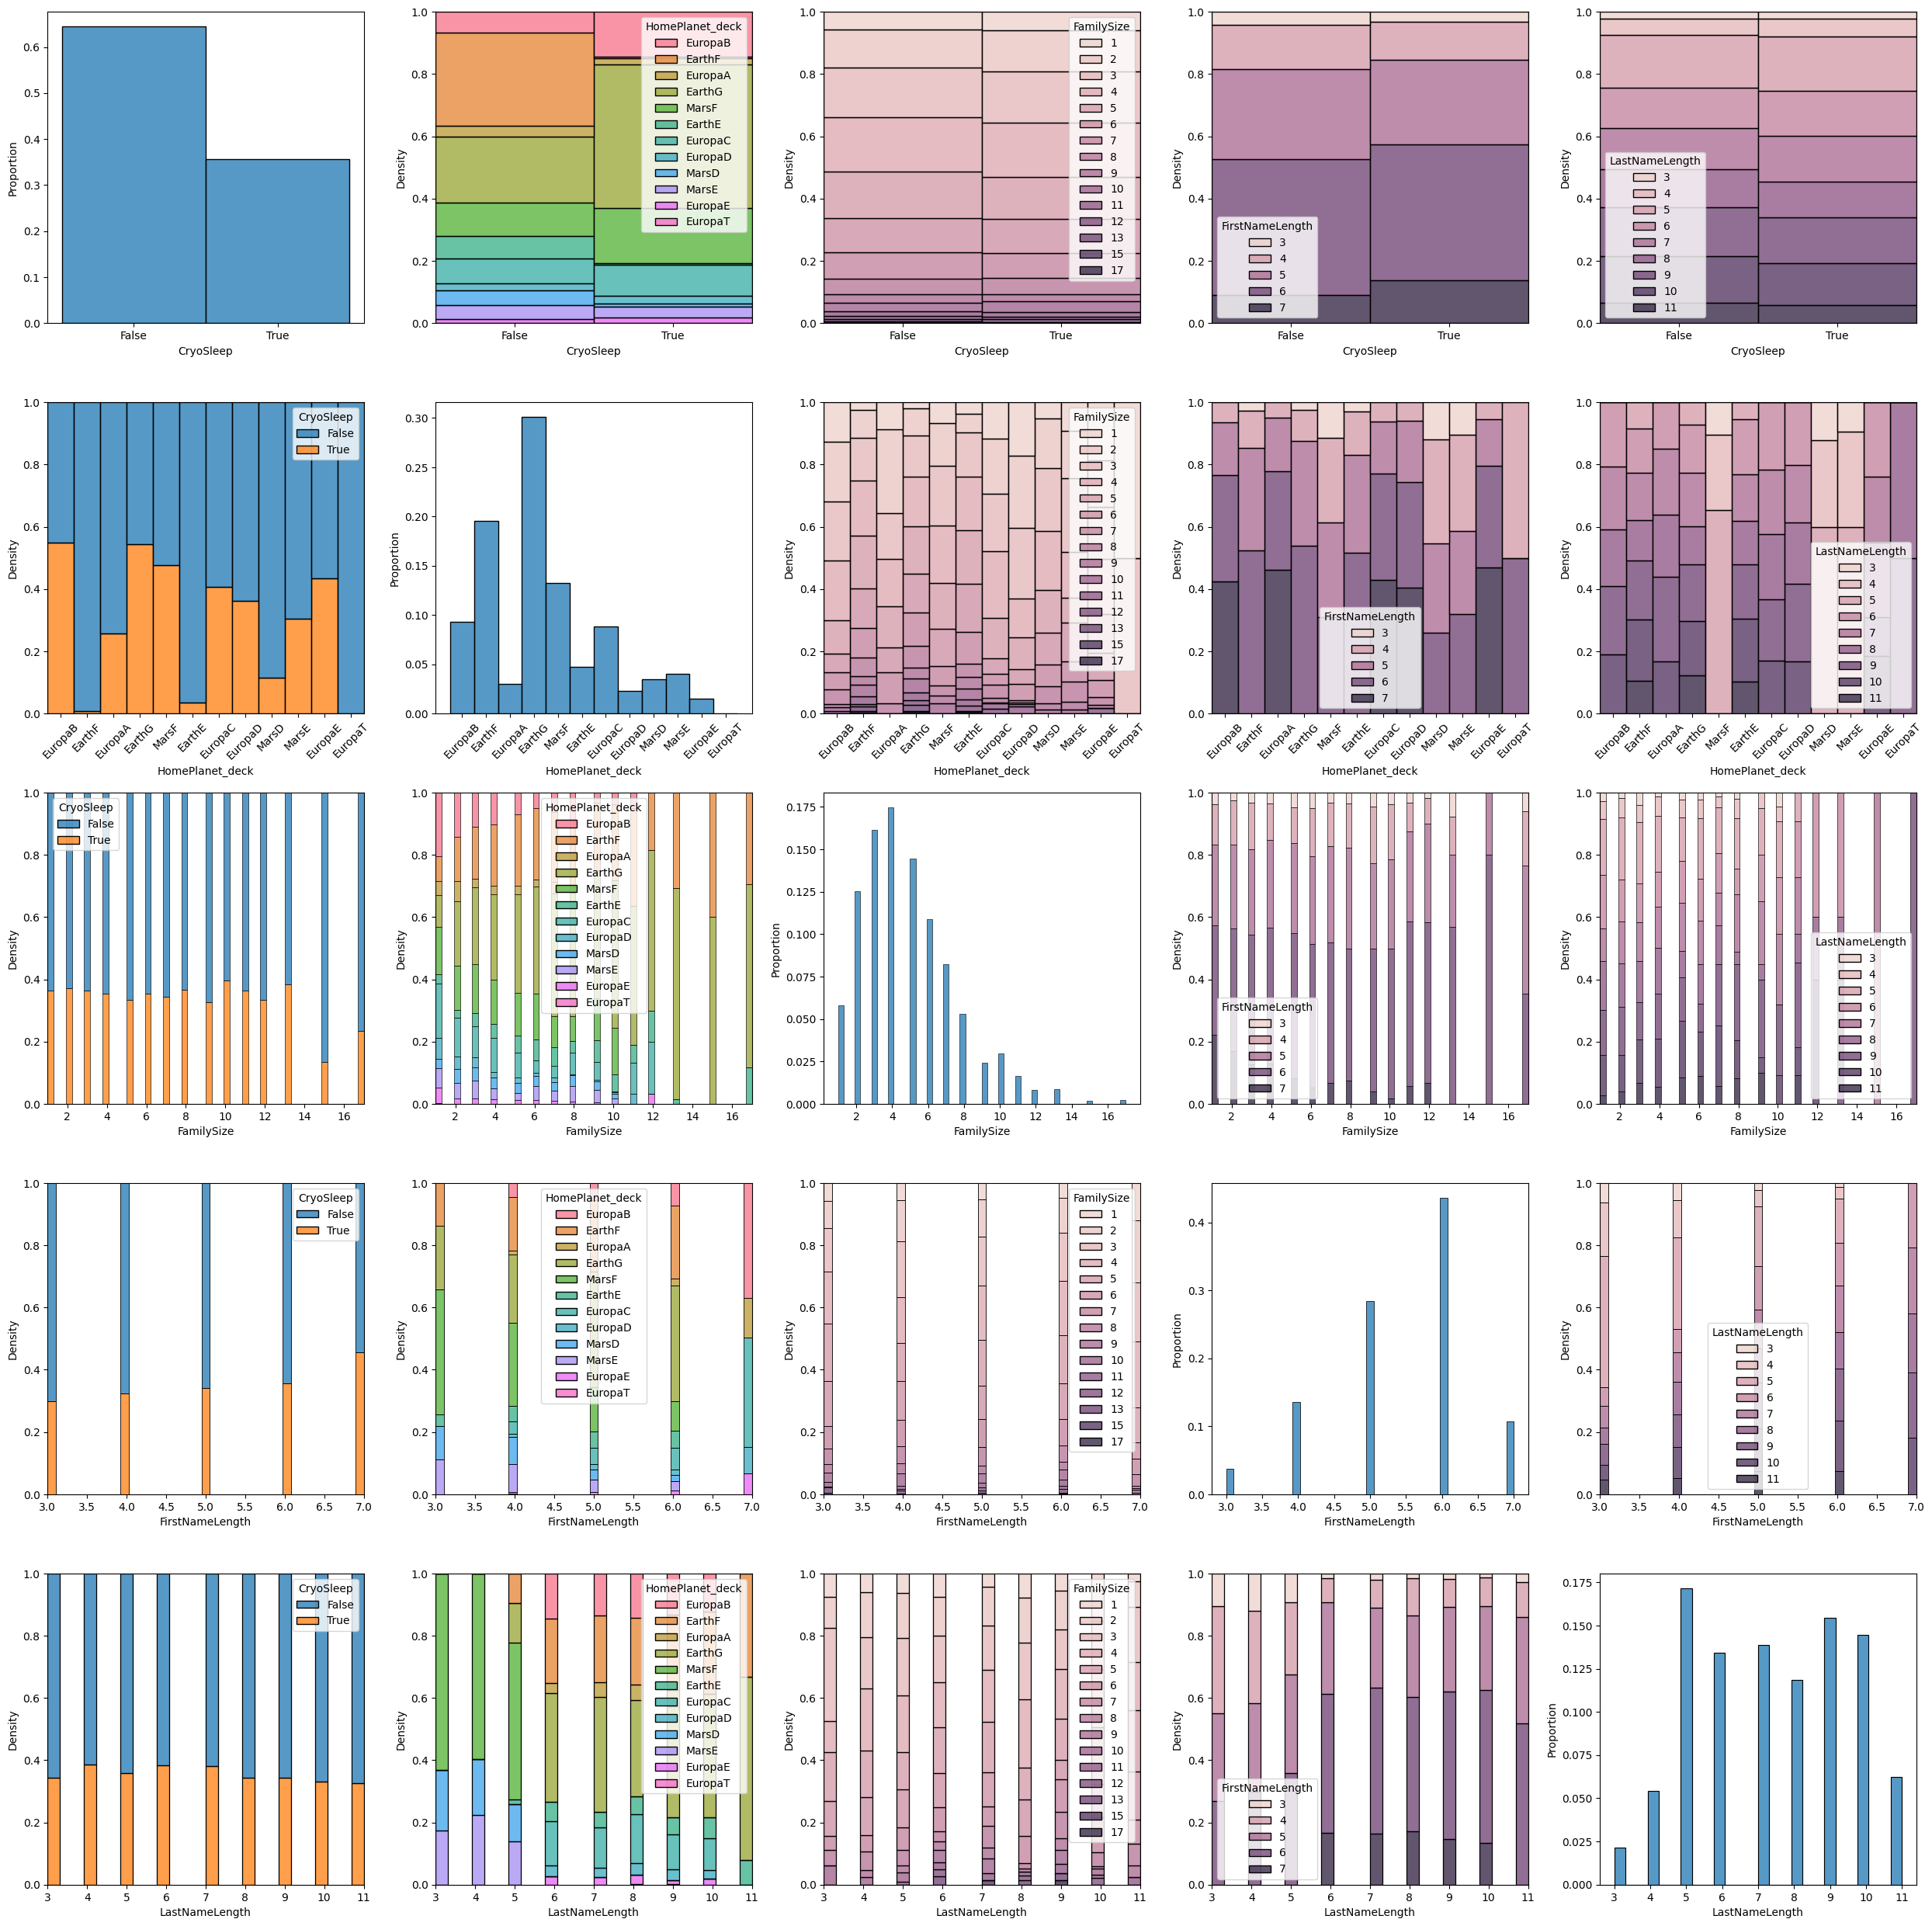

In [76]:
Gridplot_Hists(df5, ['CryoSleep', 'HomePlanet_deck', 'FamilySize', 'FirstNameLength', 'LastNameLength'])

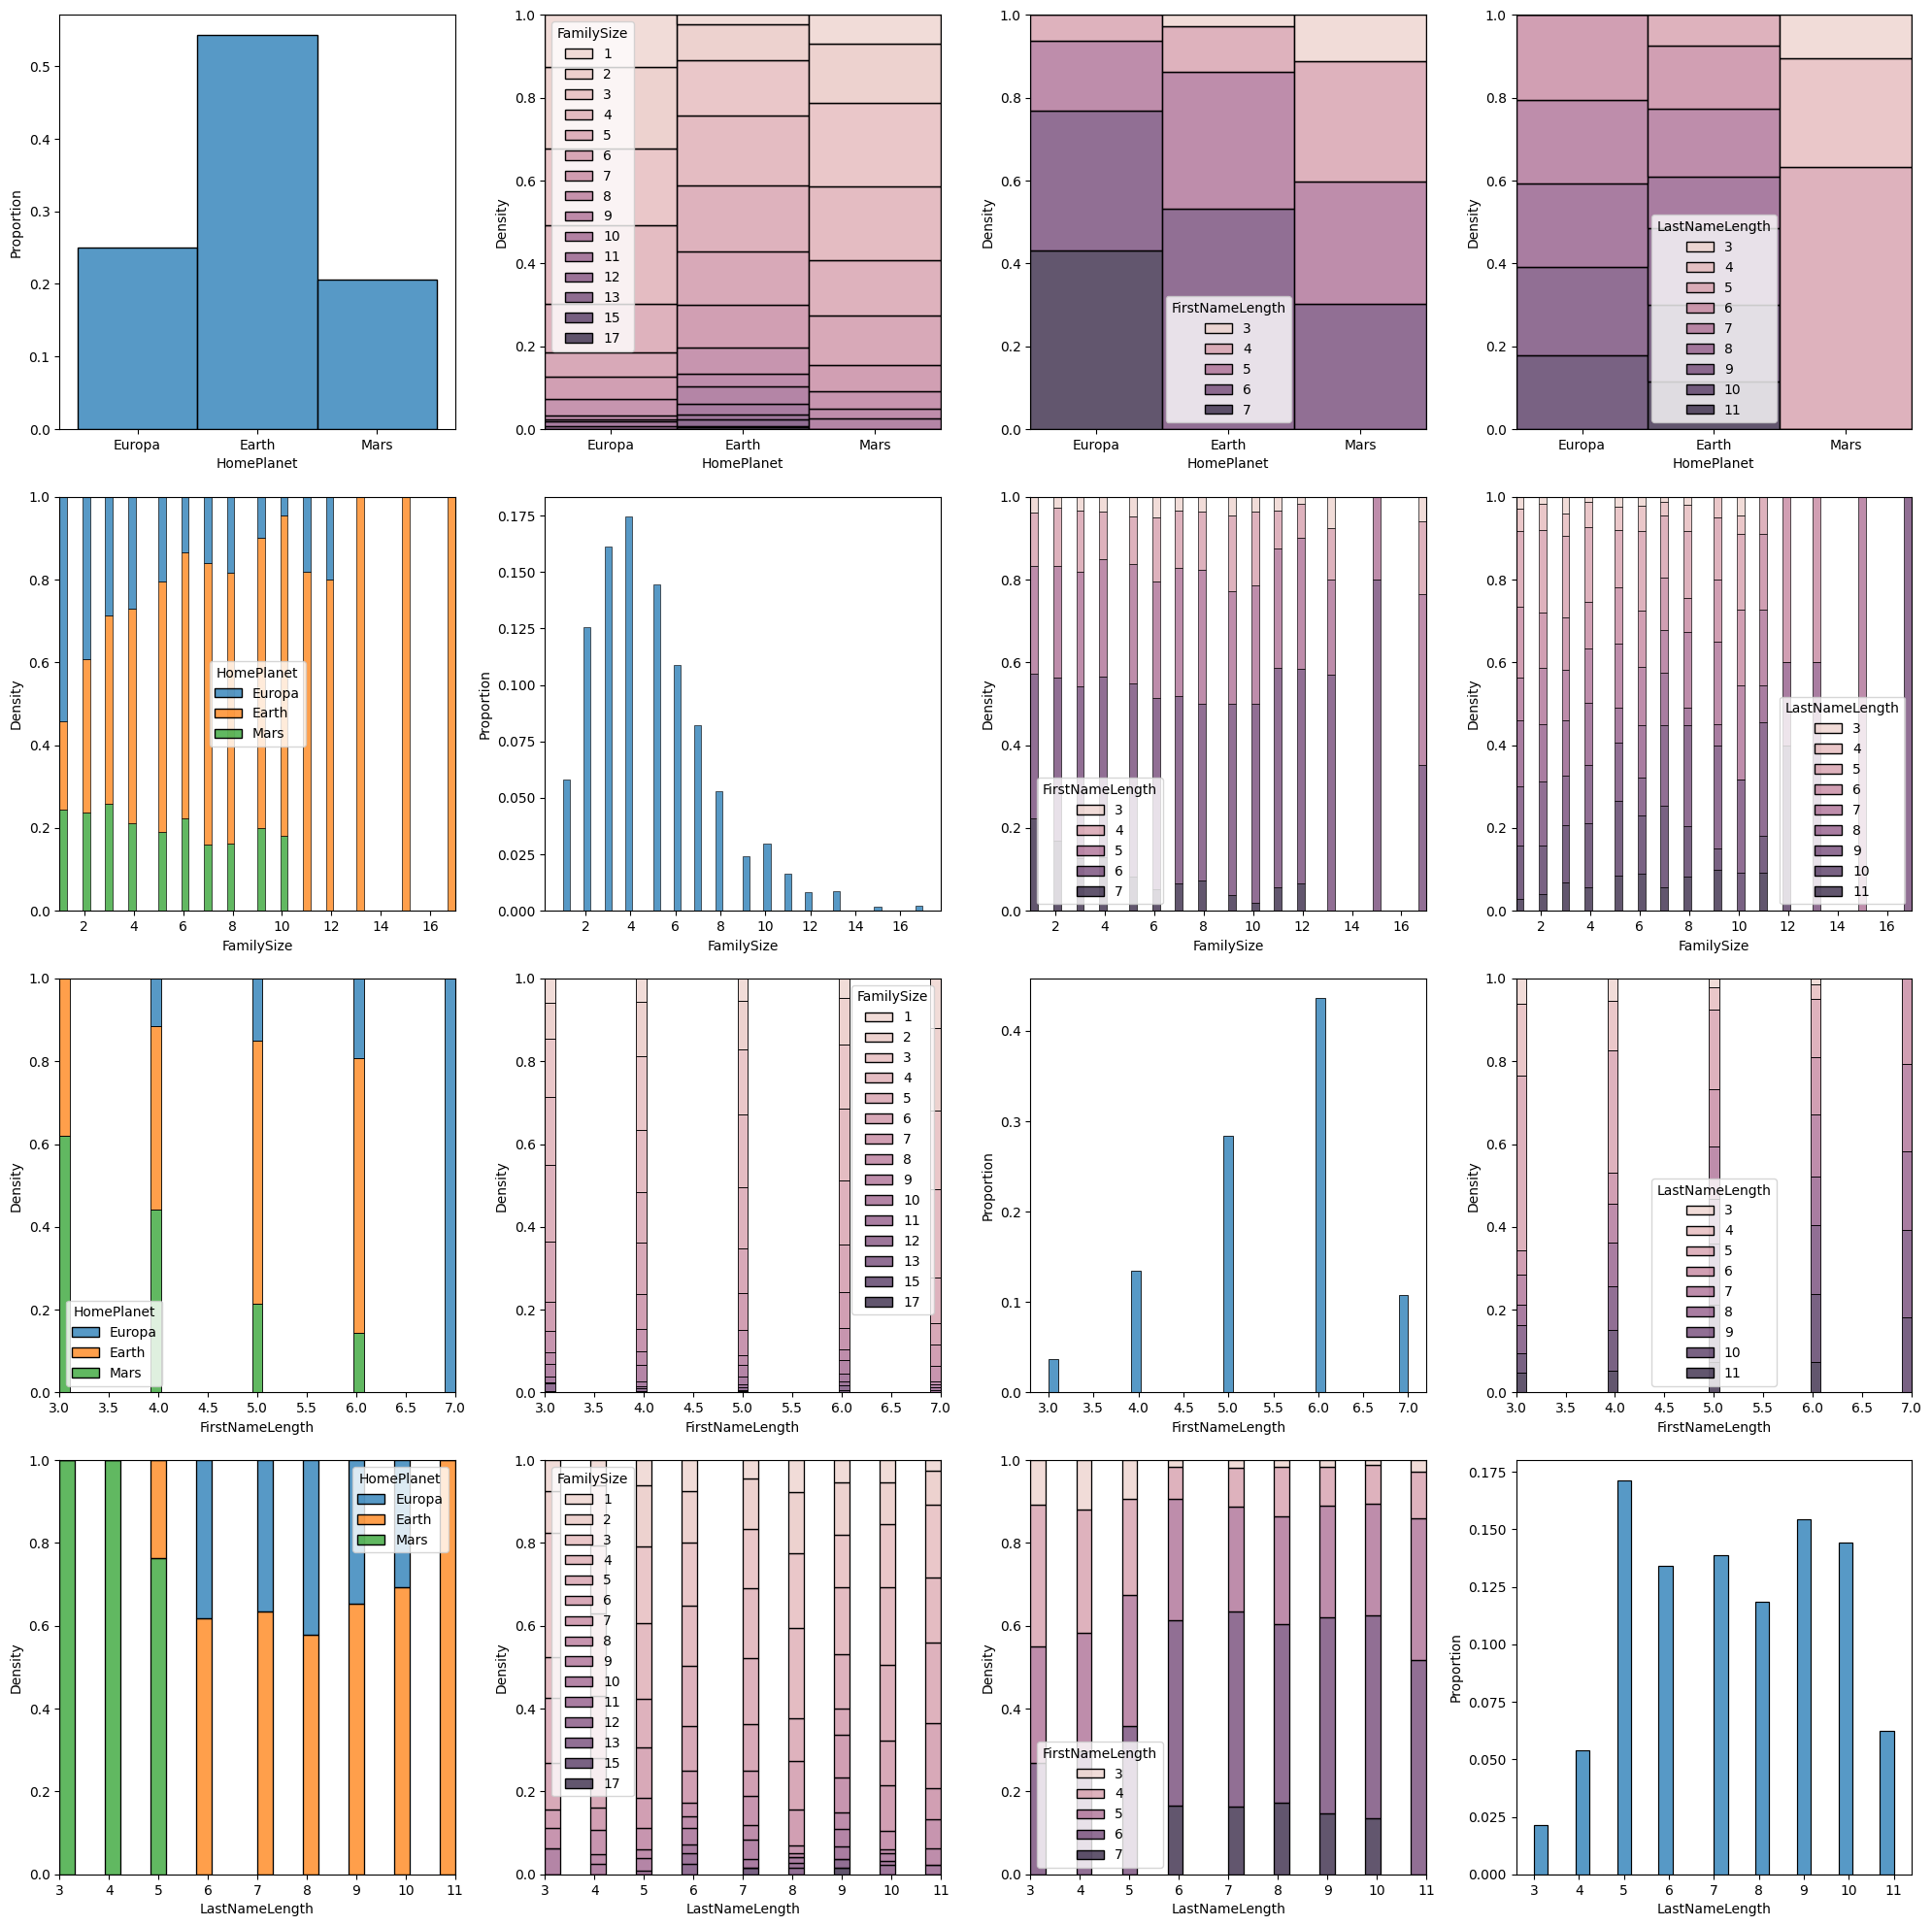

In [78]:
Gridplot_Hists(df5, ['HomePlanet', 'FamilySize', 'FirstNameLength', 'LastNameLength'])

* Passengers with FamilySize > 12 are all from Earth
* No passenger with FamilySize > 10 is from Mars
* Solo passengers are more likely to be from Europa
* Passengers from Europa tend to have longer First Names while passengers from Mars tend to have shorter ones
* Passengers with FirstNameLength > 6 are all from Europa
* No passenger with FirstNameLength < 4 is from Europa
* All passengers with LastNameLength > 10 are from Earth
* No passenger with LastNameLength < 6 or > 10 is from Europa
* All passengers with LastNameLength < 5 are from Mars

In [86]:
df5.groupby('Last Name').HomePlanet.nunique().max()

1

In [87]:
df5.groupby('Last Name').deck.nunique().max()

4

* Passengers with the same Family Name are from the same HomePlanet but not necessarily same deck

In [89]:
df6 = Extract_PassengerId_Info(df5)
df6

PassengerId HomePlanet    Destination CryoSleep    VIP Age_Bin deck  \
0        0001_01     Europa    TRAPPIST-1e     False  False       9    B   
1        0002_01      Earth    TRAPPIST-1e     False  False       5    F   
2        0003_01     Europa    TRAPPIST-1e     False   True      11    A   
3        0003_02     Europa    TRAPPIST-1e     False  False       8    A   
4        0004_01      Earth    TRAPPIST-1e     False  False       2    F   
...          ...        ...            ...       ...    ...     ...  ...   
8688     9276_01     Europa    55 Cancri e     False   True       9    A   
8689     9278_01      Earth  PSO J318.5-22      True  False       2    G   
8690     9279_01      Earth    TRAPPIST-1e     False  False       6    G   
8691     9280_01     Europa    55 Cancri e     False  False       7    E   
8692     9280_02     Europa    TRAPPIST-1e     False  False      10    E   

     First Name    Last Name  Transported  ... FamilySize  FirstNameLength  \
0         Maham    Ofracculy        False  ...          1                5   
1        Juanna        Vines         True  ...          3                6   
2        Altark       Susent        False  ...          6                6   
3         Solam       Susent        False  ...          6                5   
4         Willy  Santantines         True  ...          6                5   
...         ...          ...          ...  ...        ...              ...   
8688    Gravior    Noxnuther        False  ...          2                7   
8689      Kurta    Mondalley        False  ...          2                5   
8690      Fayey       Connon         True  ...          5                5   
8691     Celeon    Hontichre        False  ...          4                6   
8692     Propsh    Hontichre         True  ...          4                6   

      LastNameLength  GroupId ppId  GroupSize  G1 G2 G3 G4  
0                  9     0001    1          1   0  0  0  1  
1                  5     0002    1          1   0  0  0  2  
2                  6     0003    1          2   0  0  0  3  
3                  6     0003    2          2   0  0  0  3  
4                 11     0004    1          1   0  0  0  4  
...              ...      ...  ...        ...  .. .. .. ..  
8688               9     9276    1          1   9  2  7  6  
8689               9     9278    1          1   9  2  7  8  
8690               6     9279    1          1   9  2  7  9  
8691               9     9280    1          2   9  2  8  0  
8692               9     9280    2          2   9  2  8  0  

[7398 rows x 21 columns]

In [90]:
df6.groupby('GroupId').HomePlanet.nunique().max()

1

In [91]:
df6.groupby('GroupId').deck.nunique().max()

3

In [92]:
df6.groupby('GroupId')['Last Name'].nunique().max()

3

In [93]:
df6.groupby('GroupId').Destination.nunique().max()

3

* Passengers with the same GroupId are from the same HomePlanet but not necessarily on the same deck, Destination, or Last Name